# Hypothesis 6 Justice Principles: Multilingual Descriptive Analysis

This notebook extends the Hypothesis 1 descriptive workflow to Hypothesis 6 experiment runs. We replicate the full descriptive analysis for the three language cohorts (English, Spanish, Mandarin), retaining the University of Bayreuth visual system and comparing outputs across groups.

**Design System Notes**  
- Bayreuth Green `#009260` anchors positive and consensus outcomes.  
- Dark Gray `#48535A`, Medium Gray `#7F8990`, and Light Gray `#EBEBE4` support typography, baselines, and gridlines.  
- Figures target <=12" width, grid-on-y by default, and aligned bar/heatmap annotations.  
- Preference colours map consistently across waves and cohorts for direct comparison.

In [1]:
import json
from dataclasses import dataclass
from collections import OrderedDict
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib
import sys
if "ipykernel" not in sys.modules:
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from IPython.display import Markdown, display


_NOTEBOOK_DIR = Path.cwd().resolve()
for candidate in [_NOTEBOOK_DIR, *_NOTEBOOK_DIR.parents]:
    if (candidate / "hypothesis_testing").exists() and (candidate / "config").exists():
        if str(candidate) not in sys.path:
            sys.path.insert(0, str(candidate))
        break

from hypothesis_testing.utils_hypothesis_testing.style import (
    BAYREUTH_COLORS as COLORS,
    PRINCIPLE_COLORS,
    PRINCIPLE_DISPLAY_NAMES,
    BAYREUTH_FONT_SIZES as FONT_SIZES,
    BAYREUTH_FIG_SIZES as FIG_SIZES,
    apply_bayreuth_theme,
    format_principle_label,
    format_principle_labels,
)
from hypothesis_testing.utils_hypothesis_testing import (
    plot_floor_constraint_distribution,
    plot_floor_constraint_distribution_grouped,
    plot_income_composition,
    plot_income_preference_bars,
    plot_long_term_margin,
    plot_long_term_stability,
    plot_long_term_stability_grid,
    plot_rounds_to_outcome,
    plot_rounds_to_outcome_grouped,
    plot_transition_heatmaps,
    plot_voting_attempts_summary,
    plot_preference_stability,
)
from hypothesis_testing.utils_hypothesis_testing.visualizations import plot_long_term_counts_grid


apply_bayreuth_theme()


In [ ]:
LANGUAGE_GROUPS: "OrderedDict[str, str]" = OrderedDict([
    ("English", "english"),
    ("Spanish", "spanish"),
    ("Mandarin", "mandarin"),
])

PRINCIPLE_LABELS = {
    "maximizing_average": "Max Avg Income",
    "maximizing_average_floor_constraint": "Max Avg + Floor",
    "maximizing_average_range_constraint": "Max Avg + Range",
    "maximizing_floor": "Max Floor",
    "failure": "Failure",
    None: "None",
}

CERTAINTY_TO_SCORE = {
    "very_unsure": 1,
    "unsure": 1,
    "neutral": 2,
    "sure": 2,
    "very_sure": 3,
    "no_opinion": np.nan,
    None: np.nan,
}

WAVE_DEFINITIONS = [
    ("initial_ranking", "Wave 1 - Initial", 1),
    ("ranking_2", "Wave 2 - Post-Explanation", 2),
    ("ranking_3", "Wave 3 - Final Phase 1", 3),
]
FINAL_WAVE = ("Wave 4 - Post-Group", 4)
WAVE_ORDER = [label for _, label, _ in WAVE_DEFINITIONS] + [FINAL_WAVE[0]]

PRINCIPLE_ORDER = ["Max Floor", "Max Avg Income", "Max Avg + Floor", "Max Avg + Range"]
PRINCIPLE_DISPLAY_ORDER = [PRINCIPLE_DISPLAY_NAMES[name] for name in PRINCIPLE_ORDER]

In [3]:

def locate_project_root(markers: Tuple[str, ...] = ("hypothesis_testing", "config")) -> Path:
    """Locate the project root by walking up the directory tree."""
    start = Path.cwd().resolve()
    for candidate in [start, *start.parents]:
        if all((candidate / marker).exists() for marker in markers):
            return candidate
    raise FileNotFoundError("Could not locate project root from current working directory.")


PROJECT_ROOT = locate_project_root()
RESULTS_ROOT = PROJECT_ROOT / "hypothesis_testing" / "hypothesis_6" / "results"
TERMINAL_ROOT = PROJECT_ROOT / "hypothesis_testing" / "hypothesis_6" / "terminal_outputs"


def _resolve_result_path(path: Path) -> Path:
    if not path.is_absolute():
        path = (PROJECT_ROOT / path).resolve()
    return path


def load_group_runs(language_slug: str, include_logs: bool = True) -> List[Tuple[str, Dict[str, Any]]]:
    result_dir = RESULTS_ROOT / language_slug
    pattern = f"hypothesis_6_{language_slug}_condition_*_config_results.json"
    result_paths = {p.resolve() for p in result_dir.glob(pattern)}

    if include_logs:
        logs_dir = TERMINAL_ROOT / language_slug
        if logs_dir.exists():
            for log_path in logs_dir.glob(f"hypothesis_6_{language_slug}_condition_*_log"):
                try:
                    first_line = log_path.read_text(encoding="utf-8").splitlines()[0]
                except Exception:
                    continue
                parts = first_line.strip().split()
                if parts[:1] == ["CMD:"] and parts[-1].endswith(".json"):
                    candidate = _resolve_result_path(Path(parts[-1]))
                    if candidate.name.startswith(f"hypothesis_6_{language_slug}_condition_"):
                        result_paths.add(candidate)

    runs: List[Tuple[str, Dict[str, Any]]] = []
    for file_path in sorted(result_paths):
        if not file_path.exists():
            print(f"Warning: referenced result missing ({file_path})")
            continue
        with file_path.open("r", encoding="utf-8") as f:
            runs.append((file_path.stem, json.load(f)))

    runs.sort(key=lambda item: item[0])
    return runs


def extract_run_metrics(run_id: str, run_data: Dict[str, Any]) -> Dict[str, Any]:
    general = run_data.get("general_information", {})
    voting = run_data.get("voting_history", {})
    return {
        "run_id": run_id,
        "consensus_reached": general.get("consensus_reached"),
        "consensus_principle": PRINCIPLE_LABELS.get(general.get("consensus_principle"), general.get("consensus_principle")),
        "rounds_to_outcome": general.get("rounds_conducted_phase_2"),
        "max_rounds": general.get("max_rounds_phase_2"),
        "total_vote_attempts": voting.get("total_vote_attempts"),
        "successful_votes": voting.get("successful_votes"),
        "total_vote_rounds": len(voting.get("vote_rounds", [])),
    }


def extract_vote_rounds(run_id: str, run_data: Dict[str, Any]) -> List[Dict[str, Any]]:
    rounds: List[Dict[str, Any]] = []
    for idx, round_info in enumerate(run_data.get("voting_history", {}).get("vote_rounds", []), start=1):
        rounds.append({
            "run_id": run_id,
            "round_index": idx,
            "round_number": round_info.get("round_number"),
            "vote_type": round_info.get("vote_type"),
            "consensus_reached": round_info.get("consensus_reached", False),
            "agreed_principle": round_info.get("agreed_principle"),
            "agreed_principle_label": PRINCIPLE_LABELS.get(round_info.get("agreed_principle"), round_info.get("agreed_principle")),
            "agreed_constraint": round_info.get("agreed_constraint"),
            "participant_count": len(round_info.get("participant_votes", [])),
        })
    return rounds


def _append_ranking_rows(
    *,
    target_top: List[Dict[str, Any]],
    target_long: List[Dict[str, Any]],
    run_id: str,
    agent_name: str,
    wave_label: str,
    wave_pos: int,
    ranking_data: Dict[str, Any],
) -> None:
    """Append ranking information for an agent-wave combination."""
    rankings = ranking_data.get("rankings", [])
    if not rankings:
        return

    certainty = ranking_data.get("certainty")
    certainty_score = CERTAINTY_TO_SCORE.get(certainty, np.nan)
    top_principle = None

    for item in rankings:
        principle_name = item.get("principle")
        rank_value = item.get("rank")
        target_long.append({
            "run_id": run_id,
            "agent": agent_name,
            "wave_label": wave_label,
            "wave_position": wave_pos,
            "principle": principle_name,
            "principle_label": PRINCIPLE_LABELS.get(principle_name, principle_name),
            "rank": rank_value,
            "certainty": certainty,
            "certainty_score": certainty_score,
        })
        if rank_value == 1 and top_principle is None:
            top_principle = principle_name

    if top_principle is not None:
        target_top.append({
            "run_id": run_id,
            "agent": agent_name,
            "wave_label": wave_label,
            "wave_position": wave_pos,
            "top_principle": top_principle,
            "top_principle_label": PRINCIPLE_LABELS.get(top_principle, top_principle),
            "certainty": certainty,
            "certainty_score": certainty_score,
        })


def extract_rankings(run_id: str, run_data: Dict[str, Any]) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    top_choice_rows: List[Dict[str, Any]] = []
    long_rows: List[Dict[str, Any]] = []

    for agent in run_data.get("agents", []):
        agent_name = agent.get("name")
        phase1 = agent.get("phase_1", {})
        for key, wave_label, wave_pos in WAVE_DEFINITIONS:
            container = phase1.get(key)
            ranking_data = container.get("ranking_result") if isinstance(container, dict) else None
            if ranking_data:
                _append_ranking_rows(
                    target_top=top_choice_rows,
                    target_long=long_rows,
                    run_id=run_id,
                    agent_name=agent_name,
                    wave_label=wave_label,
                    wave_pos=wave_pos,
                    ranking_data=ranking_data,
                )

        final_ranking = agent.get("phase_2", {}).get("post_group_discussion", {}).get("final_ranking")
        if final_ranking:
            _append_ranking_rows(
                target_top=top_choice_rows,
                target_long=long_rows,
                run_id=run_id,
                agent_name=agent_name,
                wave_label=FINAL_WAVE[0],
                wave_pos=FINAL_WAVE[1],
                ranking_data=final_ranking,
            )

    return top_choice_rows, long_rows


@dataclass
class GroupDataset:
    label: str
    slug: str
    runs: List[Tuple[str, Dict[str, Any]]]
    run_metrics: pd.DataFrame
    vote_rounds: pd.DataFrame
    ranking_top: pd.DataFrame
    ranking_long: pd.DataFrame
    transition_data: Optional[pd.DataFrame] = None
    transition_meta: Optional[Dict[str, int]] = None
    income_df: Optional[pd.DataFrame] = None
    switcher_analysis: Optional[pd.DataFrame] = None


def build_group_dataset(label: str, slug: str, runs: List[Tuple[str, Dict[str, Any]]]) -> GroupDataset:
    run_metrics_records: List[Dict[str, Any]] = []
    vote_round_records: List[Dict[str, Any]] = []
    top_choice_records: List[Dict[str, Any]] = []
    long_ranking_records: List[Dict[str, Any]] = []

    for run_id, run_data in runs:
        run_metrics_records.append(extract_run_metrics(run_id, run_data))
        vote_round_records.extend(extract_vote_rounds(run_id, run_data))
        top_rows, long_rows = extract_rankings(run_id, run_data)
        top_choice_records.extend(top_rows)
        long_ranking_records.extend(long_rows)

    run_metrics = pd.DataFrame(run_metrics_records) if run_metrics_records else pd.DataFrame(columns=RUN_METRIC_COLUMNS[:-1])
    vote_rounds_df = pd.DataFrame(vote_round_records) if vote_round_records else pd.DataFrame(columns=VOTE_ROUND_COLUMNS[:-1])
    ranking_top_df = pd.DataFrame(top_choice_records) if top_choice_records else pd.DataFrame(columns=RANKING_TOP_COLUMNS[:-1])
    ranking_long_df = pd.DataFrame(long_ranking_records) if long_ranking_records else pd.DataFrame(columns=RANKING_LONG_COLUMNS[:-1])

    for df in [run_metrics, vote_rounds_df, ranking_top_df, ranking_long_df]:
        df["group"] = label

    if not ranking_top_df.empty:
        ranking_top_df["wave_label"] = pd.Categorical(ranking_top_df["wave_label"], categories=WAVE_ORDER, ordered=True)
    if not ranking_long_df.empty:
        ranking_long_df["wave_label"] = pd.Categorical(ranking_long_df["wave_label"], categories=WAVE_ORDER, ordered=True)

    return GroupDataset(
        label=label,
        slug=slug,
        runs=runs,
        run_metrics=run_metrics,
        vote_rounds=vote_rounds_df,
        ranking_top=ranking_top_df,
        ranking_long=ranking_long_df,
    )


def build_transition_data(ranking_top_df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, int]]:
    if ranking_top_df.empty:
        cols = ["run_id", "agent"] + [f"wave{i}" for i in range(1, len(WAVE_ORDER) + 1)]
        return pd.DataFrame(columns=cols), {"total_agents": 0, "complete_cases": 0}

    pivot = (
        ranking_top_df
        .sort_values(["run_id", "agent", "wave_position"])
        .pivot_table(index=["run_id", "agent"], columns="wave_position", values="top_principle_label", aggfunc="first")
    )

    for position in range(1, len(WAVE_ORDER) + 1):
        if position not in pivot.columns:
            pivot[position] = np.nan

    pivot = pivot[sorted(pivot.columns)]
    pivot.columns = [f"wave{i}" for i in range(1, len(pivot.columns) + 1)]
    pivot.reset_index(inplace=True)

    required_cols = [f"wave{i}" for i in range(1, len(WAVE_ORDER) + 1)]
    complete = pivot.dropna(subset=required_cols)
    coverage = {
        "total_agents": len(pivot),
        "complete_cases": int(len(complete)),
    }
    return complete, coverage


def extract_income_classes(runs: List[Tuple[str, Dict[str, Any]]], group_label: str) -> pd.DataFrame:
    records: List[Dict[str, Any]] = []
    for run_id, run_data in runs:
        for agent in run_data.get("agents", []):
            post_group = agent.get("phase_2", {}).get("post_group_discussion", {})
            records.append({
                "run_id": run_id,
                "agent": agent.get("name"),
                "income_class_raw": post_group.get("class_put_in"),
                "group": group_label,
            })
    df = pd.DataFrame(records)
    if not df.empty:
        df["income_class"] = df["income_class_raw"].apply(lambda value: standardize_income_class(value))
    return df


def standardize_income_class(raw_class: Optional[str]) -> str:
    if raw_class is None or pd.isna(raw_class):
        return "Unknown"

    class_map = {
        "low": "Low",
        "medium_low": "Medium-Low",
        "medium": "Medium",
        "medium_high": "Medium-High",
        "high": "High",
    }
    return class_map.get(str(raw_class).lower(), "Unknown")


def prepare_switcher_analysis(transition_df: pd.DataFrame, income_df: pd.DataFrame) -> pd.DataFrame:
    if transition_df.empty:
        return pd.DataFrame()

    merged = transition_df.merge(income_df, on=["run_id", "agent"], how="left")
    merged["income_class"] = merged.get("income_class") if "income_class" in merged else merged["income_class_raw"].apply(standardize_income_class)

    wave_cols = [f"wave{i}" for i in range(1, len(WAVE_ORDER) + 1)]
    switch_cols: List[str] = []
    for idx in range(len(wave_cols) - 1):
        col_from = wave_cols[idx]
        col_to = wave_cols[idx + 1]
        col_name = f"switched_{col_from}_{col_to}"
        merged[col_name] = merged[col_from] != merged[col_to]
        switch_cols.append(col_name)

    merged["switched_any"] = merged[switch_cols].any(axis=1)
    merged["num_switches"] = merged[switch_cols].sum(axis=1).astype(int)
    merged["switched_w1_w4"] = merged["wave1"] != merged["wave4"]

    def categorize_switcher(num_switches: int) -> str:
        if num_switches == 0:
            return "Loyal (No switches)"
        if num_switches == 1:
            return "Minor switcher (1 switch)"
        if num_switches == 2:
            return "Moderate switcher (2 switches)"
        return "Major switcher (3+ switches)"

    merged["switcher_category"] = merged["num_switches"].apply(categorize_switcher)
    return merged


INCOME_CLASS_ORDER = ["Low", "Medium-Low", "Medium", "Medium-High", "High", "Unknown"]


def summarize_income_preferences(switcher_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Aggregate switcher behaviour by income class for plotting."""
    summary_columns = [
        "Income Class",
        "Changed Preference",
        "Maintained Preference",
        "Total Agents",
        "Changed Share (%)",
        "Maintained Share (%)",
    ]
    count_columns = ["Income Class", "Preference Group", "Count"]
    percent_columns = ["Income Class", "Preference Group", "Percent"]

    if switcher_df is None or switcher_df.empty:
        return (
            pd.DataFrame(columns=summary_columns),
            pd.DataFrame(columns=count_columns),
            pd.DataFrame(columns=percent_columns),
            pd.DataFrame(columns=percent_columns),
        )

    working = switcher_df.copy()
    working["Income Class"] = working.get("income_class", working.get("income_class_raw", "Unknown"))
    working["Income Class"] = working["Income Class"].fillna("Unknown")
    working["Income Class"] = working["Income Class"].apply(standardize_income_class)
    working["Preference Group"] = np.where(working["switched_any"], "Changed Preference", "Maintained Preference")

    count_long = (
        working
        .groupby(["Income Class", "Preference Group"], dropna=False, observed=False)
        .size()
        .reset_index(name="Count")
    )

    category_order = [cls for cls in INCOME_CLASS_ORDER if cls in count_long["Income Class"].unique()]
    if not category_order:
        category_order = sorted(count_long["Income Class"].unique())

    count_long["Income Class"] = pd.Categorical(count_long["Income Class"], categories=category_order, ordered=True)
    count_long = count_long.sort_values(["Income Class", "Preference Group"]).reset_index(drop=True)

    summary = (
        count_long.pivot_table(
            index="Income Class",
            columns="Preference Group",
            values="Count",
            aggfunc="sum",
            fill_value=0,
        )
        .reindex(category_order)
        .fillna(0)
    )
    for column in ("Changed Preference", "Maintained Preference"):
        if column not in summary.columns:
            summary[column] = 0
    summary["Total Agents"] = summary.sum(axis=1)
    with np.errstate(divide="ignore", invalid="ignore"):
        summary["Changed Share (%)"] = np.where(
            summary["Total Agents"] > 0,
            (summary["Changed Preference"] / summary["Total Agents"] * 100).round(1),
            0.0,
        )
        summary["Maintained Share (%)"] = np.where(
            summary["Total Agents"] > 0,
            (summary["Maintained Preference"] / summary["Total Agents"] * 100).round(1),
            0.0,
        )

    summary_df = (
        summary
        .reset_index()
        .rename_axis(None, axis=1)
        [summary_columns]
    )

    percent_long = count_long.merge(
        summary_df[["Income Class", "Total Agents"]],
        on="Income Class",
        how="left",
    )
    percent_long["Percent"] = np.where(
        percent_long["Total Agents"] > 0,
        (percent_long["Count"] / percent_long["Total Agents"] * 100).round(1),
        0.0,
    )
    percent_long = percent_long[percent_columns].reset_index(drop=True)

    composition_percent_long = percent_long.copy()

    return summary_df, count_long.reset_index(drop=True), percent_long, composition_percent_long


def create_preference_ordering_table(ranking_long_df: pd.DataFrame, wave_name: str) -> pd.DataFrame:
    """Return frequency table of complete preference orderings for a wave."""
    wave_data = ranking_long_df[ranking_long_df["wave_label"] == wave_name].copy()
    if wave_data.empty:
        return pd.DataFrame({"Note": [f"No data available for {wave_name}"]})

    orderings: List[Tuple[str, ...]] = []
    for (_, agent_group) in wave_data.groupby(["run_id", "agent"]):
        sorted_group = agent_group.sort_values("rank")
        ordering = tuple(sorted_group["principle_label"].tolist())
        orderings.append(ordering)

    ordering_df = pd.DataFrame({"ordering": orderings})
    freq_table = (
        ordering_df
        .value_counts(subset=["ordering"])
        .reset_index(name="Count")
        .sort_values("Count", ascending=False)
        .reset_index(drop=True)
    )
    total = int(freq_table["Count"].sum())
    freq_table["Percentage"] = np.where(
        total > 0,
        (freq_table["Count"] / total * 100).round(1),
        0.0,
    )

    def _format_ordering(ordering: Tuple[str, ...]) -> str:
        labels = format_principle_labels(list(ordering))
        return " > ".join(labels)

    freq_table["Preference Ordering"] = freq_table["ordering"].apply(_format_ordering)
    freq_table = freq_table[["Preference Ordering", "Count", "Percentage"]]
    return freq_table


In [4]:

# Load and preprocess each language cohort

group_datasets: "OrderedDict[str, GroupDataset]" = OrderedDict()

for label, slug in LANGUAGE_GROUPS.items():
    runs = load_group_runs(slug)
    dataset = build_group_dataset(label, slug, runs)
    transition_df, coverage = build_transition_data(dataset.ranking_top)
    dataset.transition_data = transition_df
    dataset.transition_meta = coverage

    income_df = extract_income_classes(runs, label)
    dataset.income_df = income_df
    dataset.switcher_analysis = prepare_switcher_analysis(transition_df, income_df)

    group_datasets[label] = dataset
    print(f"Loaded {len(runs)} runs for {label} (transition coverage: {coverage['complete_cases']}/{coverage['total_agents']} agents)")


Loaded 34 runs for English (transition coverage: 170/170 agents)
Loaded 34 runs for Spanish (transition coverage: 170/170 agents)
Loaded 34 runs for Mandarin (transition coverage: 170/170 agents)


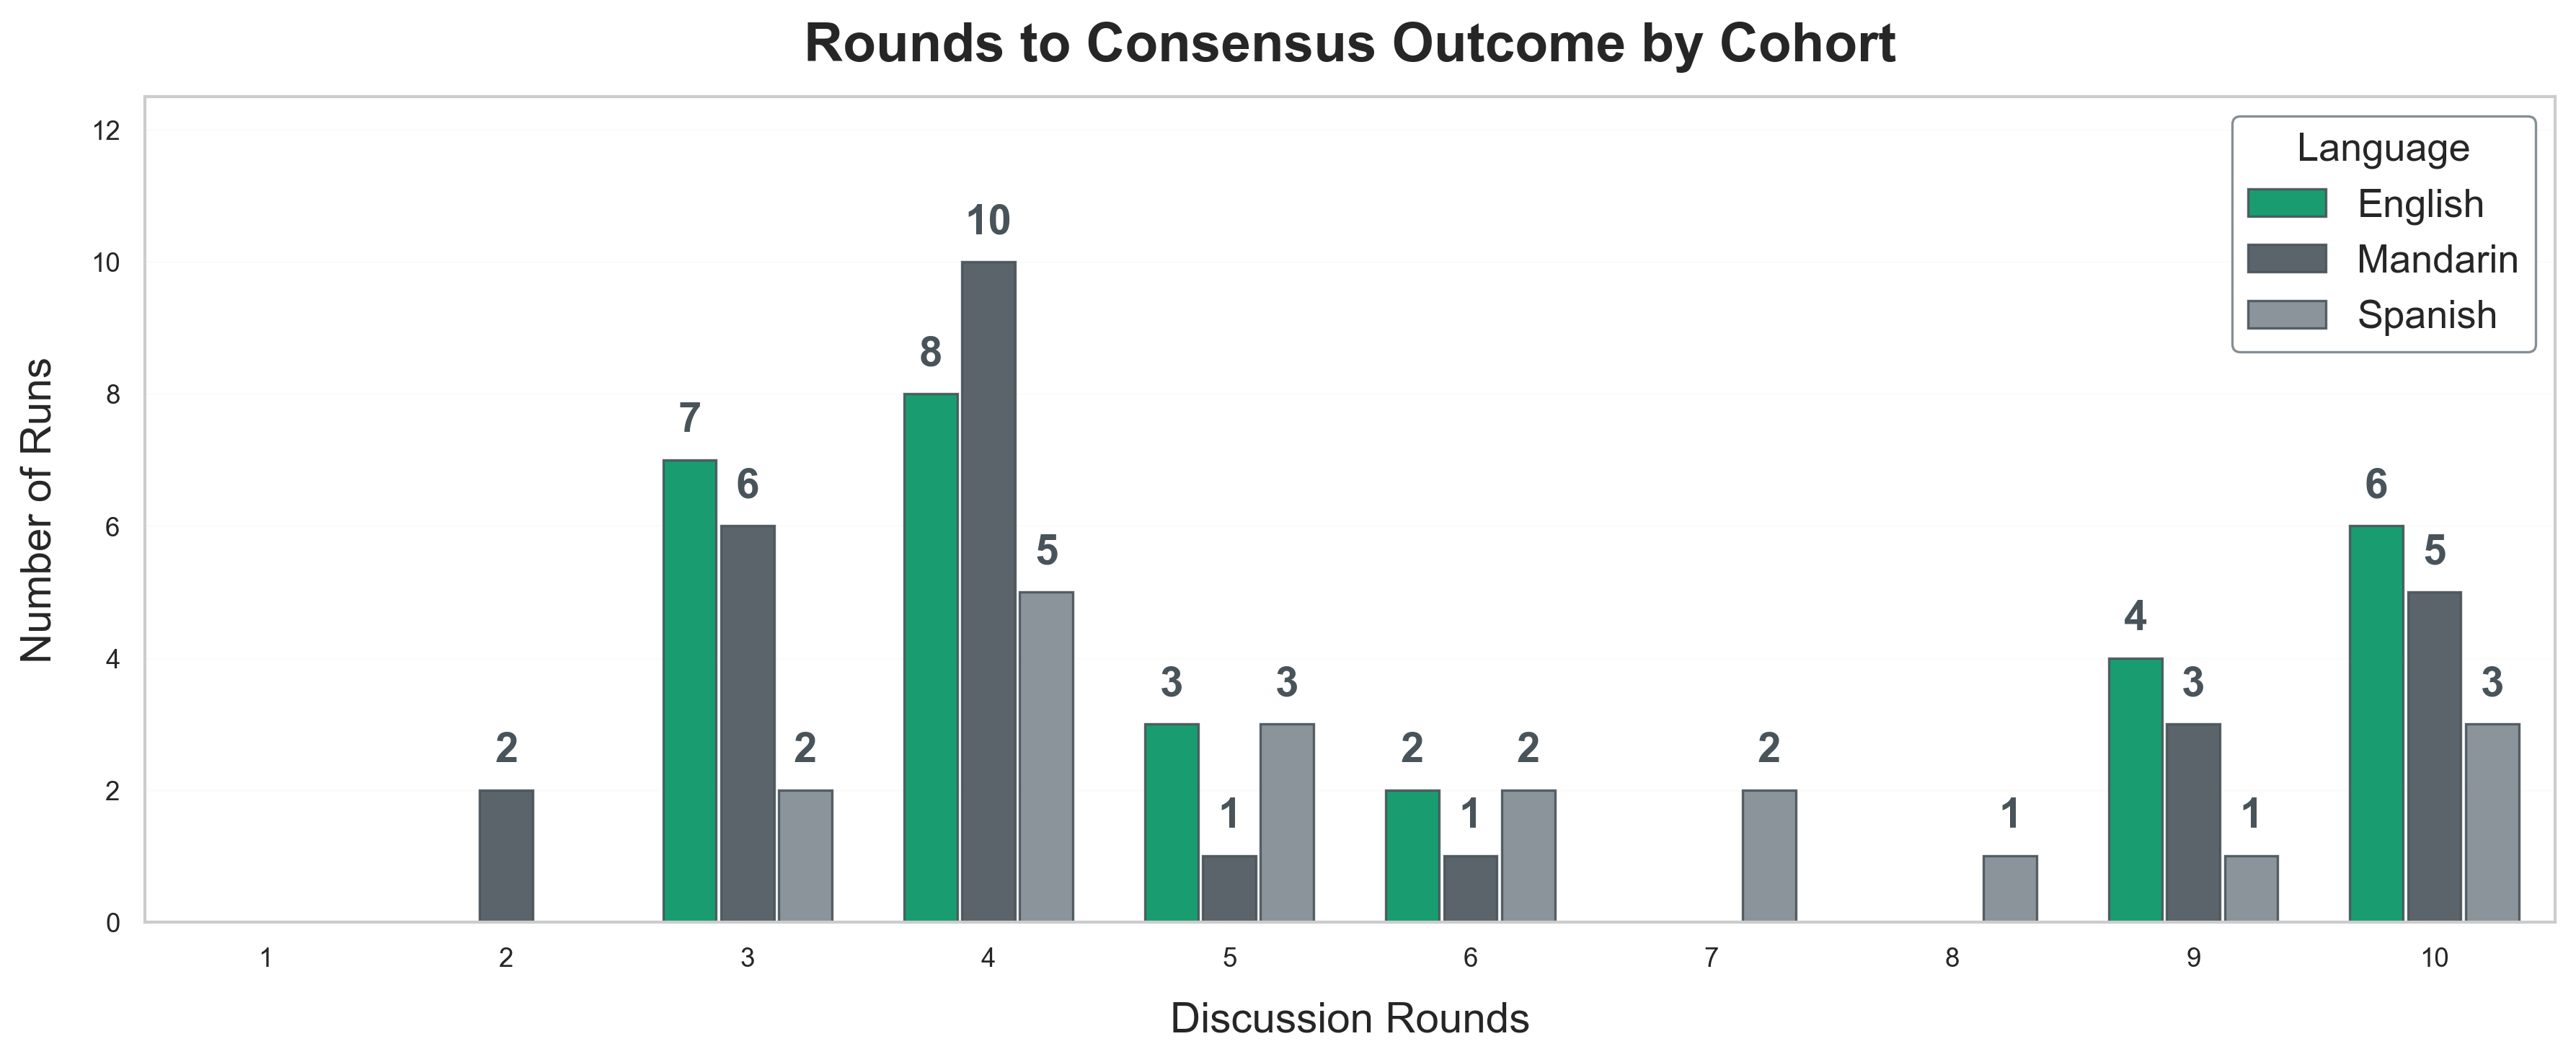

In [5]:
ordered_languages = ["English", "Mandarin", "Spanish"]
grouped_rounds_data = [
    (label, group_datasets[label].run_metrics if label in group_datasets else None)
    for label in ordered_languages
]

plot_rounds_to_outcome_grouped(
    grouped_rounds_data,
    language_order=ordered_languages,
    font_scale=1.3,
    annotation_fontsize=14,
)


In [6]:

# Cohort-level overview table

overview_records: List[Dict[str, Any]] = []

for label, dataset in group_datasets.items():
    run_metrics = dataset.run_metrics
    consensus_runs = run_metrics[run_metrics["consensus_reached"] == True]
    rounds = consensus_runs["rounds_to_outcome"].dropna()
    overview_records.append({
        "Cohort": label,
        "Runs": run_metrics.shape[0],
        "Consensus Runs": consensus_runs.shape[0],
        "Consensus Rate": consensus_runs.shape[0] / run_metrics.shape[0] if run_metrics.shape[0] else np.nan,
        "Mean Rounds": rounds.mean() if not rounds.empty else np.nan,
        "Median Rounds": rounds.median() if not rounds.empty else np.nan,
    })

overview_df = pd.DataFrame(overview_records)
overview_df["Consensus Rate"] = (overview_df["Consensus Rate"] * 100).round(1)
overview_df["Mean Rounds"] = overview_df["Mean Rounds"].round(2)
overview_df["Median Rounds"] = overview_df["Median Rounds"].round(1)

display(Markdown("### High-Level Cohort Overview"))
display(overview_df)


### High-Level Cohort Overview

Cohort  Runs  Consensus Runs  Consensus Rate  Mean Rounds  Median Rounds
0   English    34              30            88.2         5.87            4.5
1   Spanish    34              19            55.9         6.00            5.0
2  Mandarin    34              28            82.4         5.36            4.0

## English Cohort

### Data Summary

Metric  Value
0              Runs     34
1    Consensus runs     30
2    Agent sessions    170
3  Preference waves      4

Transition coverage: 170/170 agents with full wave data


### Preference Orderings by Wave

**Wave 1 - Initial**

Preference Ordering  Count  Percentage
0  Max. Avg. + Floor > Max. Floor > Max. Avg. + R...    110        64.7
1  Max. Avg. + Floor > Max. Avg. + Range > Max. F...     22        12.9
2  Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...     15         8.8
3  Max. Avg. Income > Max. Avg. + Floor > Max. Fl...     13         7.6
4  Max. Avg. Income > Max. Avg. + Floor > Max. Av...      5         2.9
5  Max. Avg. + Range > Max. Avg. + Floor > Max. F...      2         1.2
6  Max. Floor > Max. Avg. + Floor > Max. Avg. Inc...      2         1.2
7  Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      1         0.6

**Wave 2 - Post-Explanation**

Preference Ordering  Count  Percentage
0  Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     99        58.2
1  Max. Avg. + Floor > Max. Avg. + Range > Max. F...     42        24.7
2  Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...     14         8.2
3  Max. Avg. + Floor > Max. Avg. Income > Max. Fl...      4         2.4
4  Max. Avg. + Floor > Max. Avg. + Range > Max. A...      3         1.8
5  Max. Avg. Income > Max. Avg. + Floor > Max. Av...      3         1.8
6  Max. Avg. + Range > Max. Avg. + Floor > Max. F...      2         1.2
7  Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      2         1.2
8  Max. Avg. + Floor > Max. Avg. Income > Max. Av...      1         0.6

**Wave 3 - Final Phase 1**

Preference Ordering  Count  Percentage
0   Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     83        48.8
1   Max. Avg. + Floor > Max. Avg. + Range > Max. F...     41        24.1
2   Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...     12         7.1
3   Max. Avg. + Floor > Max. Avg. Income > Max. Fl...     10         5.9
4   Max. Avg. + Floor > Max. Avg. + Range > Max. A...      5         2.9
5   Max. Avg. + Floor > Max. Avg. Income > Max. Av...      5         2.9
6   Max. Avg. + Range > Max. Avg. + Floor > Max. F...      3         1.8
7   Max. Avg. Income > Max. Avg. + Floor > Max. Av...      3         1.8
8   Max. Avg. Income > Max. Avg. + Floor > Max. Fl...      3         1.8
9   Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      3         1.8
10  Max. Floor > Max. Avg. + Floor > Max. Avg. Inc...      1         0.6
11  Max. Floor > Max. Avg. + Range > Max. Avg. + F...      1         0.6

**Wave 4 - Post-Group**

Preference Ordering  Count  Percentage
0   Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     69        40.6
1   Max. Avg. + Floor > Max. Avg. + Range > Max. F...     43        25.3
2   Max. Avg. + Floor > Max. Avg. Income > Max. Av...     14         8.2
3   Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...     14         8.2
4   Max. Avg. + Floor > Max. Avg. Income > Max. Fl...     12         7.1
5   Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      8         4.7
6   Max. Avg. + Floor > Max. Avg. + Range > Max. A...      3         1.8
7   Max. Avg. + Range > Max. Floor > Max. Avg. + F...      2         1.2
8   Max. Avg. Income > Max. Avg. + Floor > Max. Av...      2         1.2
9   Max. Avg. + Range > Max. Floor > Max. Avg. Inc...      1         0.6
10  Max. Avg. Income > Max. Floor > Max. Avg. + Fl...      1         0.6
11  Max. Floor > Max. Avg. + Range > Max. Avg. + F...      1         0.6

### Rounds to Outcome

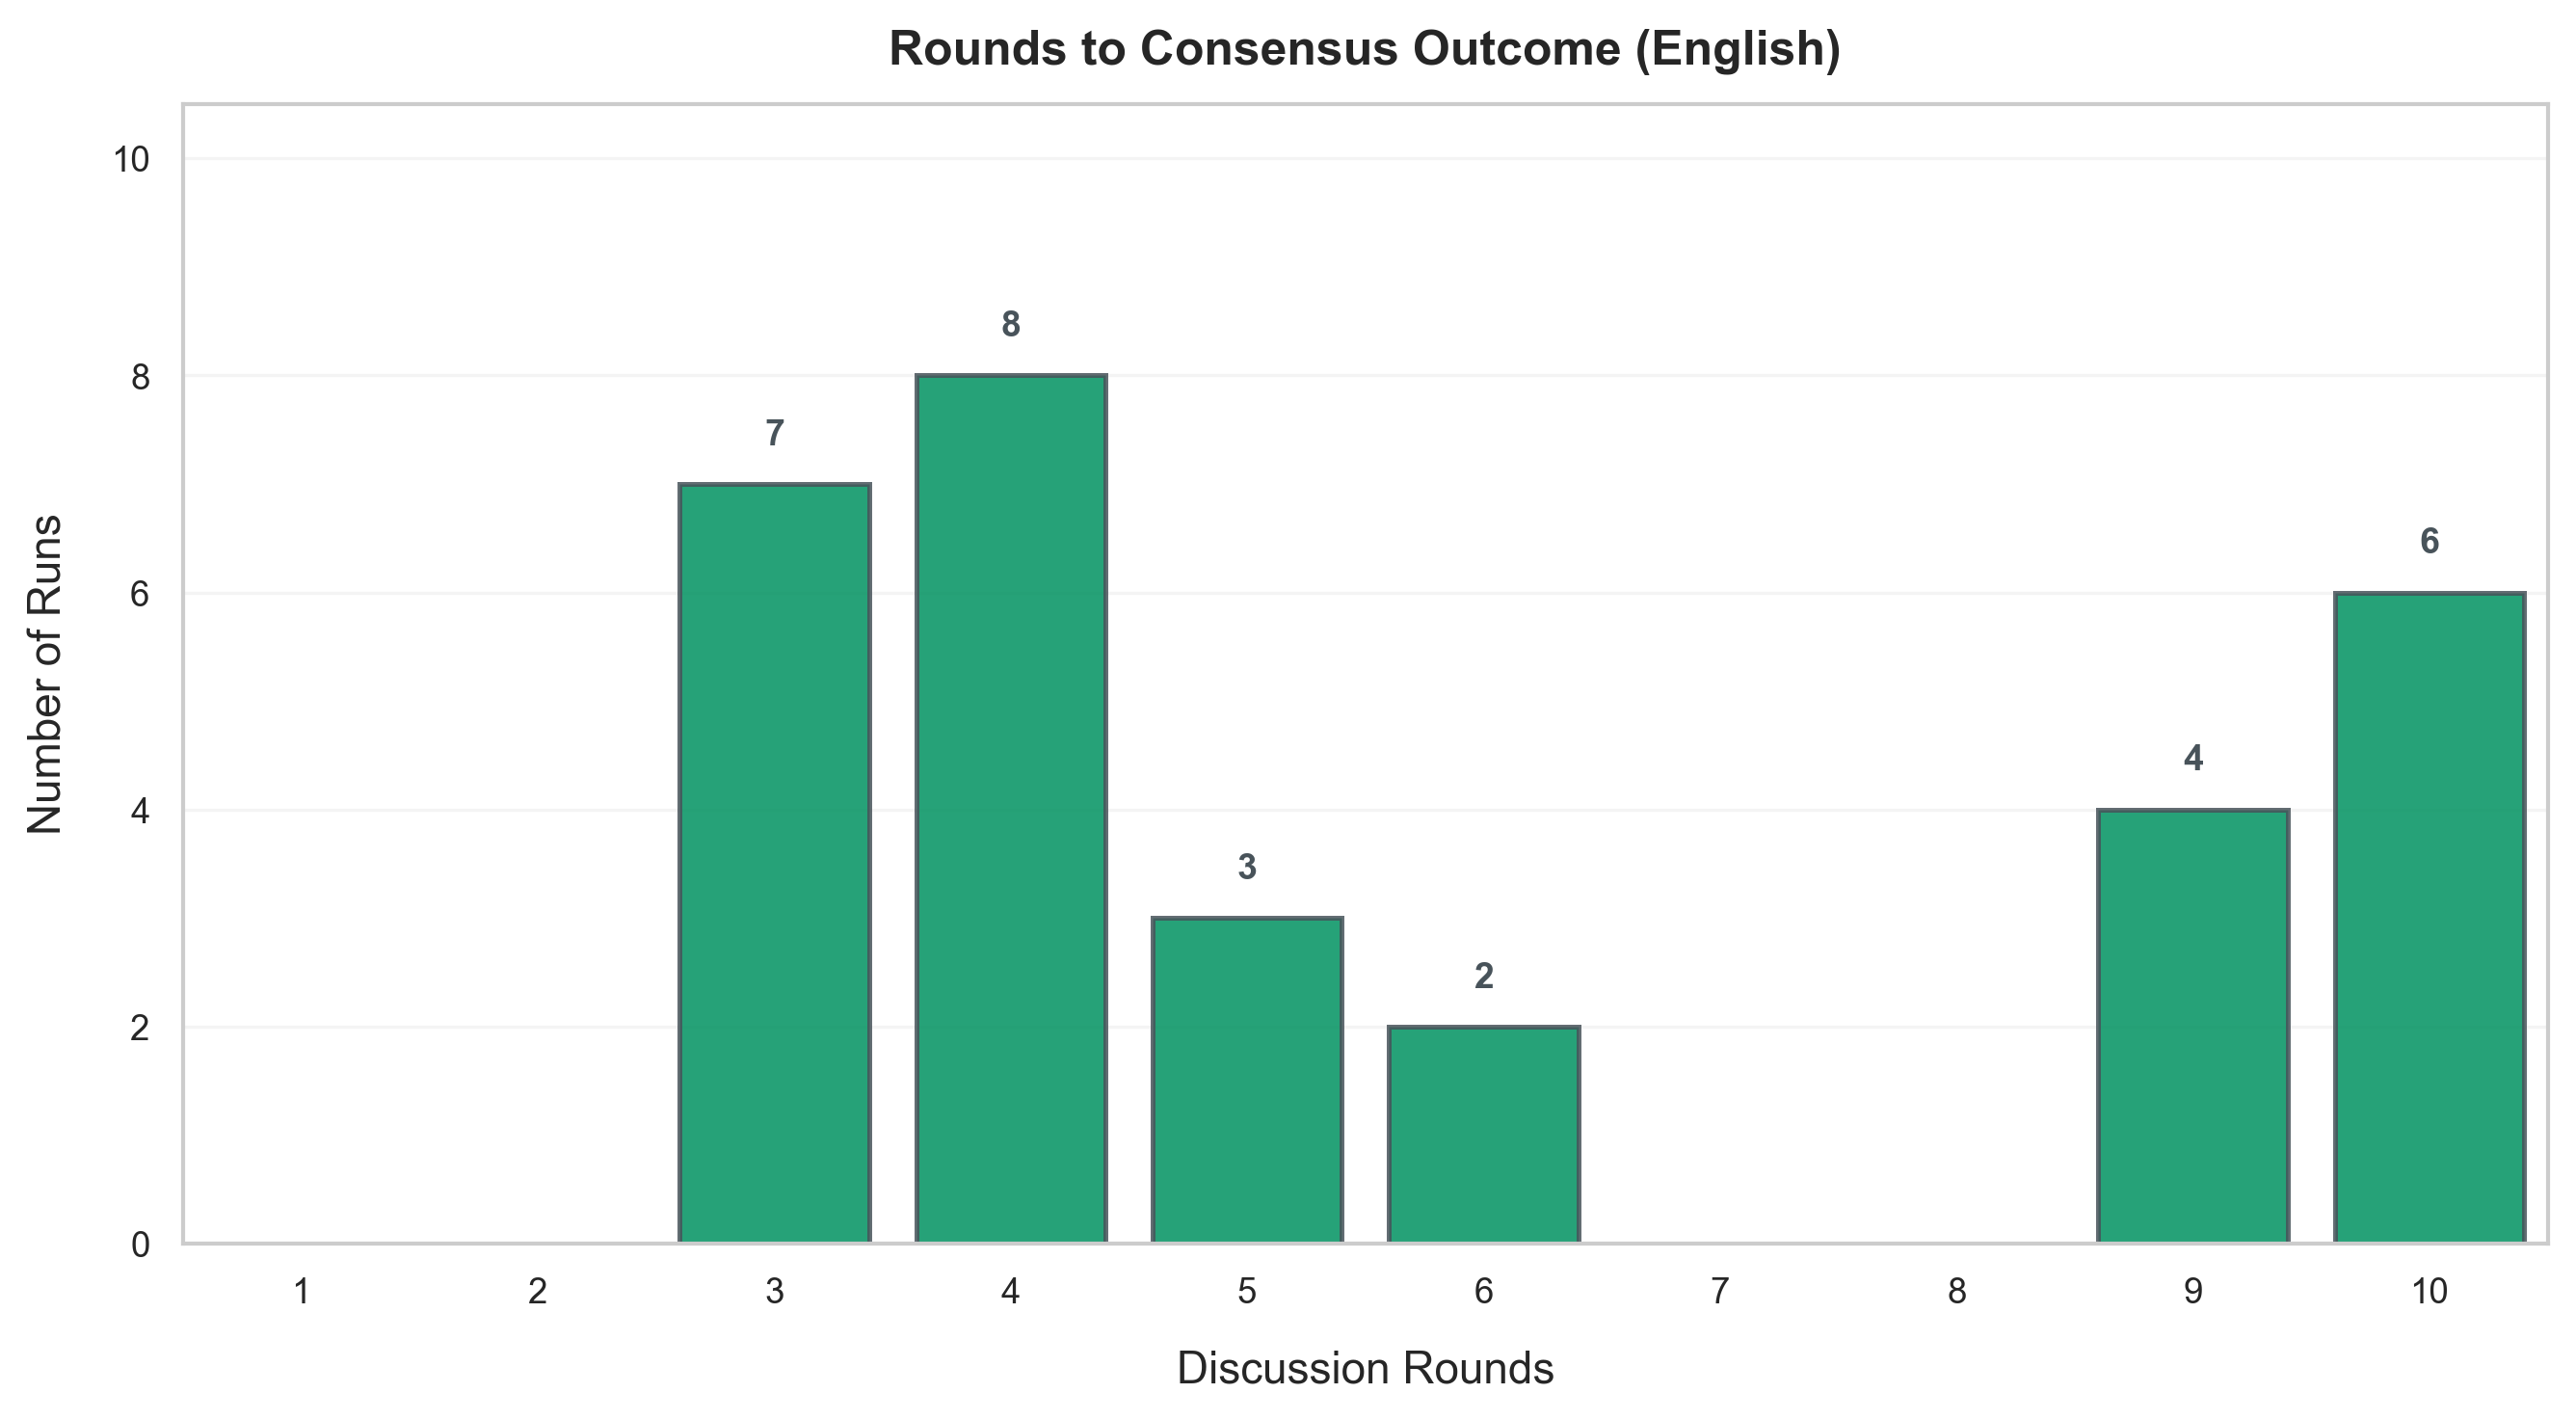

Consensus Timing Summary:
  Total consensus runs: 30
  Range: 3-10 rounds
  Mean: 5.87 rounds  |  Median: 4 rounds


### Floor Constraint Amounts

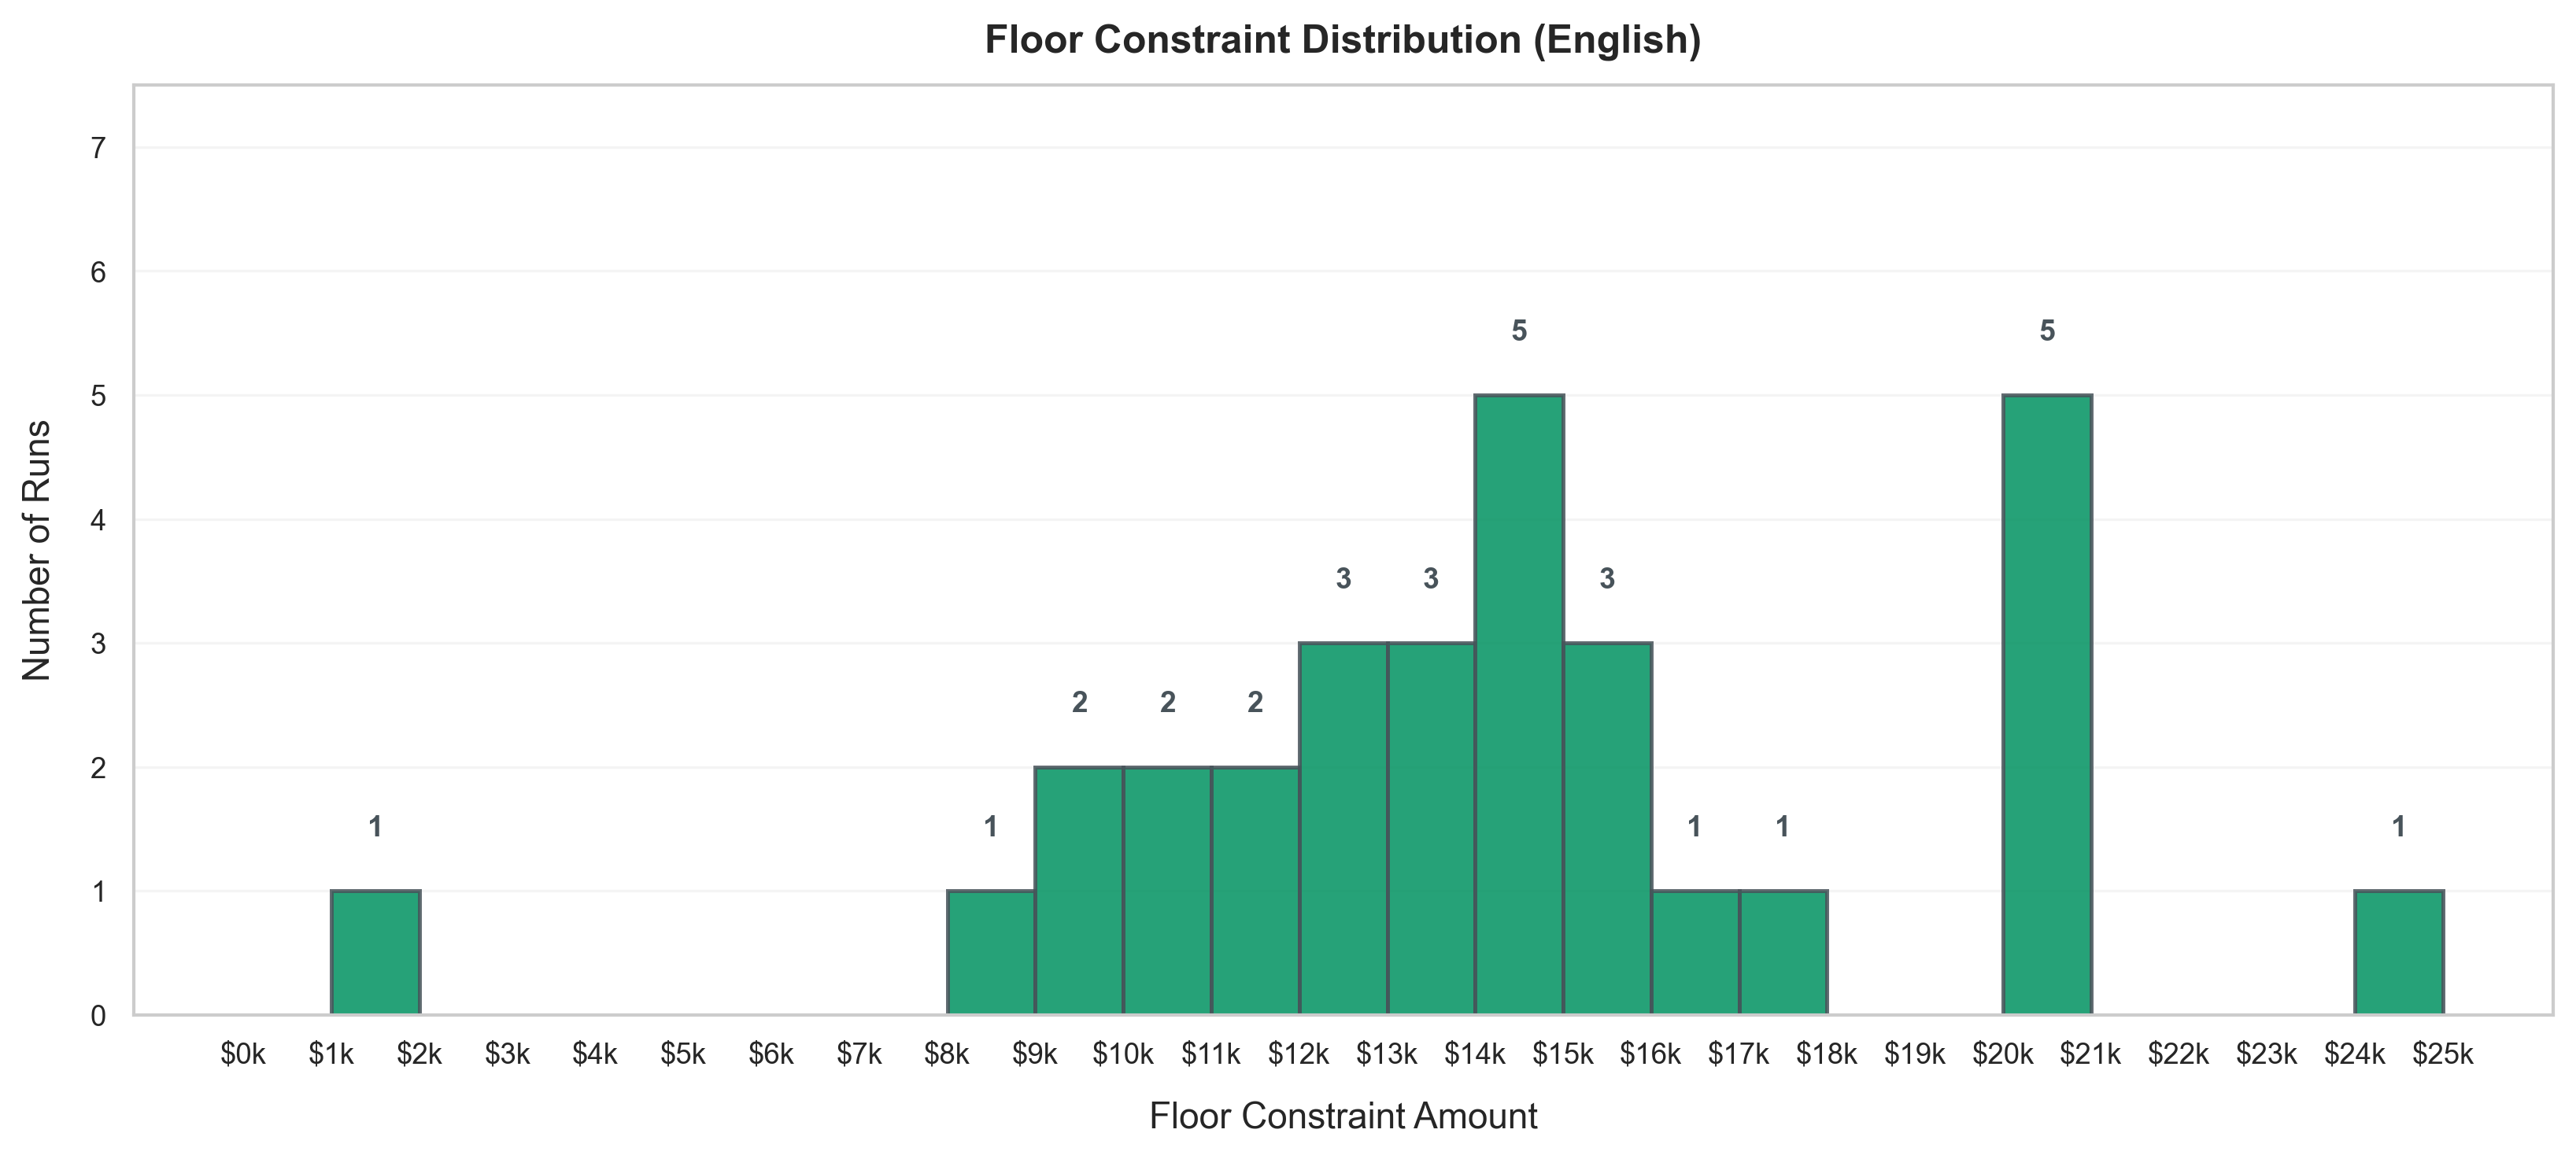

Floor Amount Summary:
  Total votes: 30
  Range: $1,000 - $25,000
  Mean: $14,017  |  Median: $14,000  |  SD: $4,574


### Voting Attempts and Success Rate

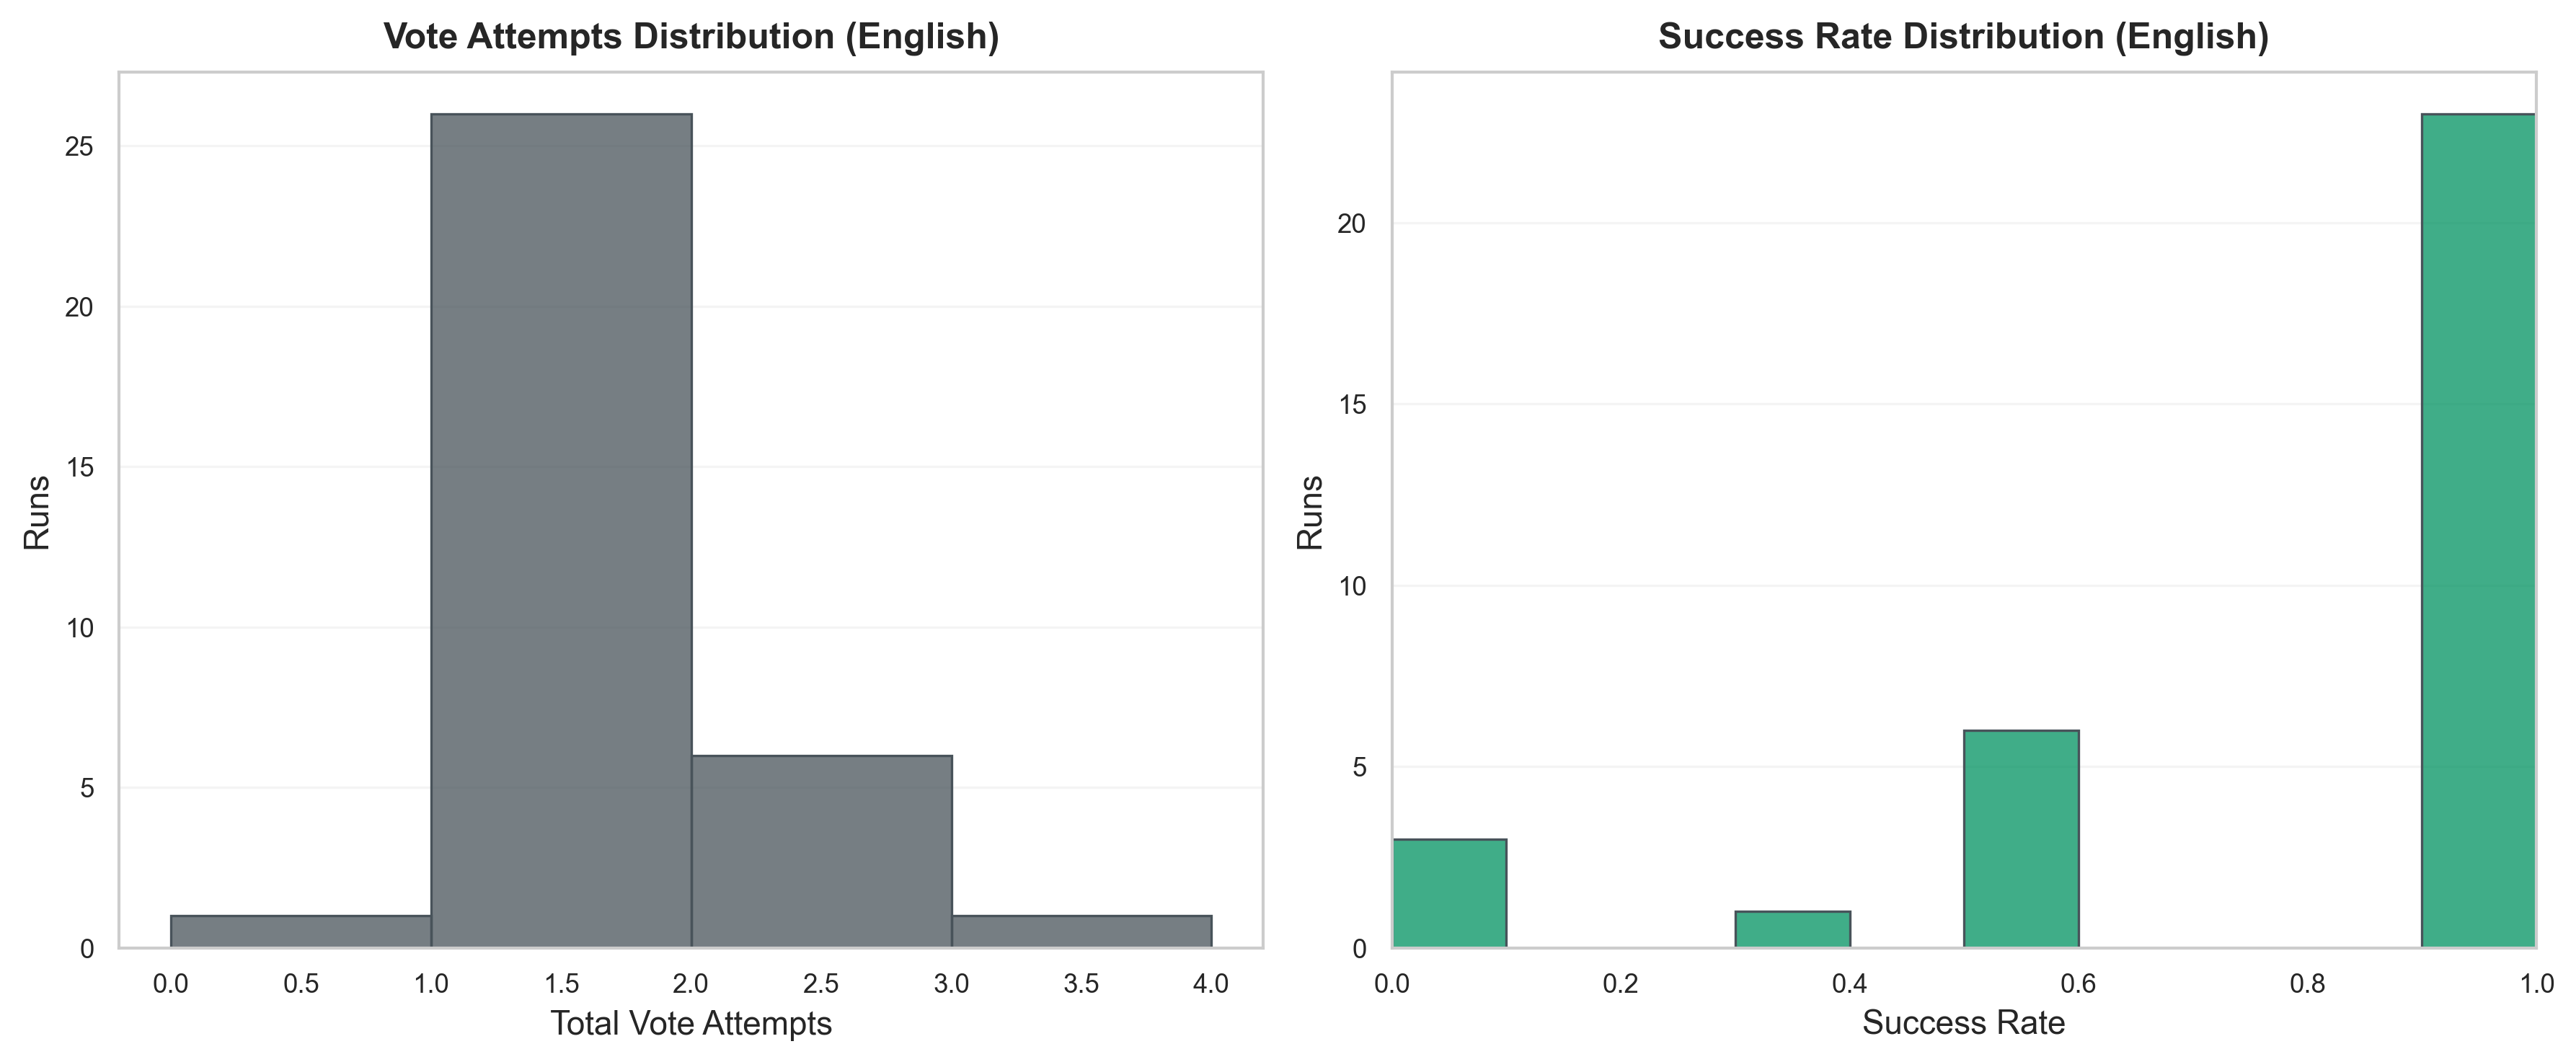

Voting Attempts Summary:
  Mean attempts per run: 1.21
  Median attempts per run: 1
  Mean success rate: 79.80%
  Median success rate: 100.00%


### Preference Evolution and Transitions

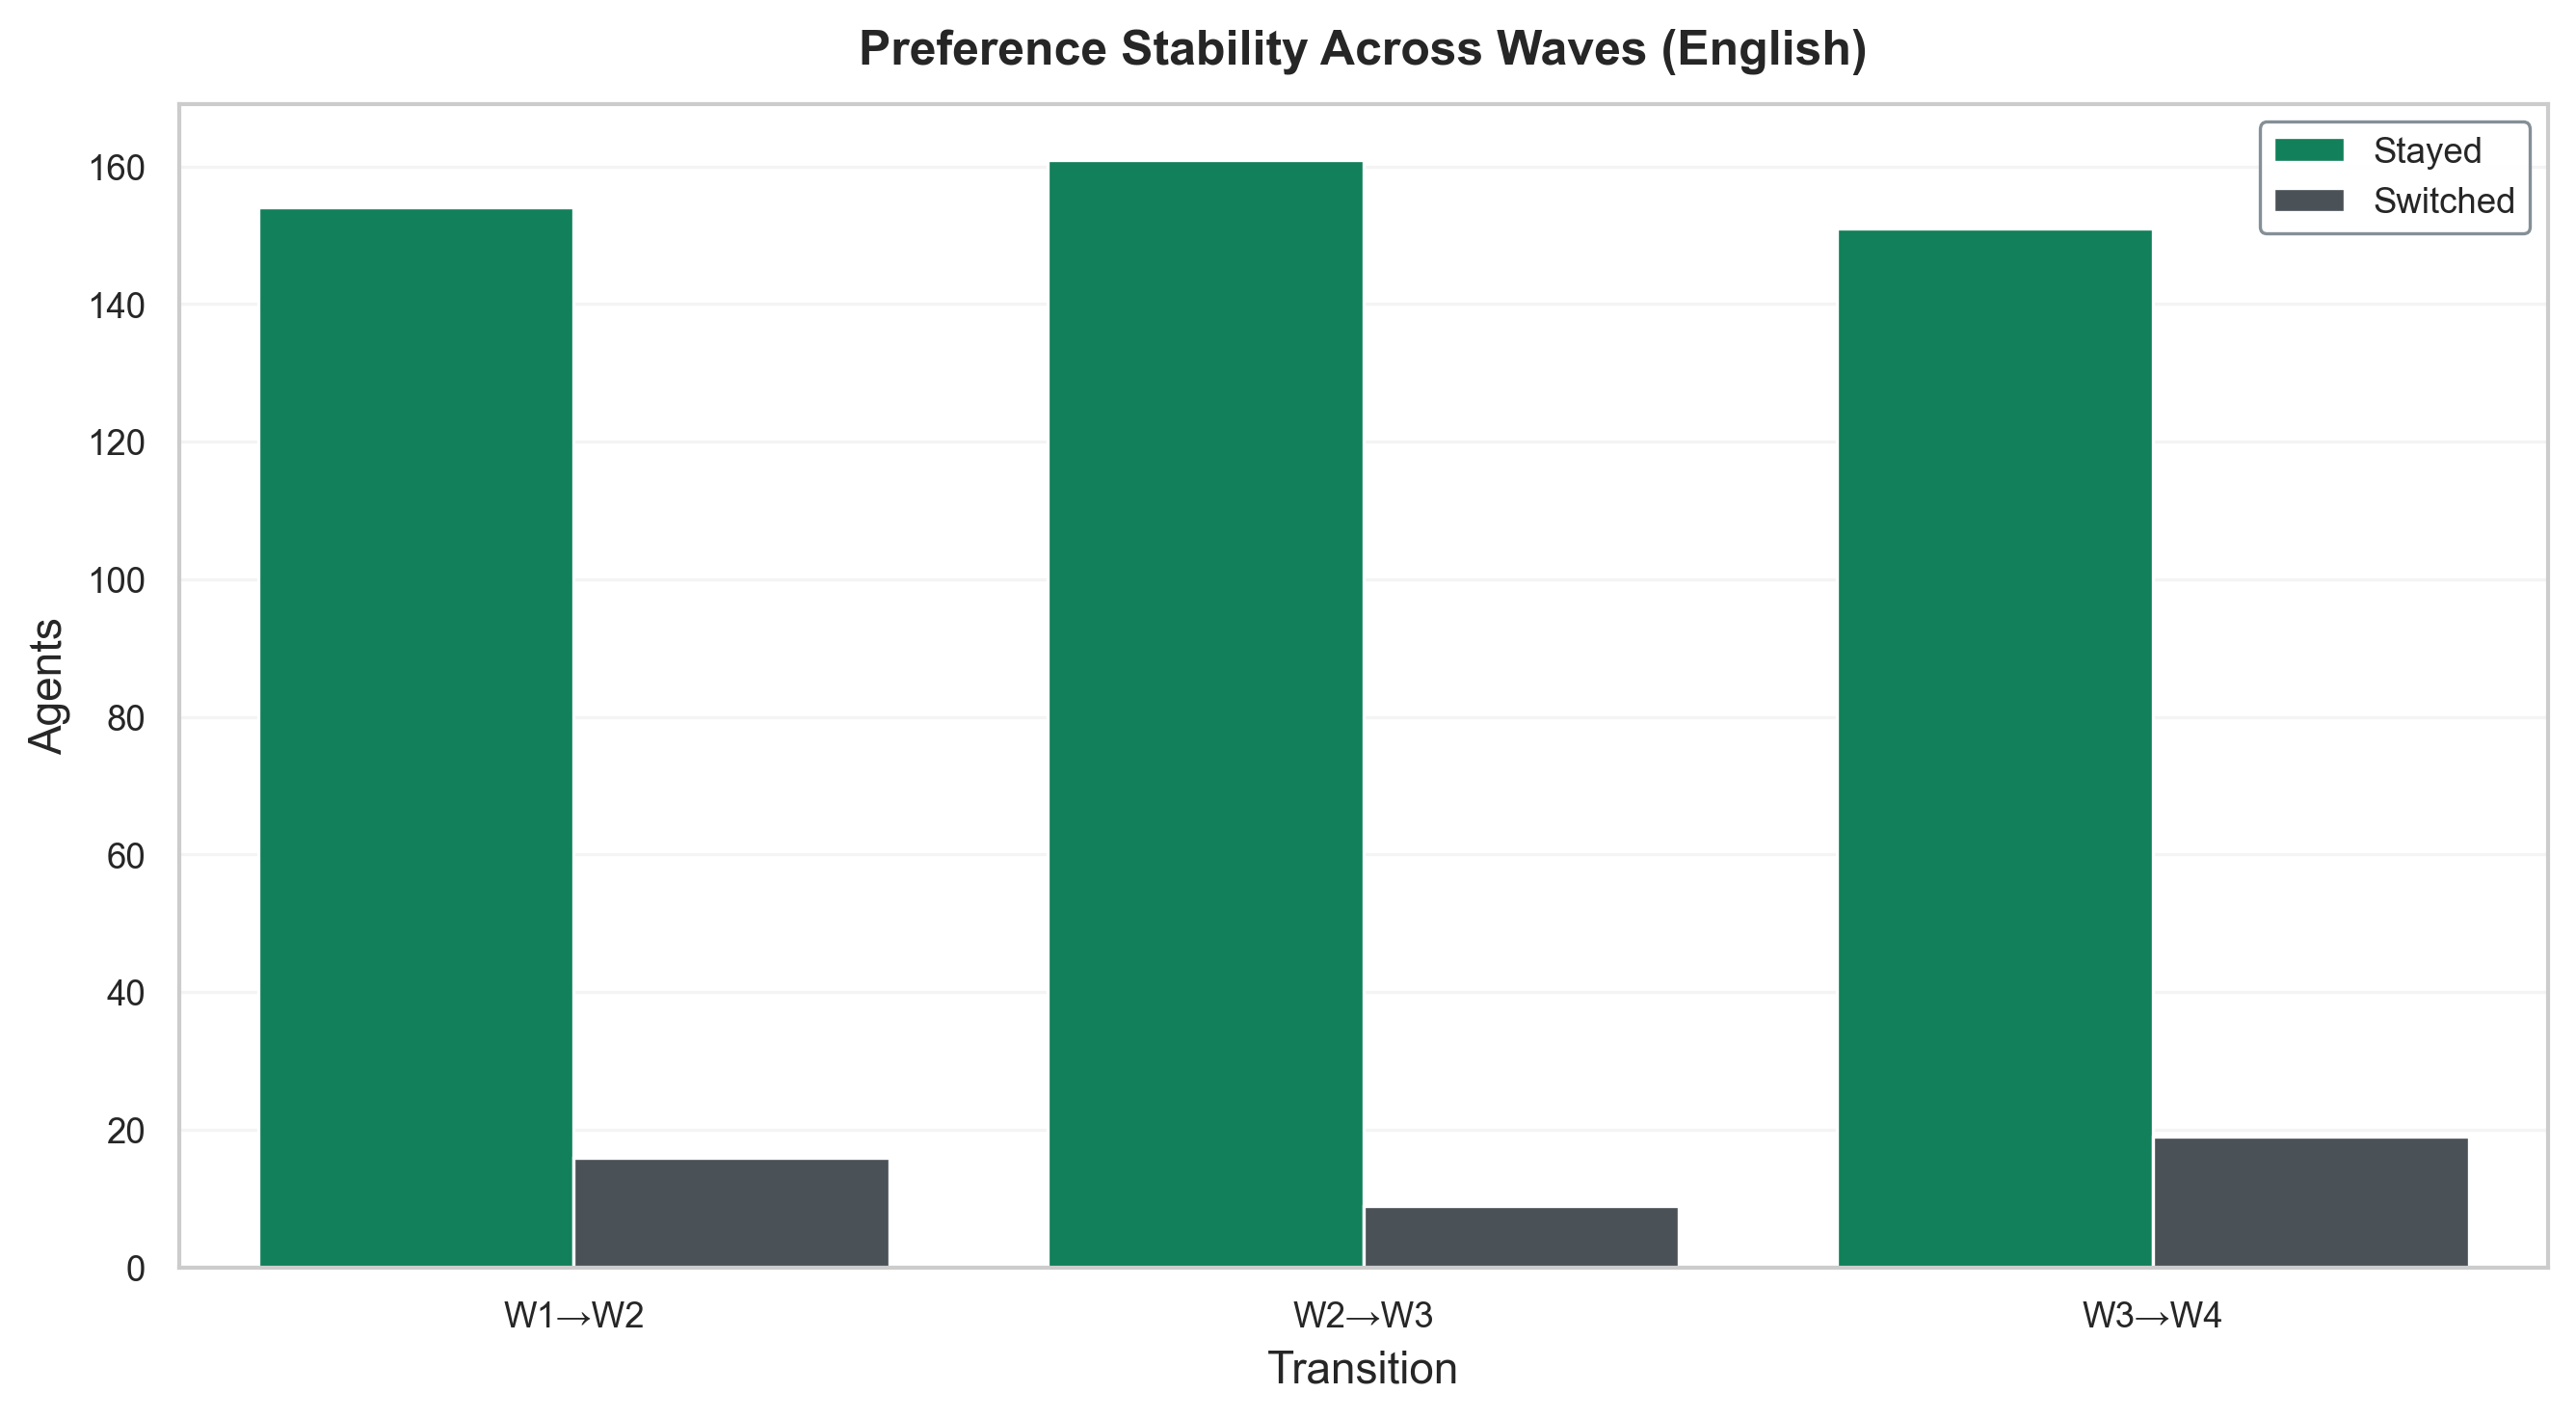

Stability Breakdown:
  W1→W2: 154/170 stayed (90.6%)
  W2→W3: 161/170 stayed (94.7%)
  W3→W4: 151/170 stayed (88.8%)


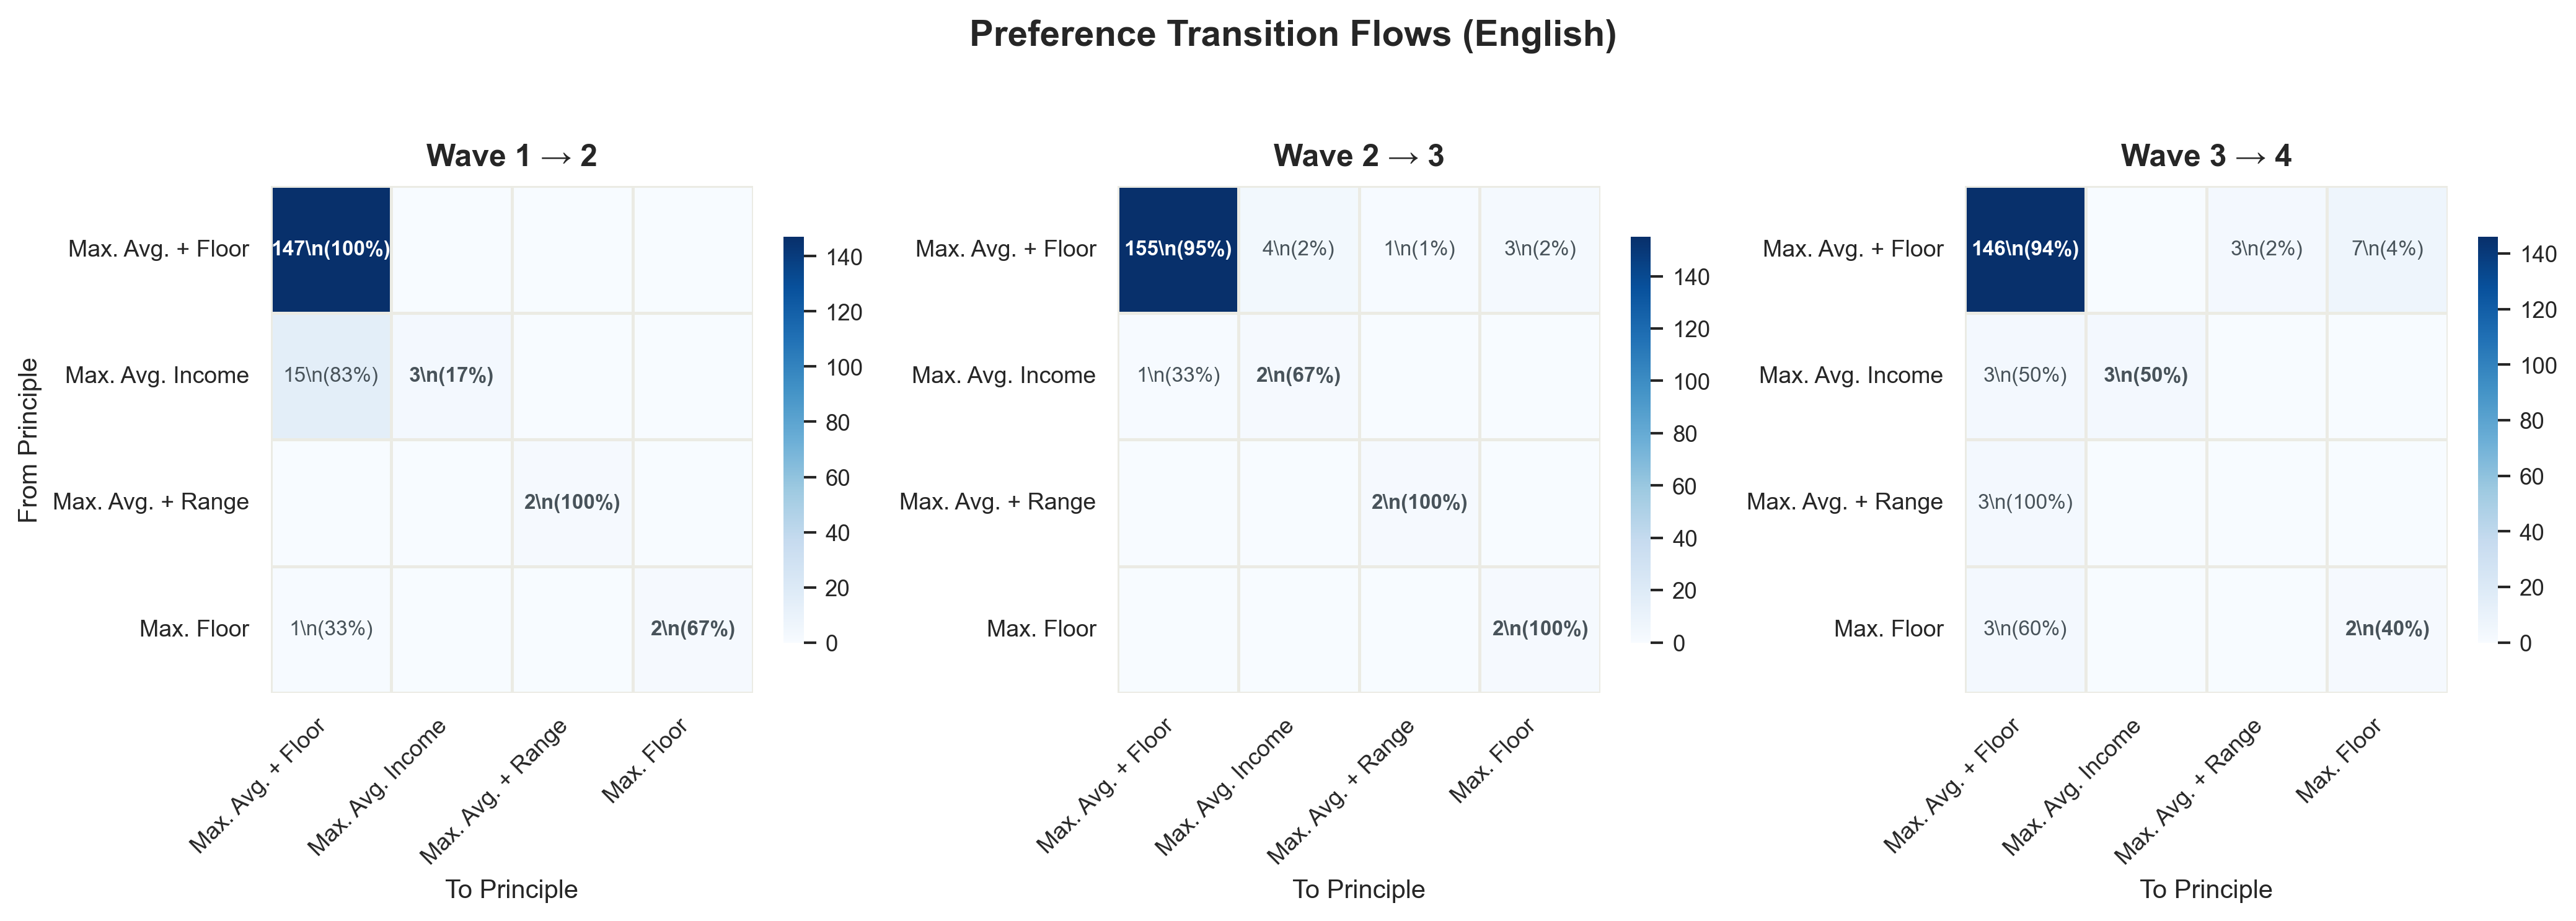

Transition Stay Rates:
  Wave 1 → 2: 154/170 stayed (90.6%)
  Wave 2 → 3: 161/170 stayed (94.7%)
  Wave 3 → 4: 151/170 stayed (88.8%)


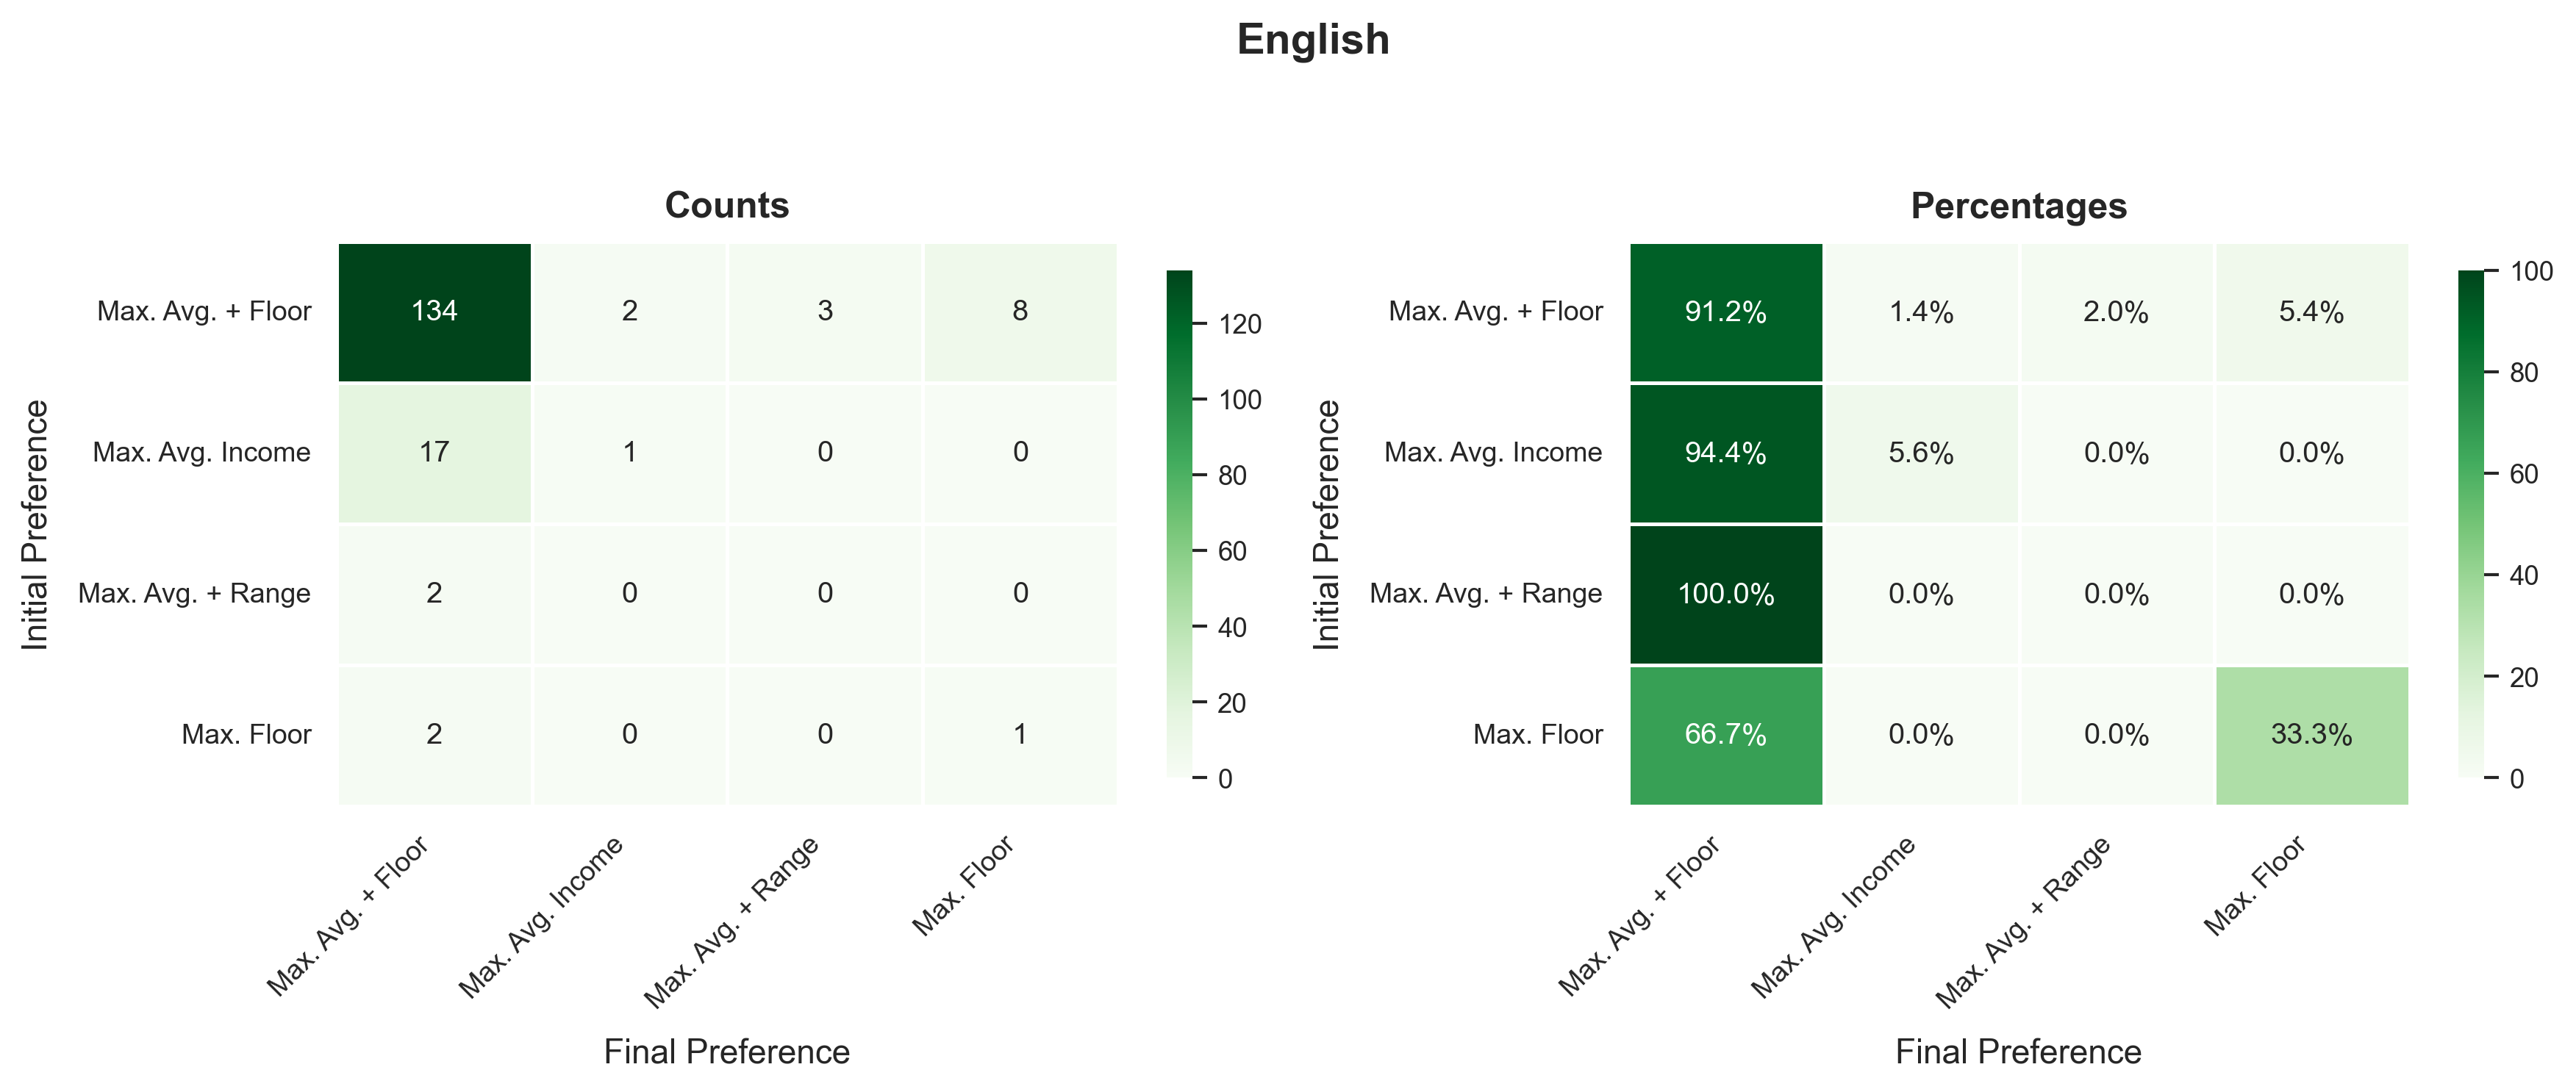

Long-Term Stability (Wave 1 → Wave 4) [English]
Max. Avg. + Floor        : 134/147 maintained ( 91.2%)
Max. Avg. Income         :   1/ 18 maintained (  5.6%)
Max. Avg. + Range        :   0/  2 maintained (  0.0%)
Max. Floor               :   1/  3 maintained ( 33.3%)
OVERALL                  : 136/170 agents ( 80.0%)


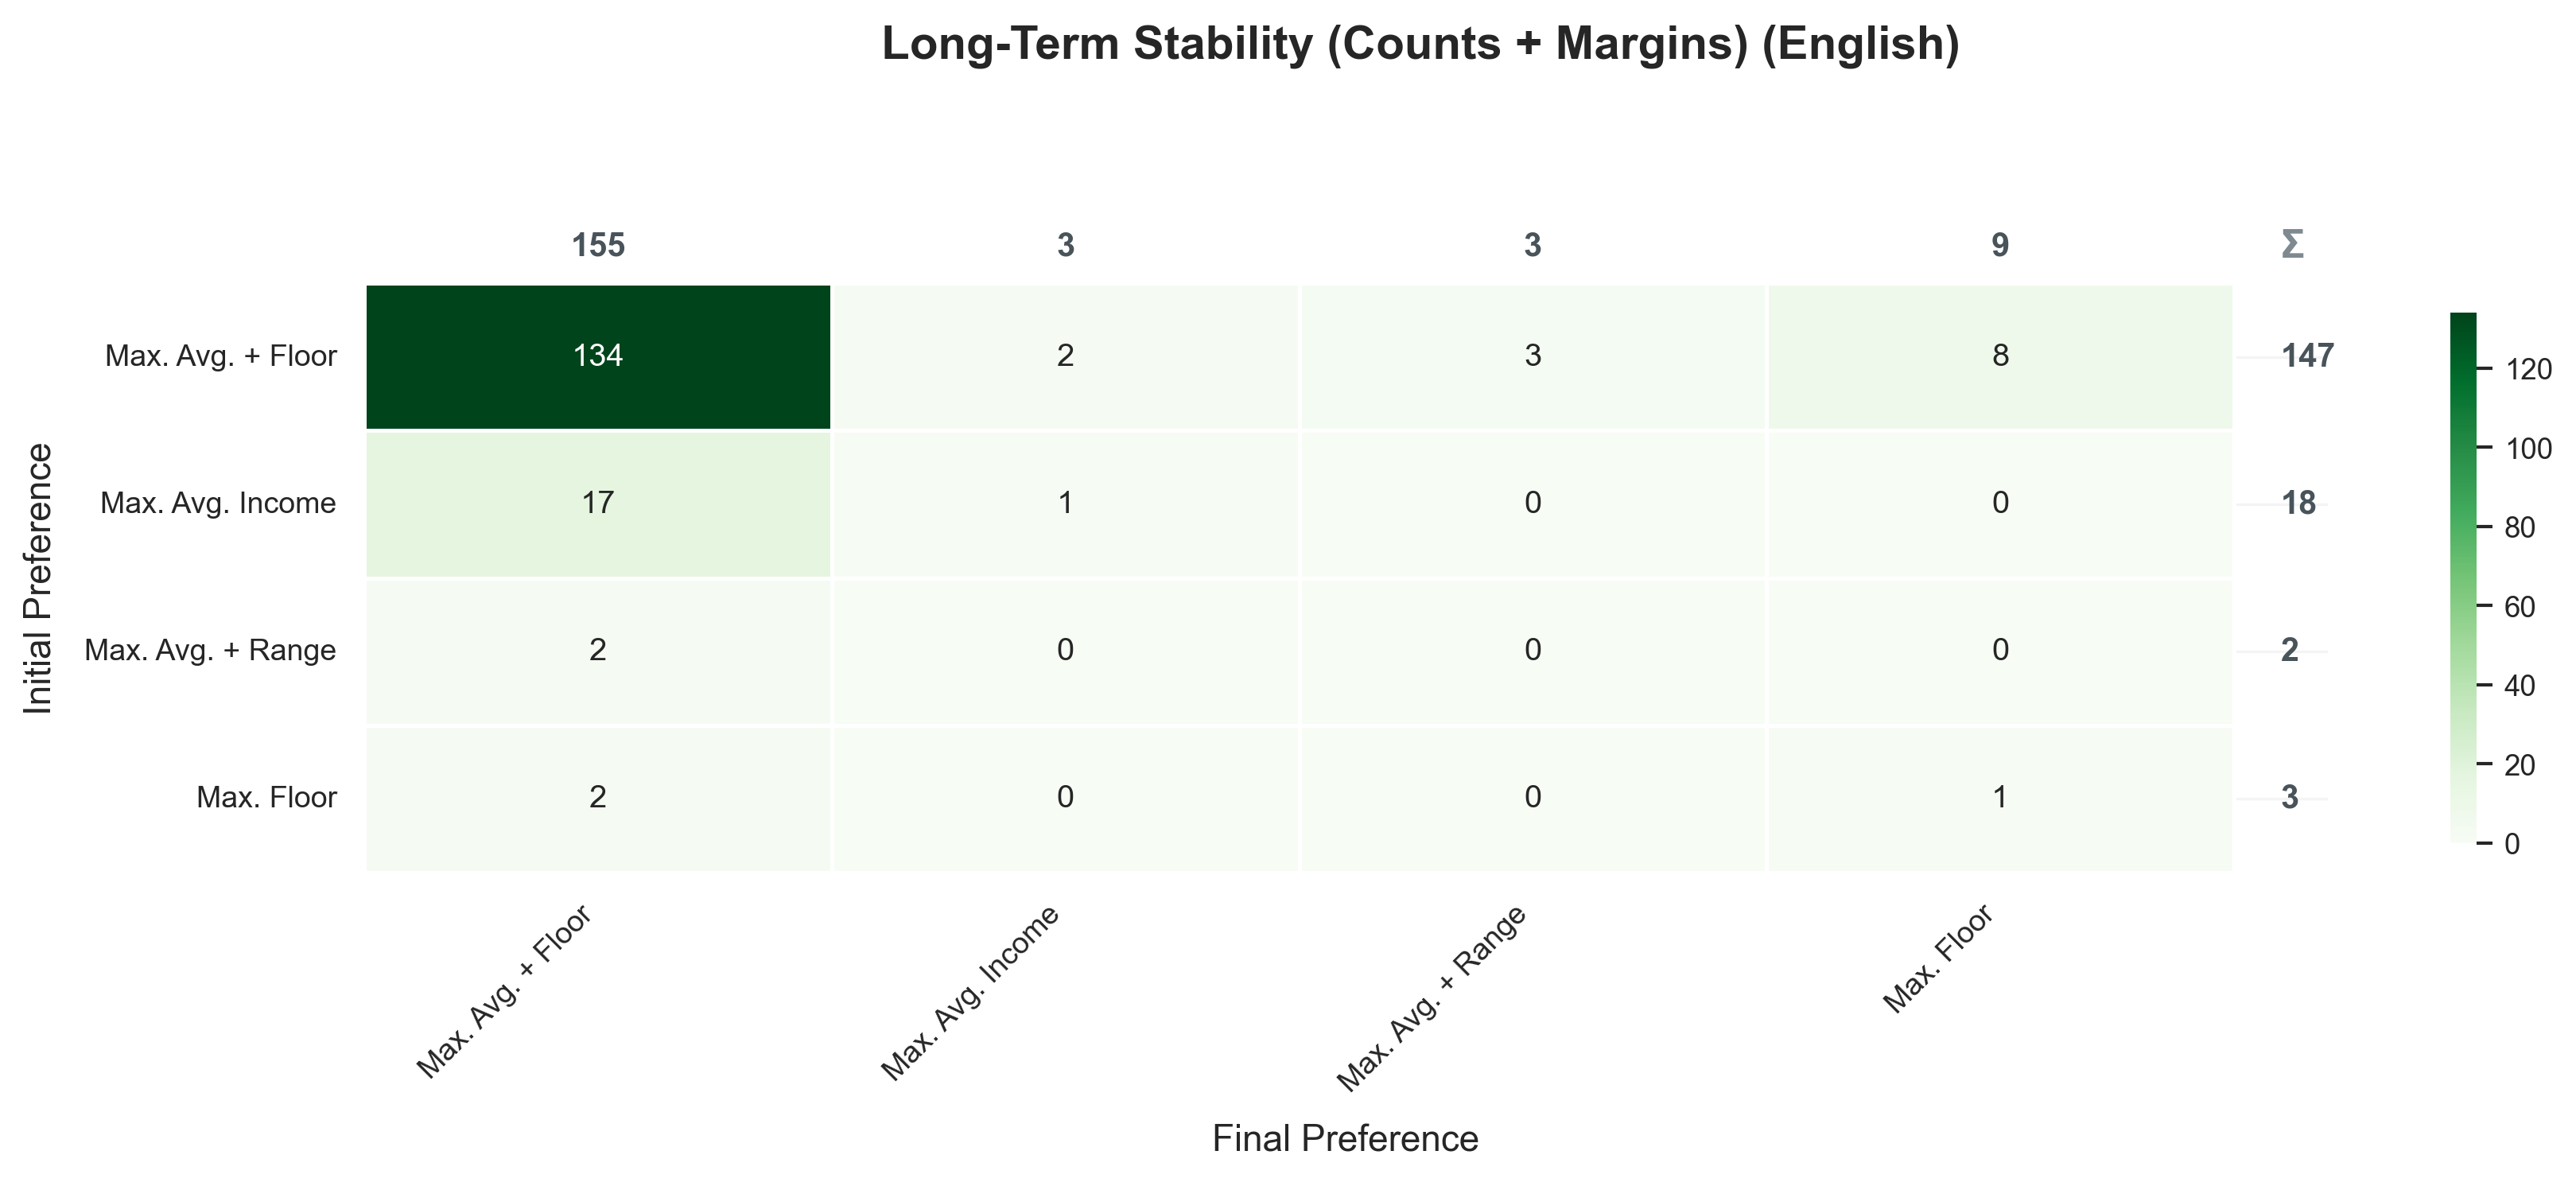

### Switcher Analysis: Income Class and Preference Changes

/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_34034/2101704904.py:358: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_long.pivot_table(


Income Class  Changed Preference  Maintained Preference  Total Agents  \
0          Low                   6                     10            16   
1       Medium                  19                     66            85   
2         High                   1                      7             8   
3      Unknown                  13                     48            61   

   Changed Share (%)  Maintained Share (%)  
0               37.5                  62.5  
1               22.4                  77.6  
2               12.5                  87.5  
3               21.3                  78.7

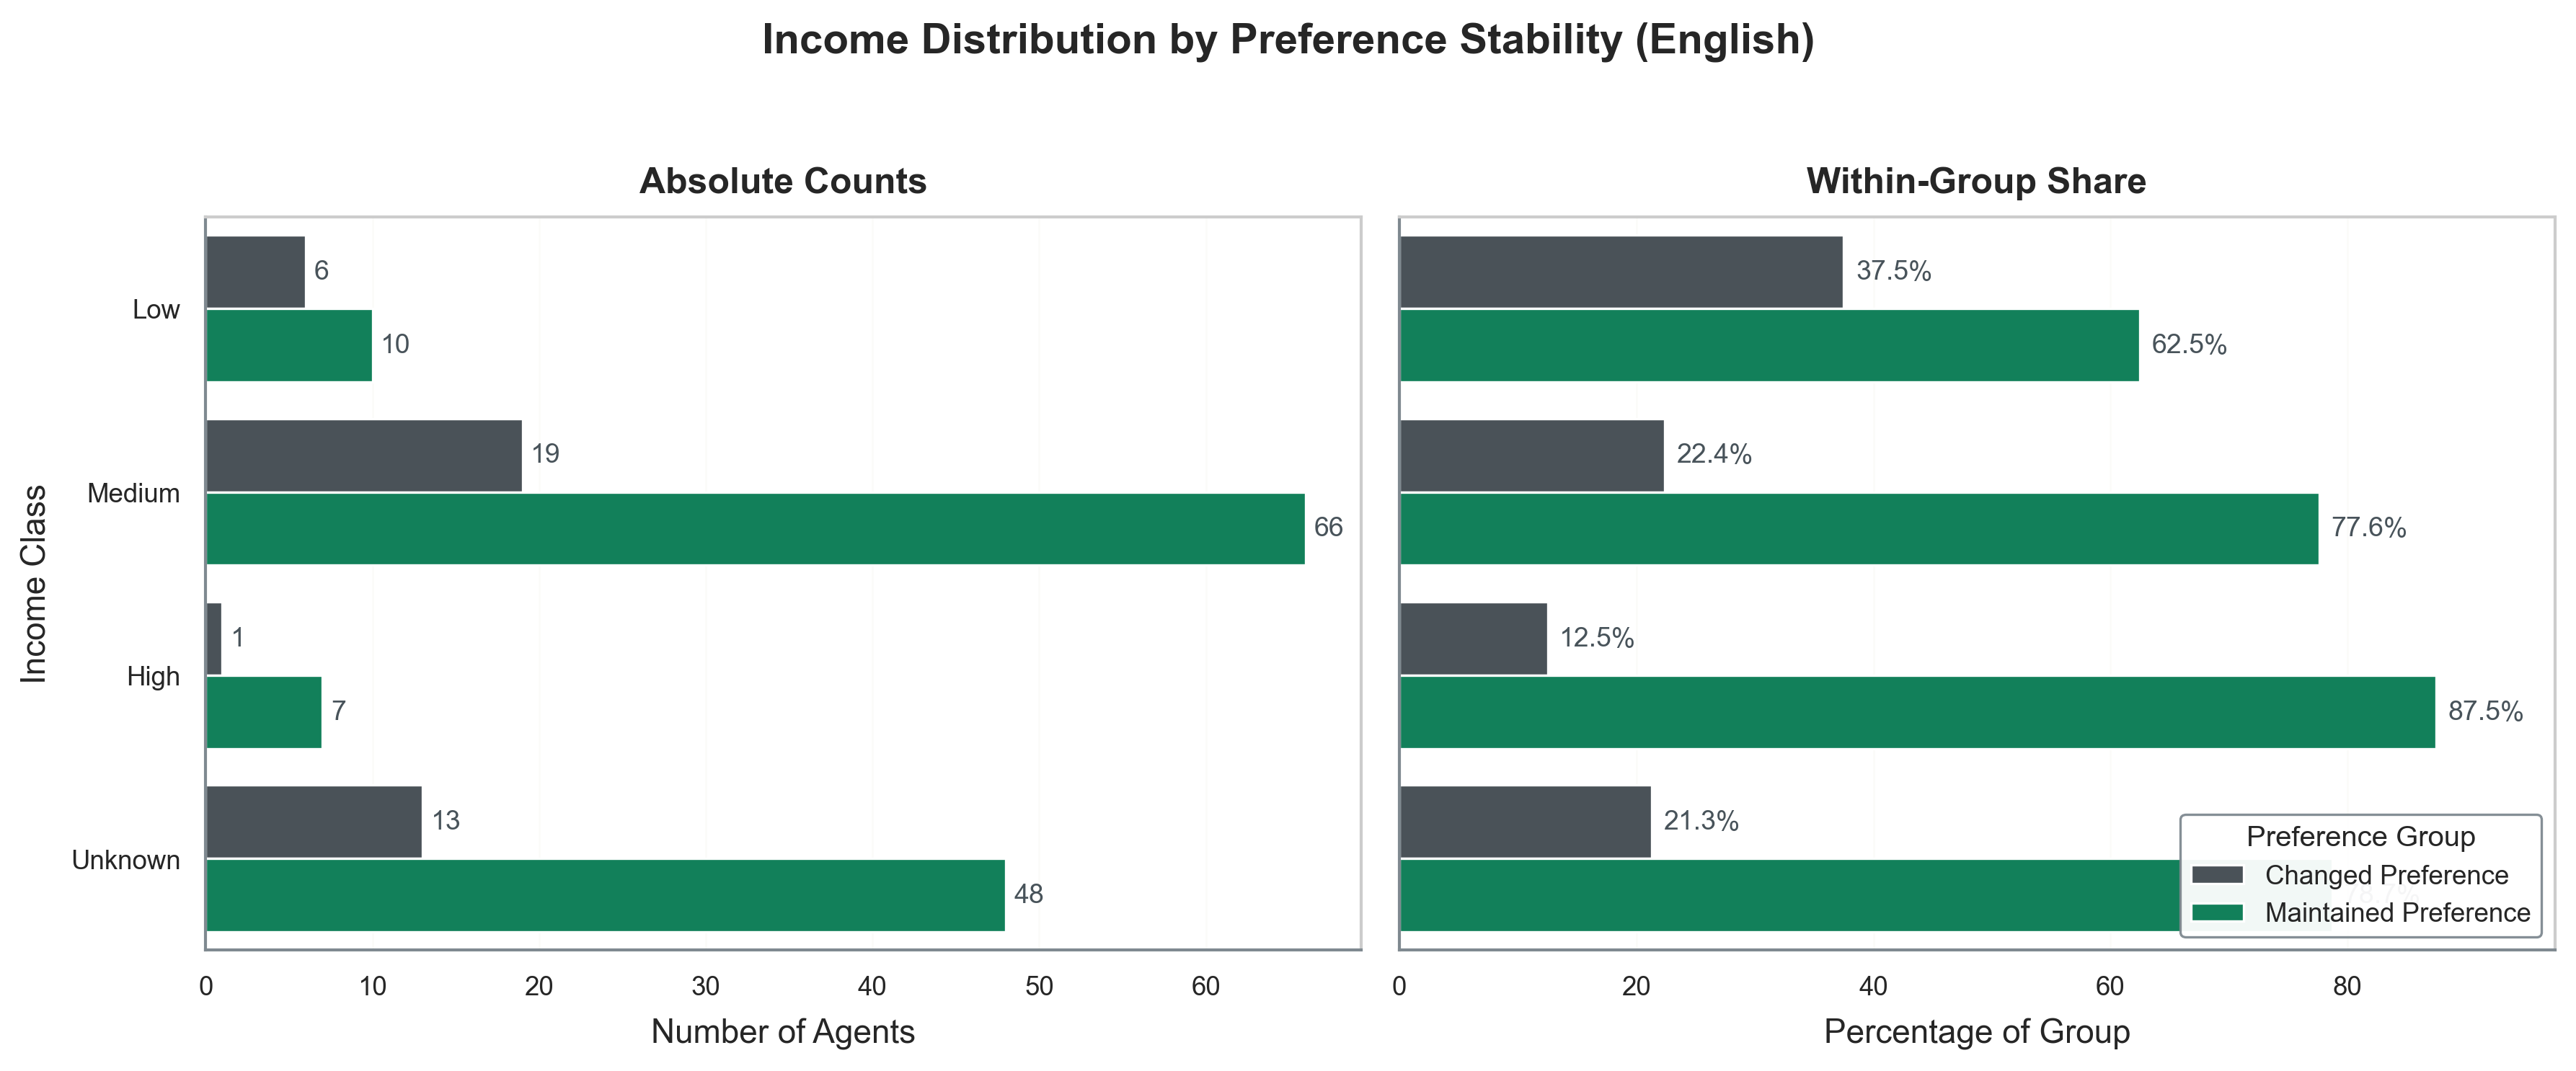

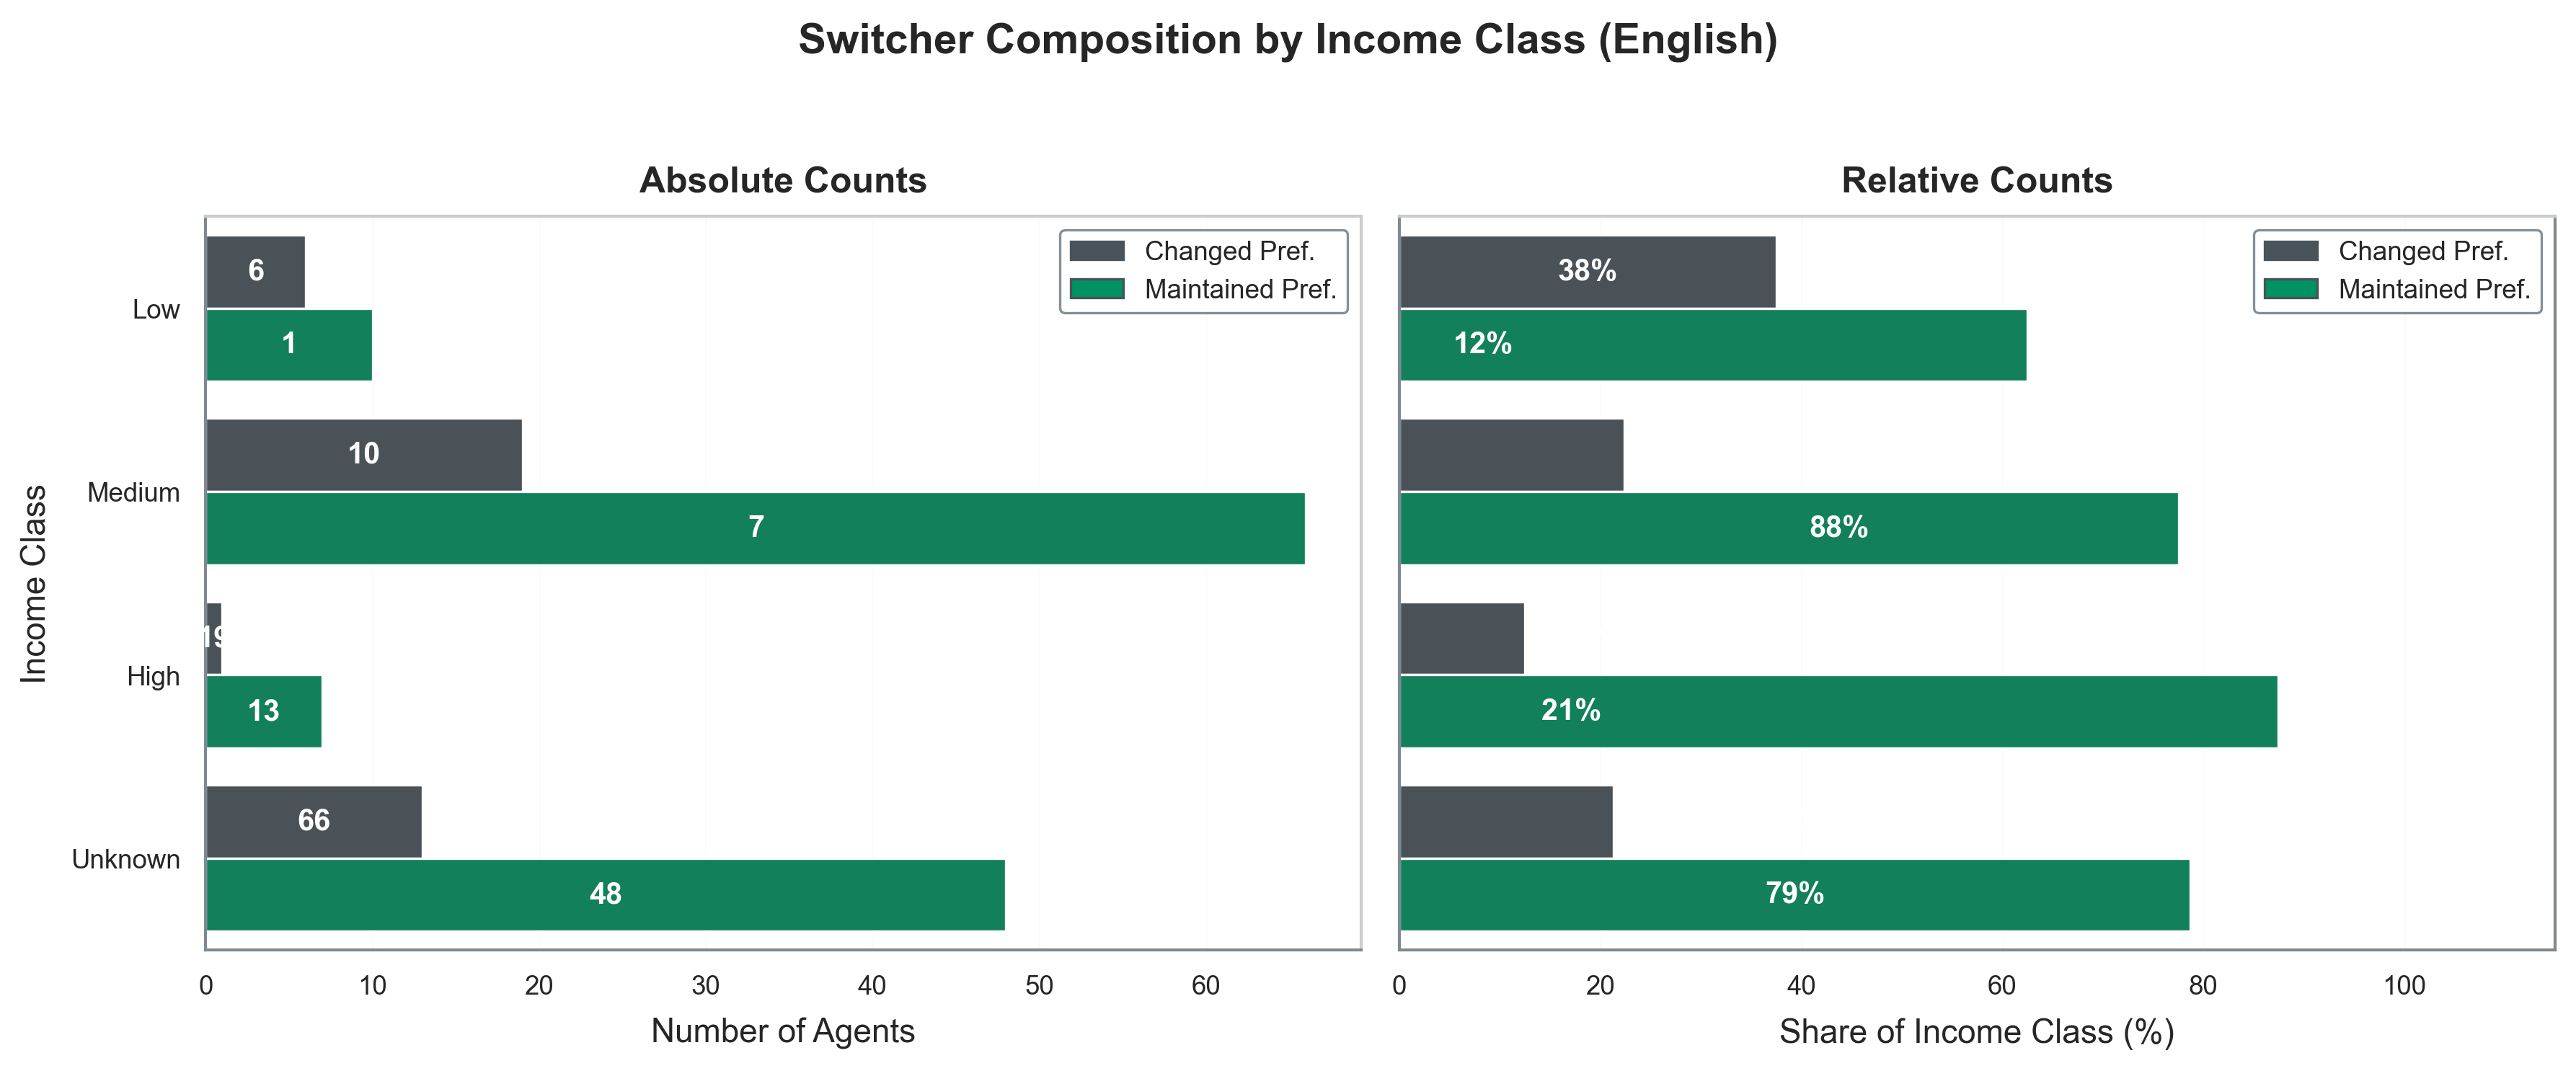

## Spanish Cohort

### Data Summary

Metric  Value
0              Runs     34
1    Consensus runs     19
2    Agent sessions    170
3  Preference waves      4

Transition coverage: 170/170 agents with full wave data


### Preference Orderings by Wave

**Wave 1 - Initial**

Preference Ordering  Count  Percentage
0   Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     65        38.2
1   Max. Avg. + Floor > Max. Avg. + Range > Max. F...     32        18.8
2   Max. Avg. + Range > Max. Floor > Max. Avg. + F...     29        17.1
3   Max. Avg. + Range > Max. Avg. + Floor > Max. F...     17        10.0
4   Max. Avg. + Range > Max. Avg. Income > Max. Fl...      6         3.5
5   Max. Avg. + Floor > Max. Avg. + Range > Max. A...      5         2.9
6   Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...      5         2.9
7   Max. Avg. + Range > Max. Floor > Max. Avg. Inc...      3         1.8
8   Max. Avg. + Range > Max. Avg. Income > Max. Av...      2         1.2
9   Max. Avg. + Range > Max. Avg. + Floor > Max. A...      1         0.6
10  Max. Avg. Income > Max. Avg. + Floor > Max. Fl...      1         0.6
11  Max. Avg. Income > Max. Avg. + Range > Max. Av...      1         0.6
12  Max. Avg. Income > Max. Avg. + Range > Max. Fl...      1         0.6
13  Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      1         0.6
14  Max. Floor > Max. Avg. + Range > Max. Avg. + F...      1         0.6

**Wave 2 - Post-Explanation**

Preference Ordering  Count  Percentage
0  Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     59        34.7
1  Max. Avg. + Floor > Max. Avg. + Range > Max. F...     42        24.7
2  Max. Avg. + Range > Max. Avg. + Floor > Max. F...     26        15.3
3  Max. Avg. + Range > Max. Floor > Max. Avg. + F...     21        12.4
4  Max. Avg. + Floor > Max. Avg. + Range > Max. A...      7         4.1
5  Max. Avg. + Range > Max. Avg. + Floor > Max. A...      5         2.9
6  Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...      4         2.4
7  Max. Avg. + Range > Max. Avg. Income > Max. Fl...      4         2.4
8  Max. Avg. + Range > Max. Floor > Max. Avg. Inc...      2         1.2

**Wave 3 - Final Phase 1**

Preference Ordering  Count  Percentage
0   Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     52        30.6
1   Max. Avg. + Floor > Max. Avg. + Range > Max. F...     32        18.8
2   Max. Avg. + Range > Max. Avg. + Floor > Max. F...     21        12.4
3   Max. Avg. + Range > Max. Floor > Max. Avg. + F...     17        10.0
4   Max. Avg. + Floor > Max. Avg. + Range > Max. A...     12         7.1
5   Max. Avg. + Range > Max. Avg. + Floor > Max. A...     10         5.9
6   Max. Avg. + Range > Max. Avg. Income > Max. Av...      6         3.5
7   Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...      4         2.4
8   Max. Avg. + Floor > Max. Avg. Income > Max. Av...      3         1.8
9   Max. Avg. + Floor > Max. Avg. Income > Max. Fl...      3         1.8
10  Max. Avg. + Range > Max. Avg. Income > Max. Fl...      3         1.8
11  Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      3         1.8
12  Max. Avg. + Range > Max. Floor > Max. Avg. Inc...      2         1.2
13  Max. Avg. Income > Max. Avg. + Floor > Max. Av...      2         1.2

**Wave 4 - Post-Group**

Preference Ordering  Count  Percentage
0   Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     49        28.8
1   Max. Avg. + Floor > Max. Avg. + Range > Max. F...     39        22.9
2   Max. Avg. + Floor > Max. Avg. + Range > Max. A...     18        10.6
3   Max. Avg. + Range > Max. Avg. + Floor > Max. F...     18        10.6
4   Max. Avg. + Range > Max. Avg. + Floor > Max. A...     12         7.1
5   Max. Floor > Max. Avg. + Floor > Max. Avg. + R...     11         6.5
6   Max. Avg. + Range > Max. Floor > Max. Avg. + F...      7         4.1
7   Max. Avg. + Floor > Max. Avg. Income > Max. Av...      6         3.5
8   Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...      3         1.8
9   Max. Avg. Income > Max. Avg. + Floor > Max. Fl...      2         1.2
10  Max. Floor > Max. Avg. + Range > Max. Avg. + F...      2         1.2
11  Max. Avg. + Floor > Max. Avg. Income > Max. Fl...      1         0.6
12  Max. Avg. + Range > Max. Avg. Income > Max. Av...      1         0.6
13  Max. Floor > Max. Avg. + Floor > Max. Avg. Inc...      1         0.6

### Rounds to Outcome

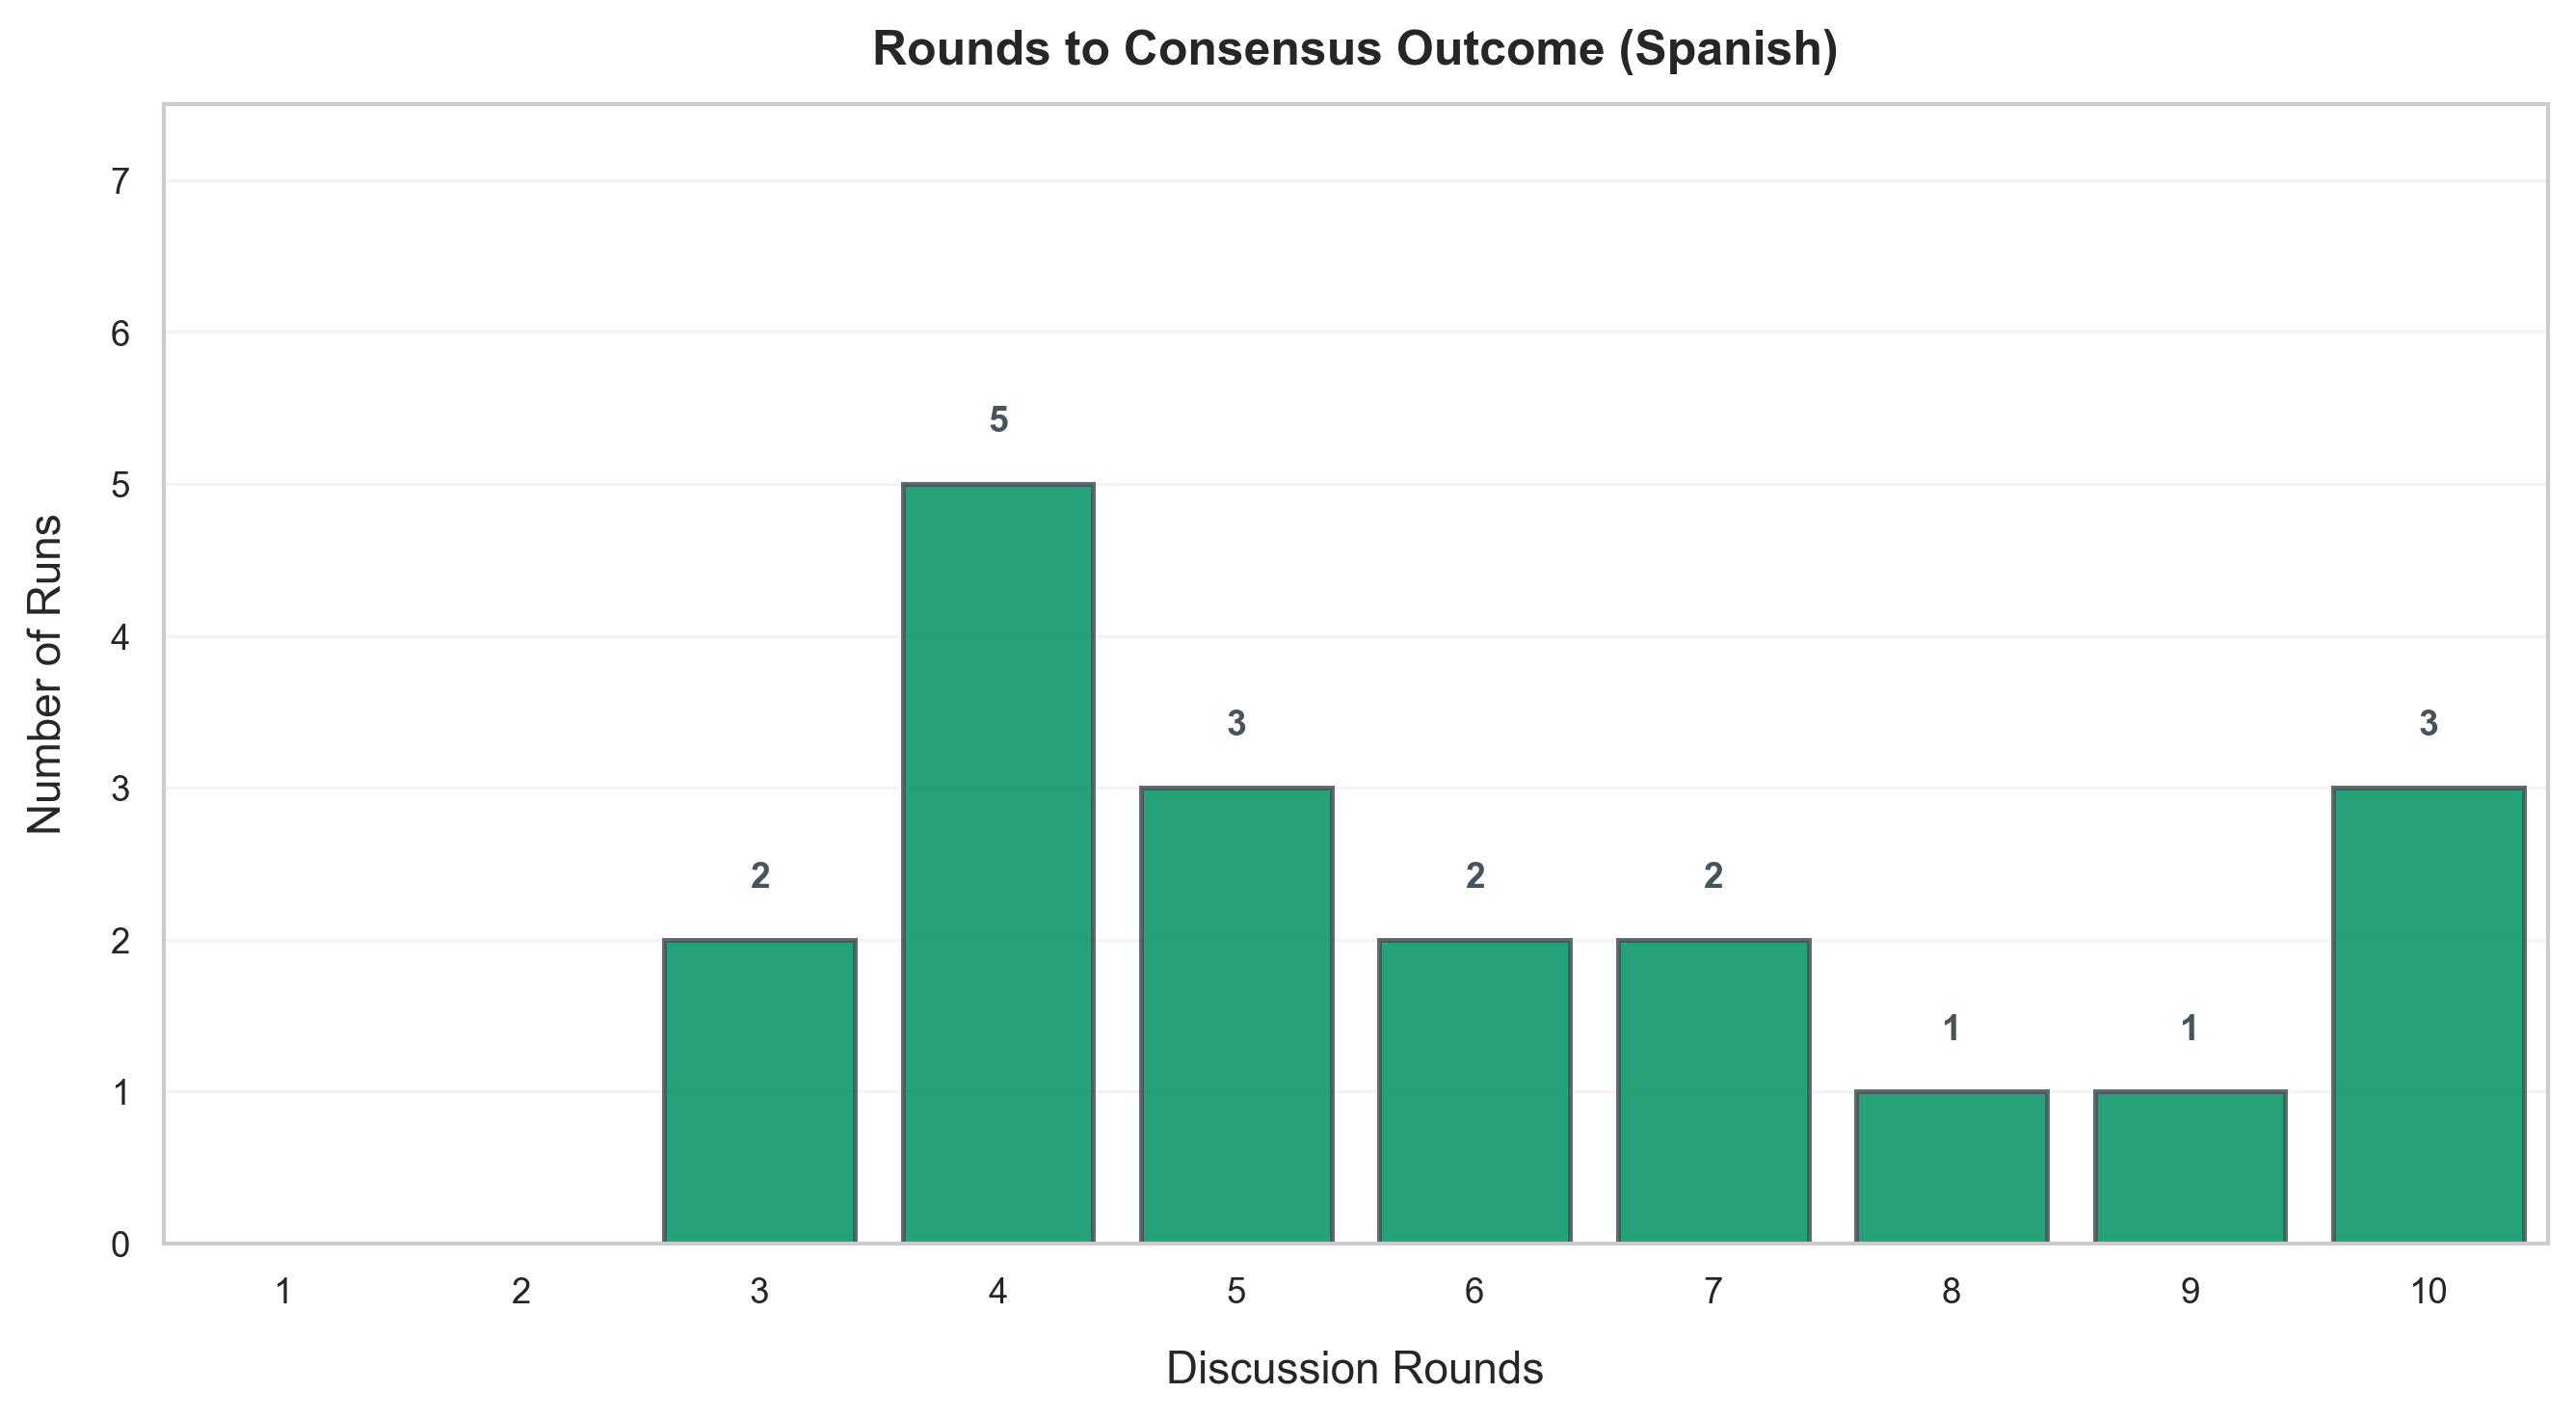

Consensus Timing Summary:
  Total consensus runs: 19
  Range: 3-10 rounds
  Mean: 6.00 rounds  |  Median: 5 rounds


### Floor Constraint Amounts

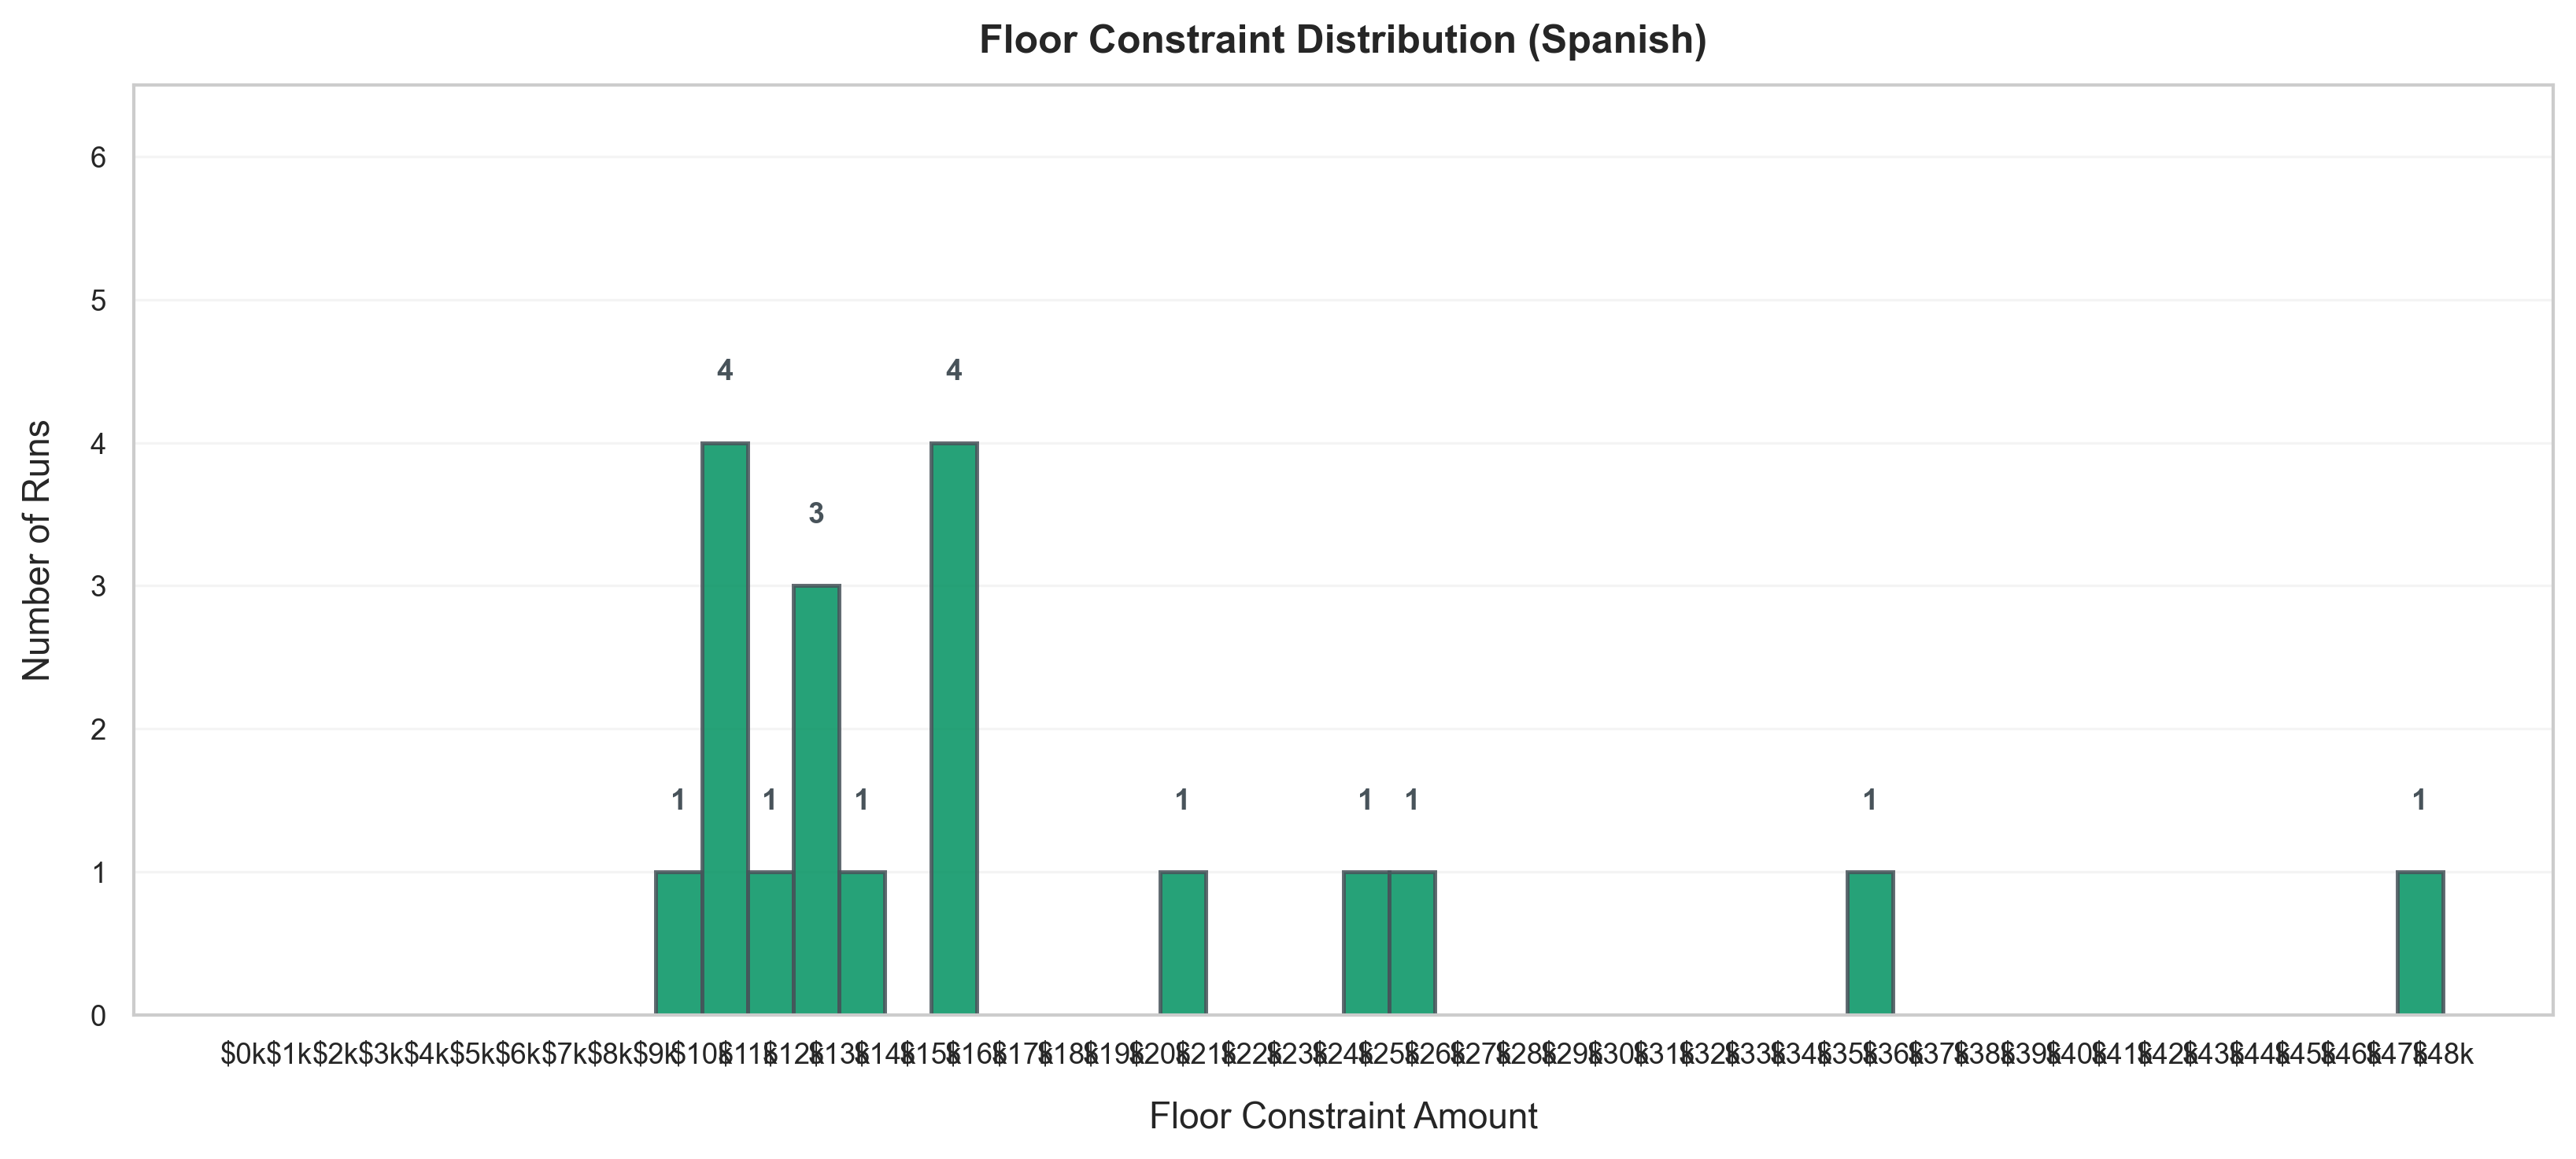

Floor Amount Summary:
  Total votes: 19
  Range: $9,000 - $48,000
  Mean: $16,895  |  Median: $13,000  |  SD: $9,760


### Voting Attempts and Success Rate

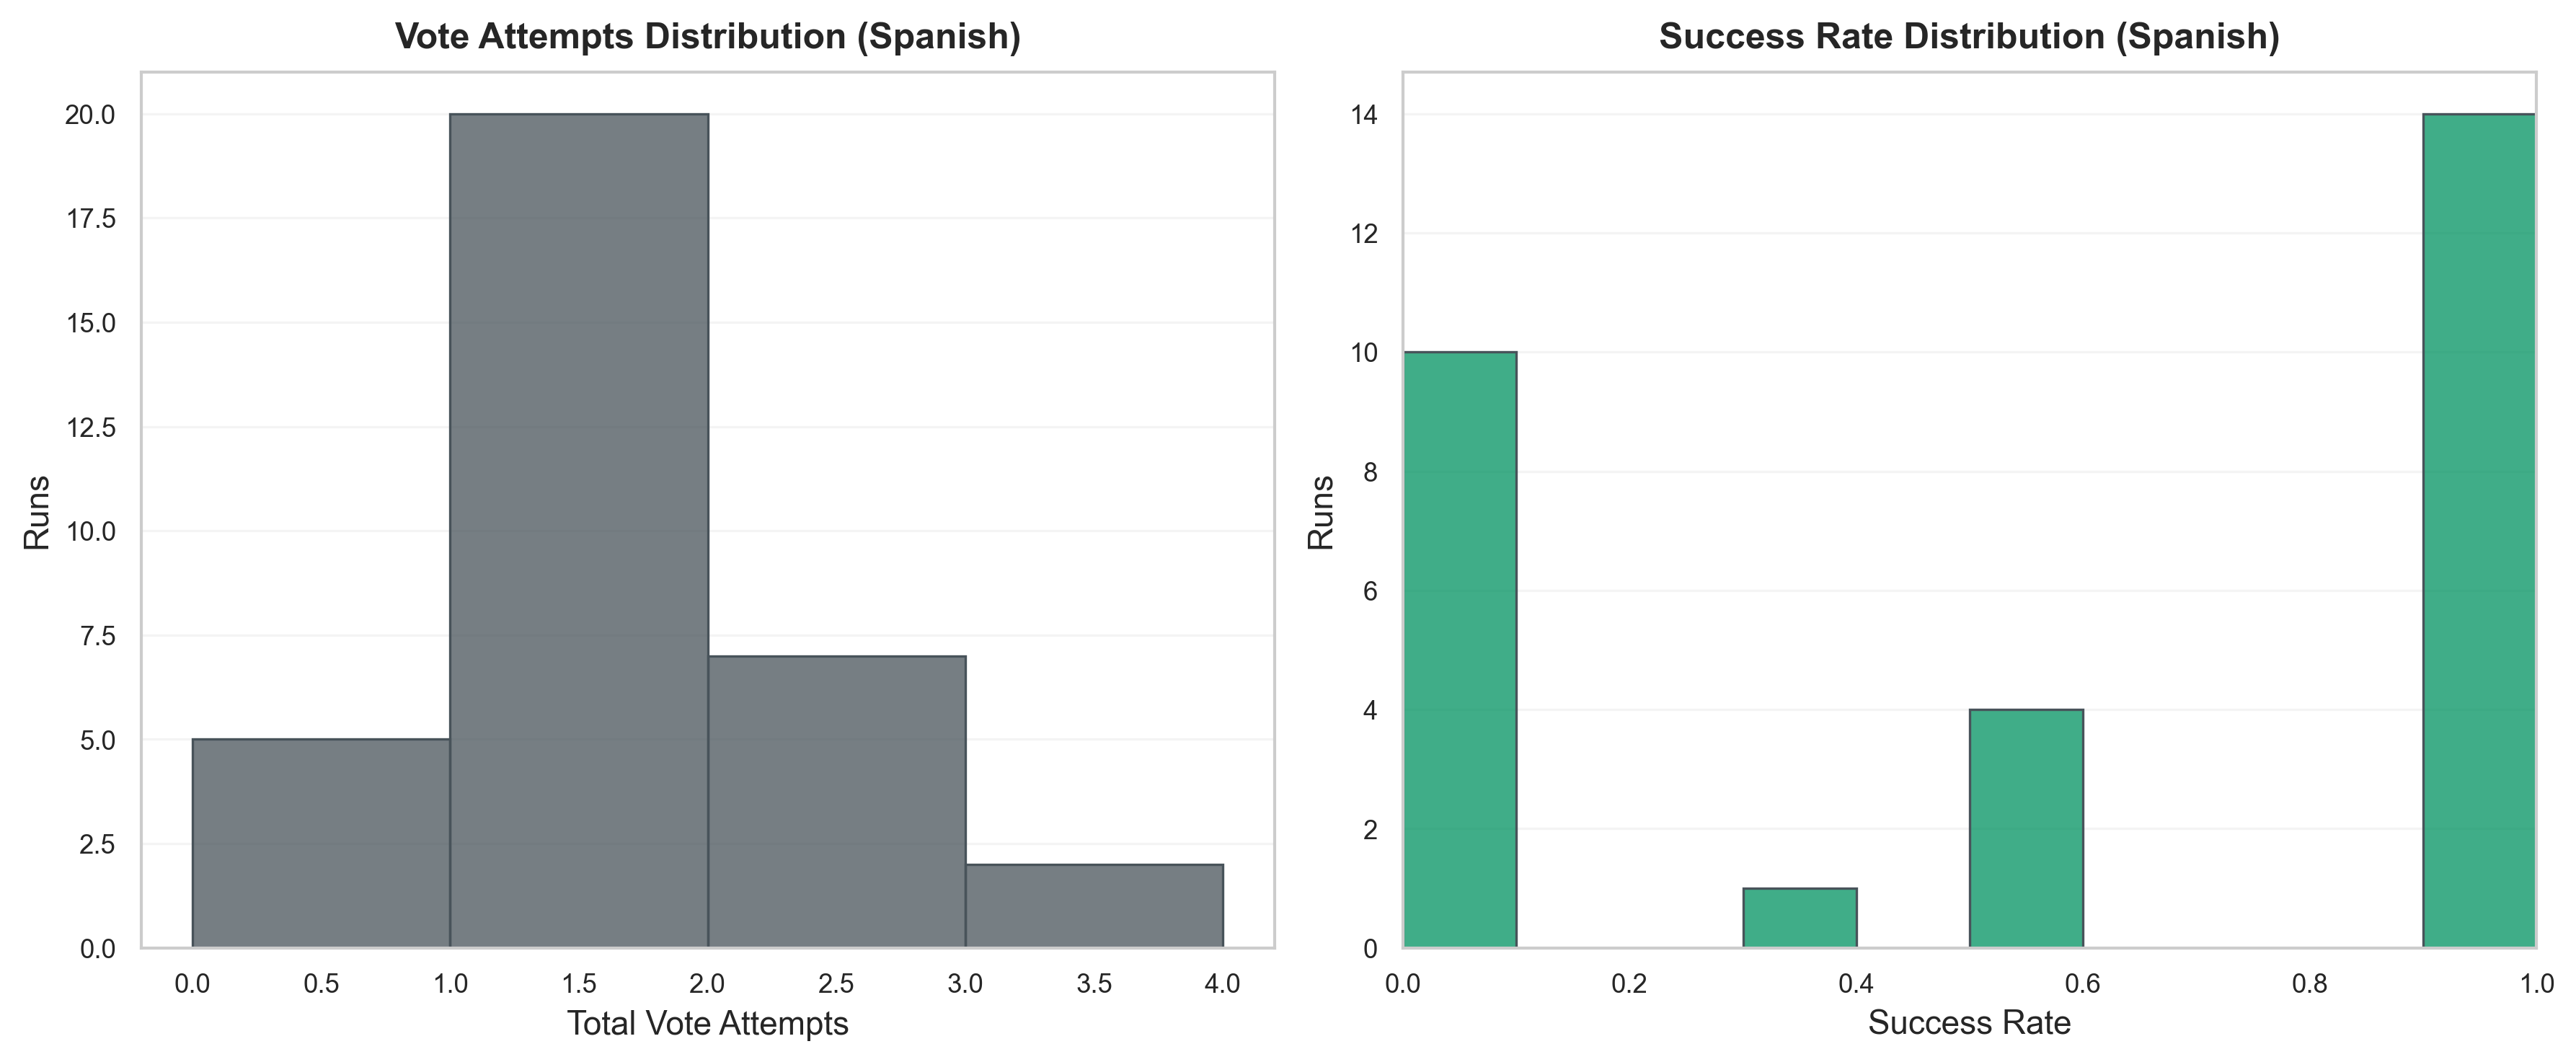

Voting Attempts Summary:
  Mean attempts per run: 1.18
  Median attempts per run: 1
  Mean success rate: 56.32%
  Median success rate: 50.00%


### Preference Evolution and Transitions

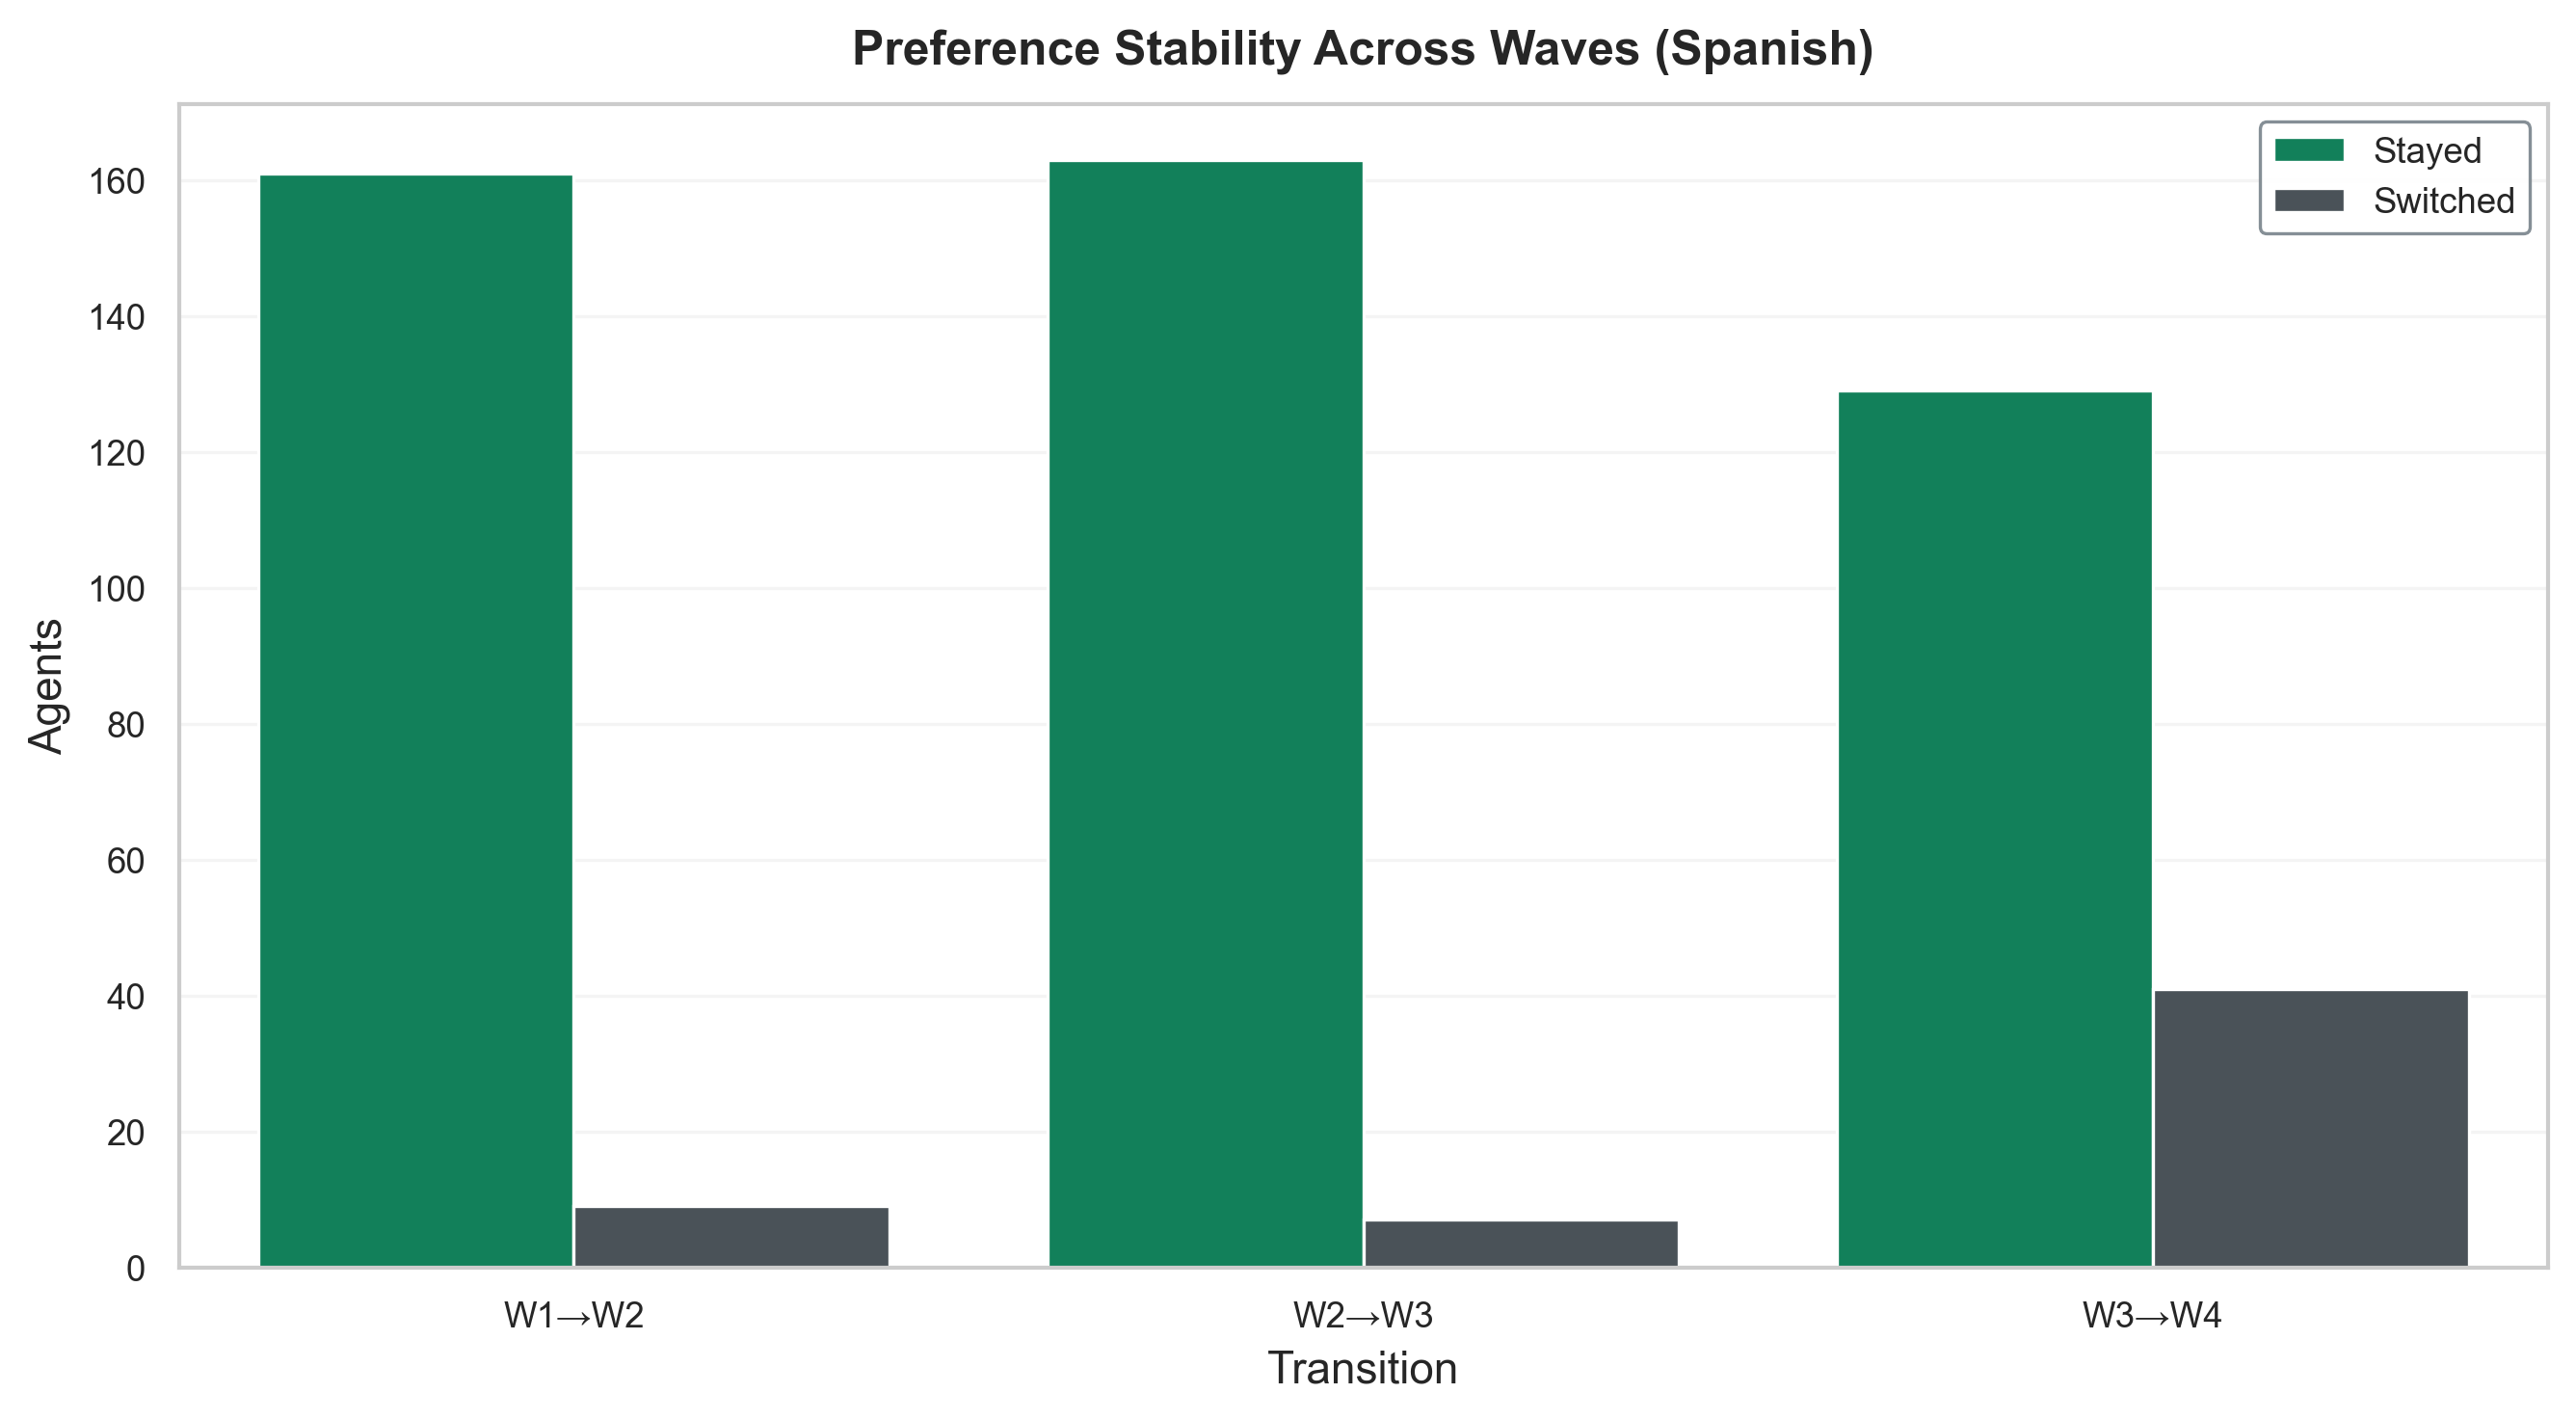

Stability Breakdown:
  W1→W2: 161/170 stayed (94.7%)
  W2→W3: 163/170 stayed (95.9%)
  W3→W4: 129/170 stayed (75.9%)


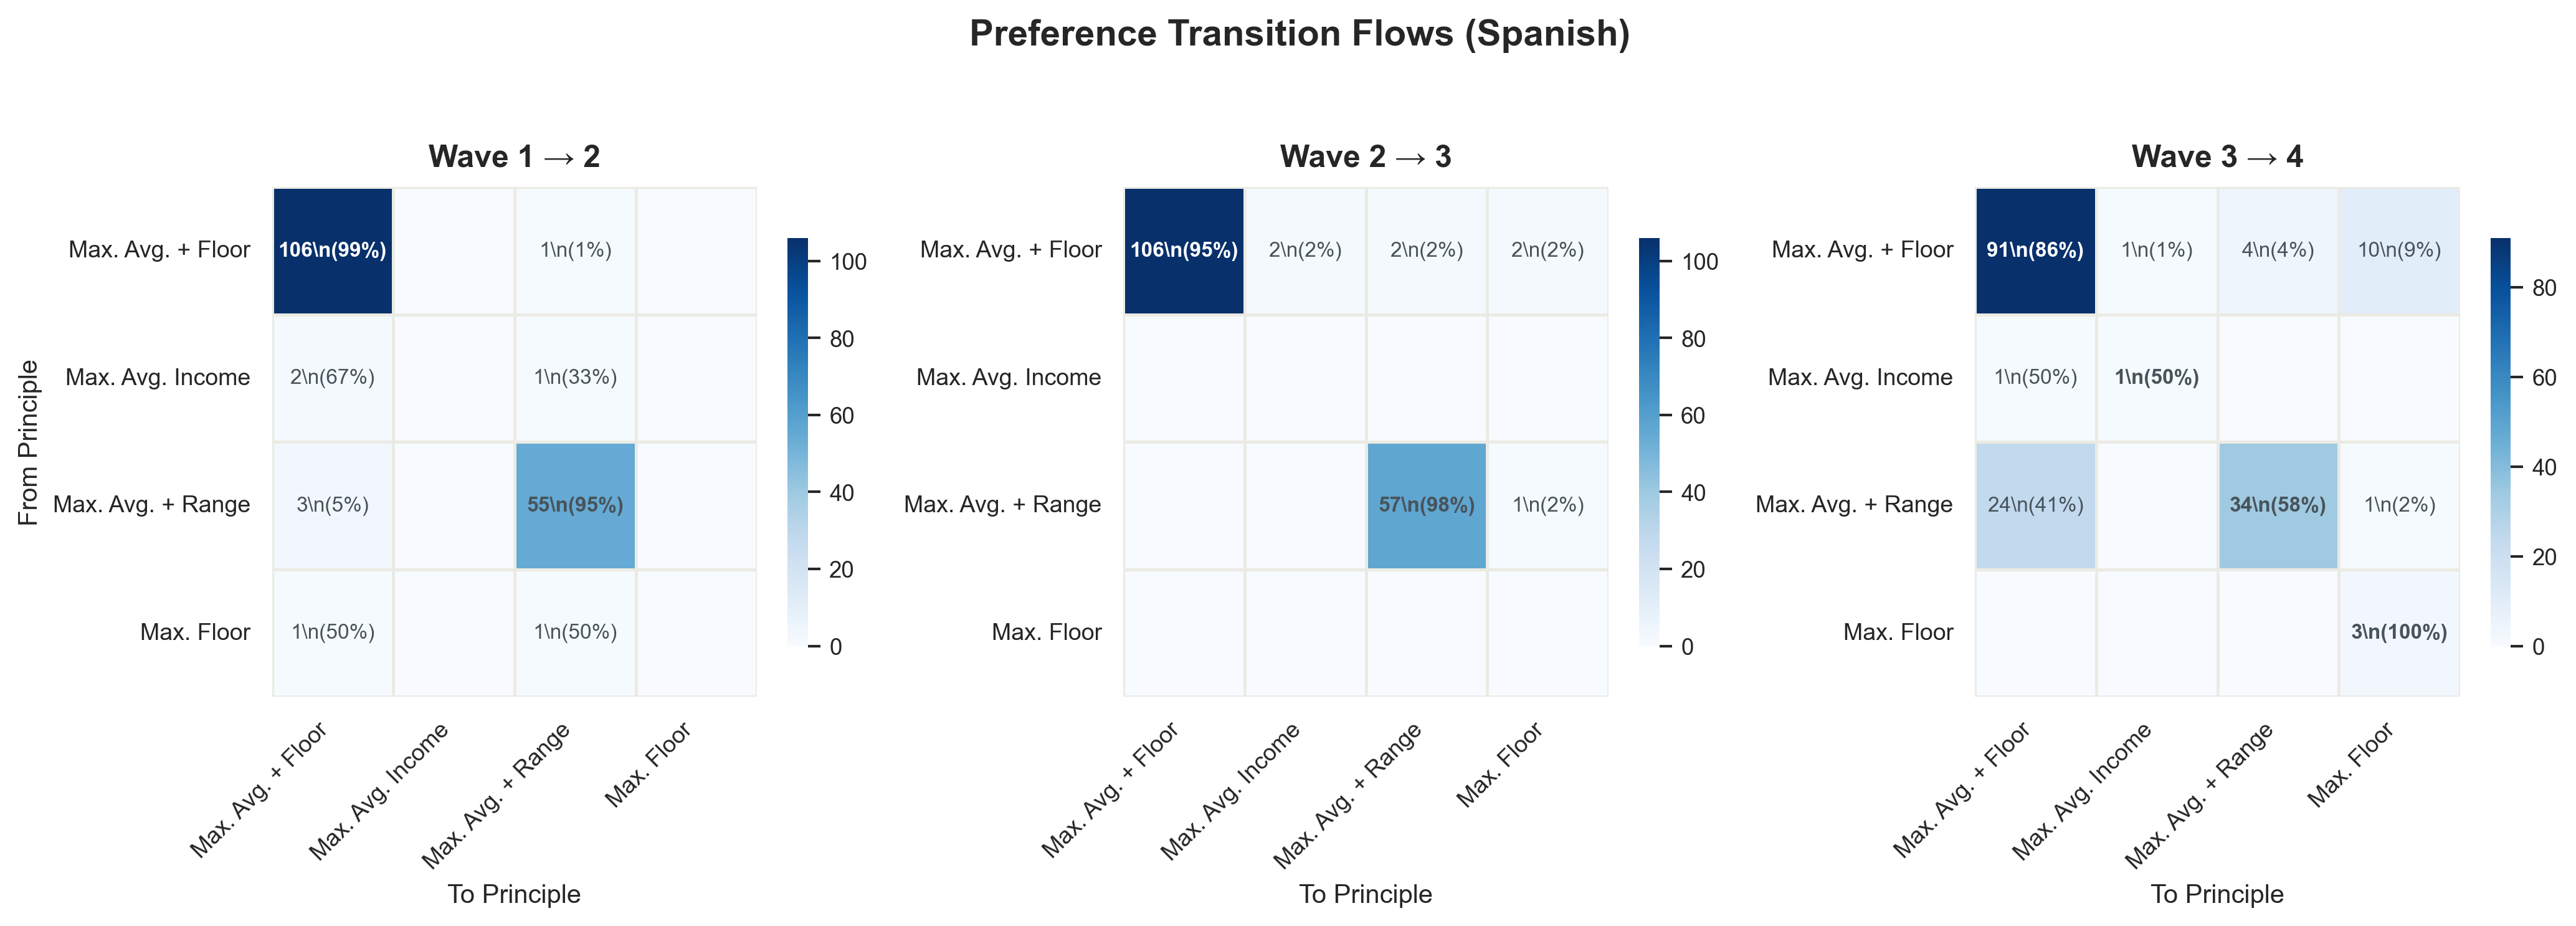

Transition Stay Rates:
  Wave 1 → 2: 161/170 stayed (94.7%)
  Wave 2 → 3: 163/170 stayed (95.9%)
  Wave 3 → 4: 129/170 stayed (75.9%)


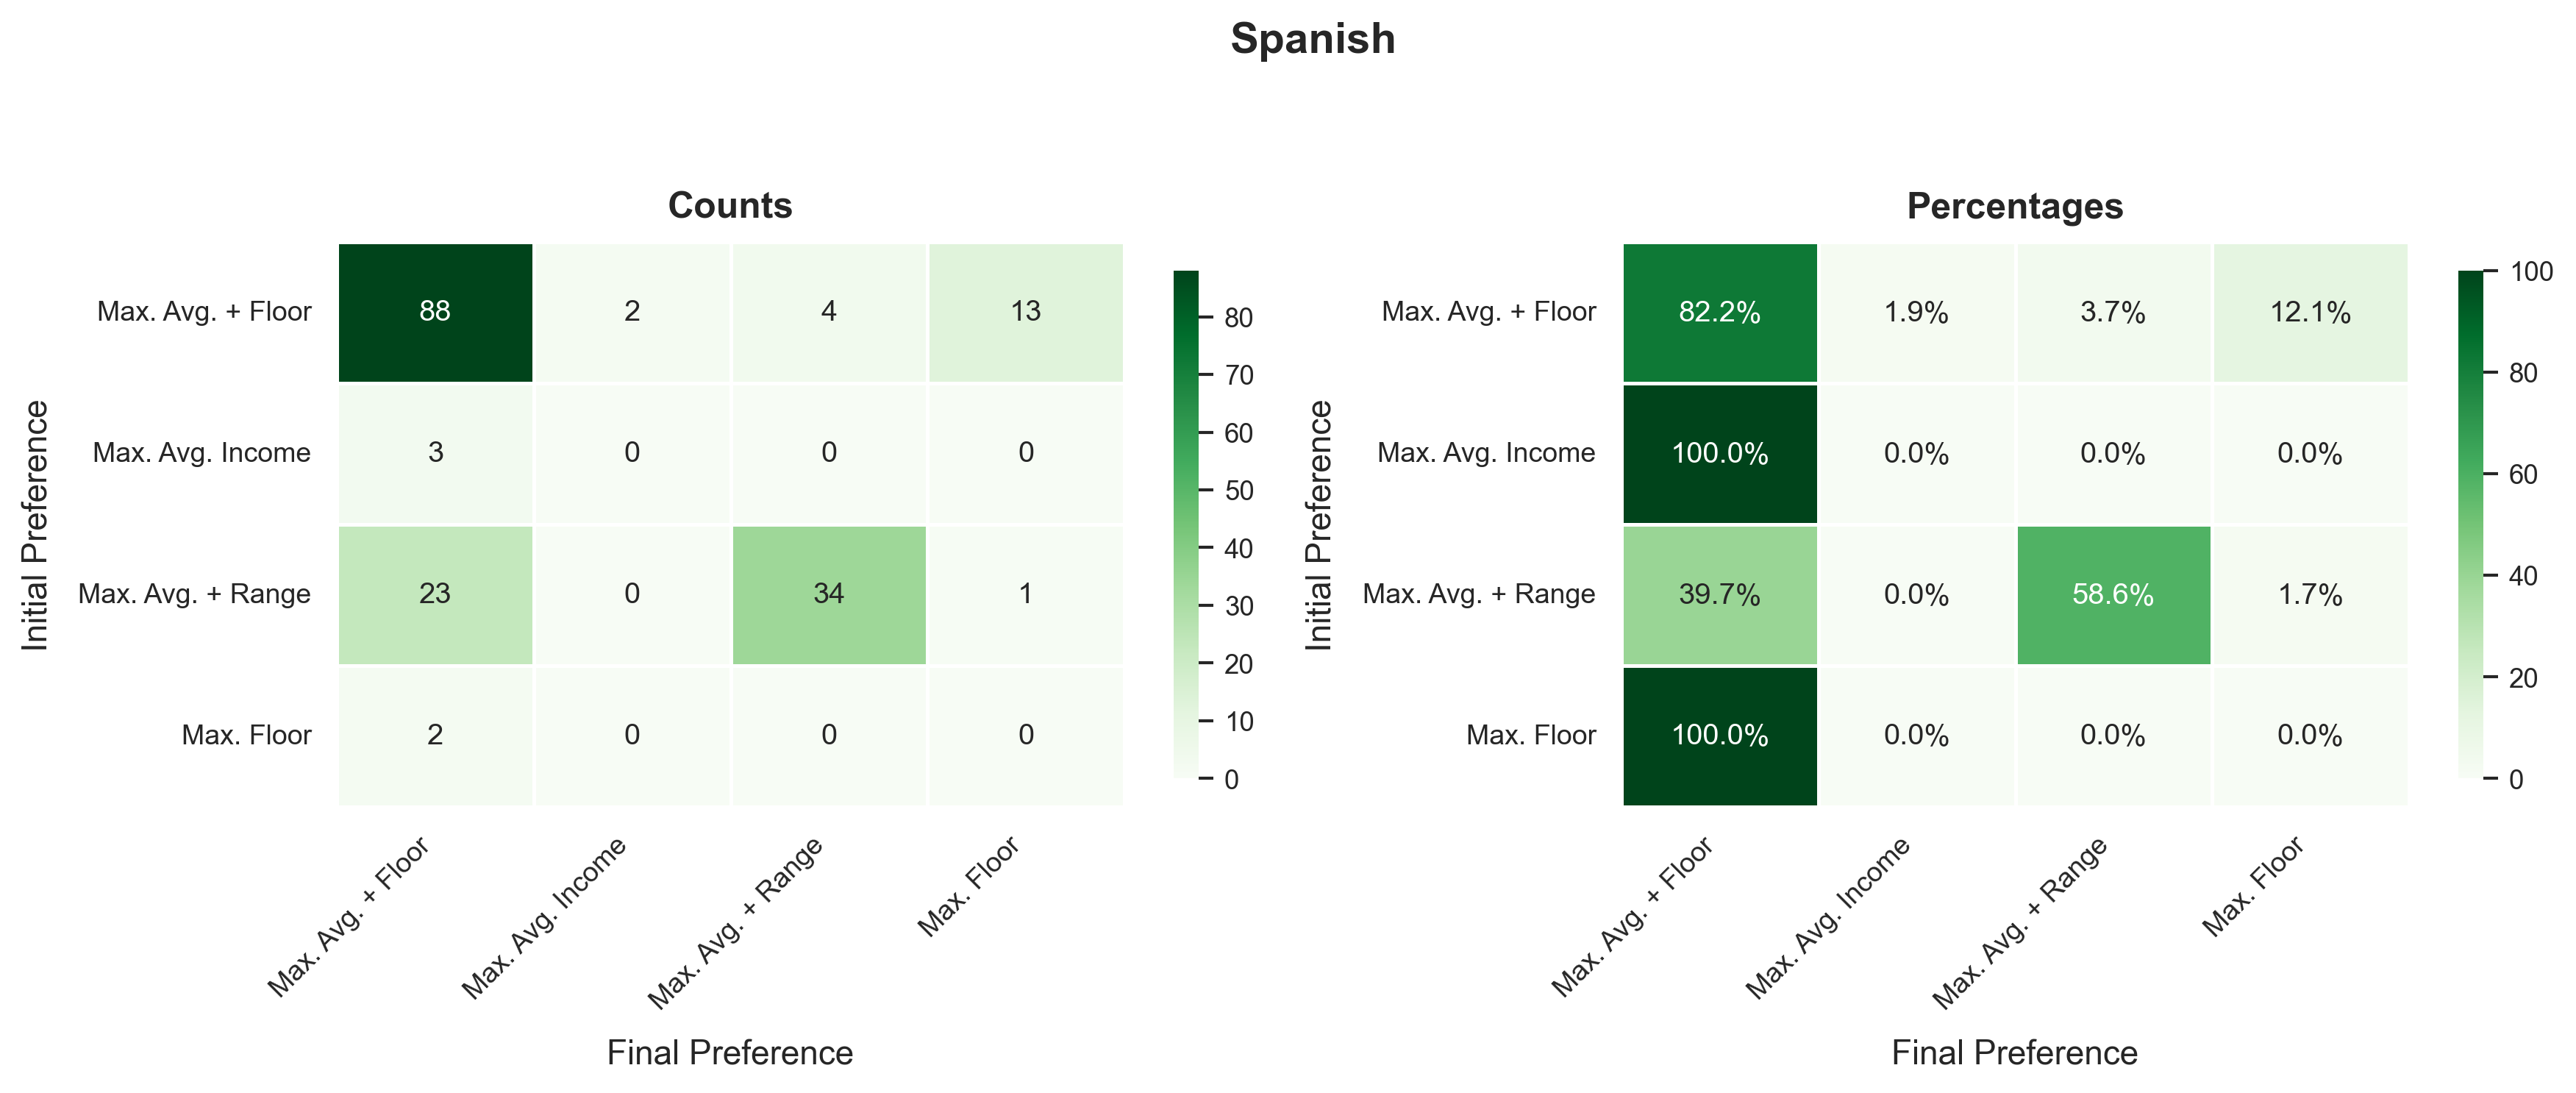

Long-Term Stability (Wave 1 → Wave 4) [Spanish]
Max. Avg. + Floor        :  88/107 maintained ( 82.2%)
Max. Avg. Income         :   0/  3 maintained (  0.0%)
Max. Avg. + Range        :  34/ 58 maintained ( 58.6%)
Max. Floor               :   0/  2 maintained (  0.0%)
OVERALL                  : 122/170 agents ( 71.8%)


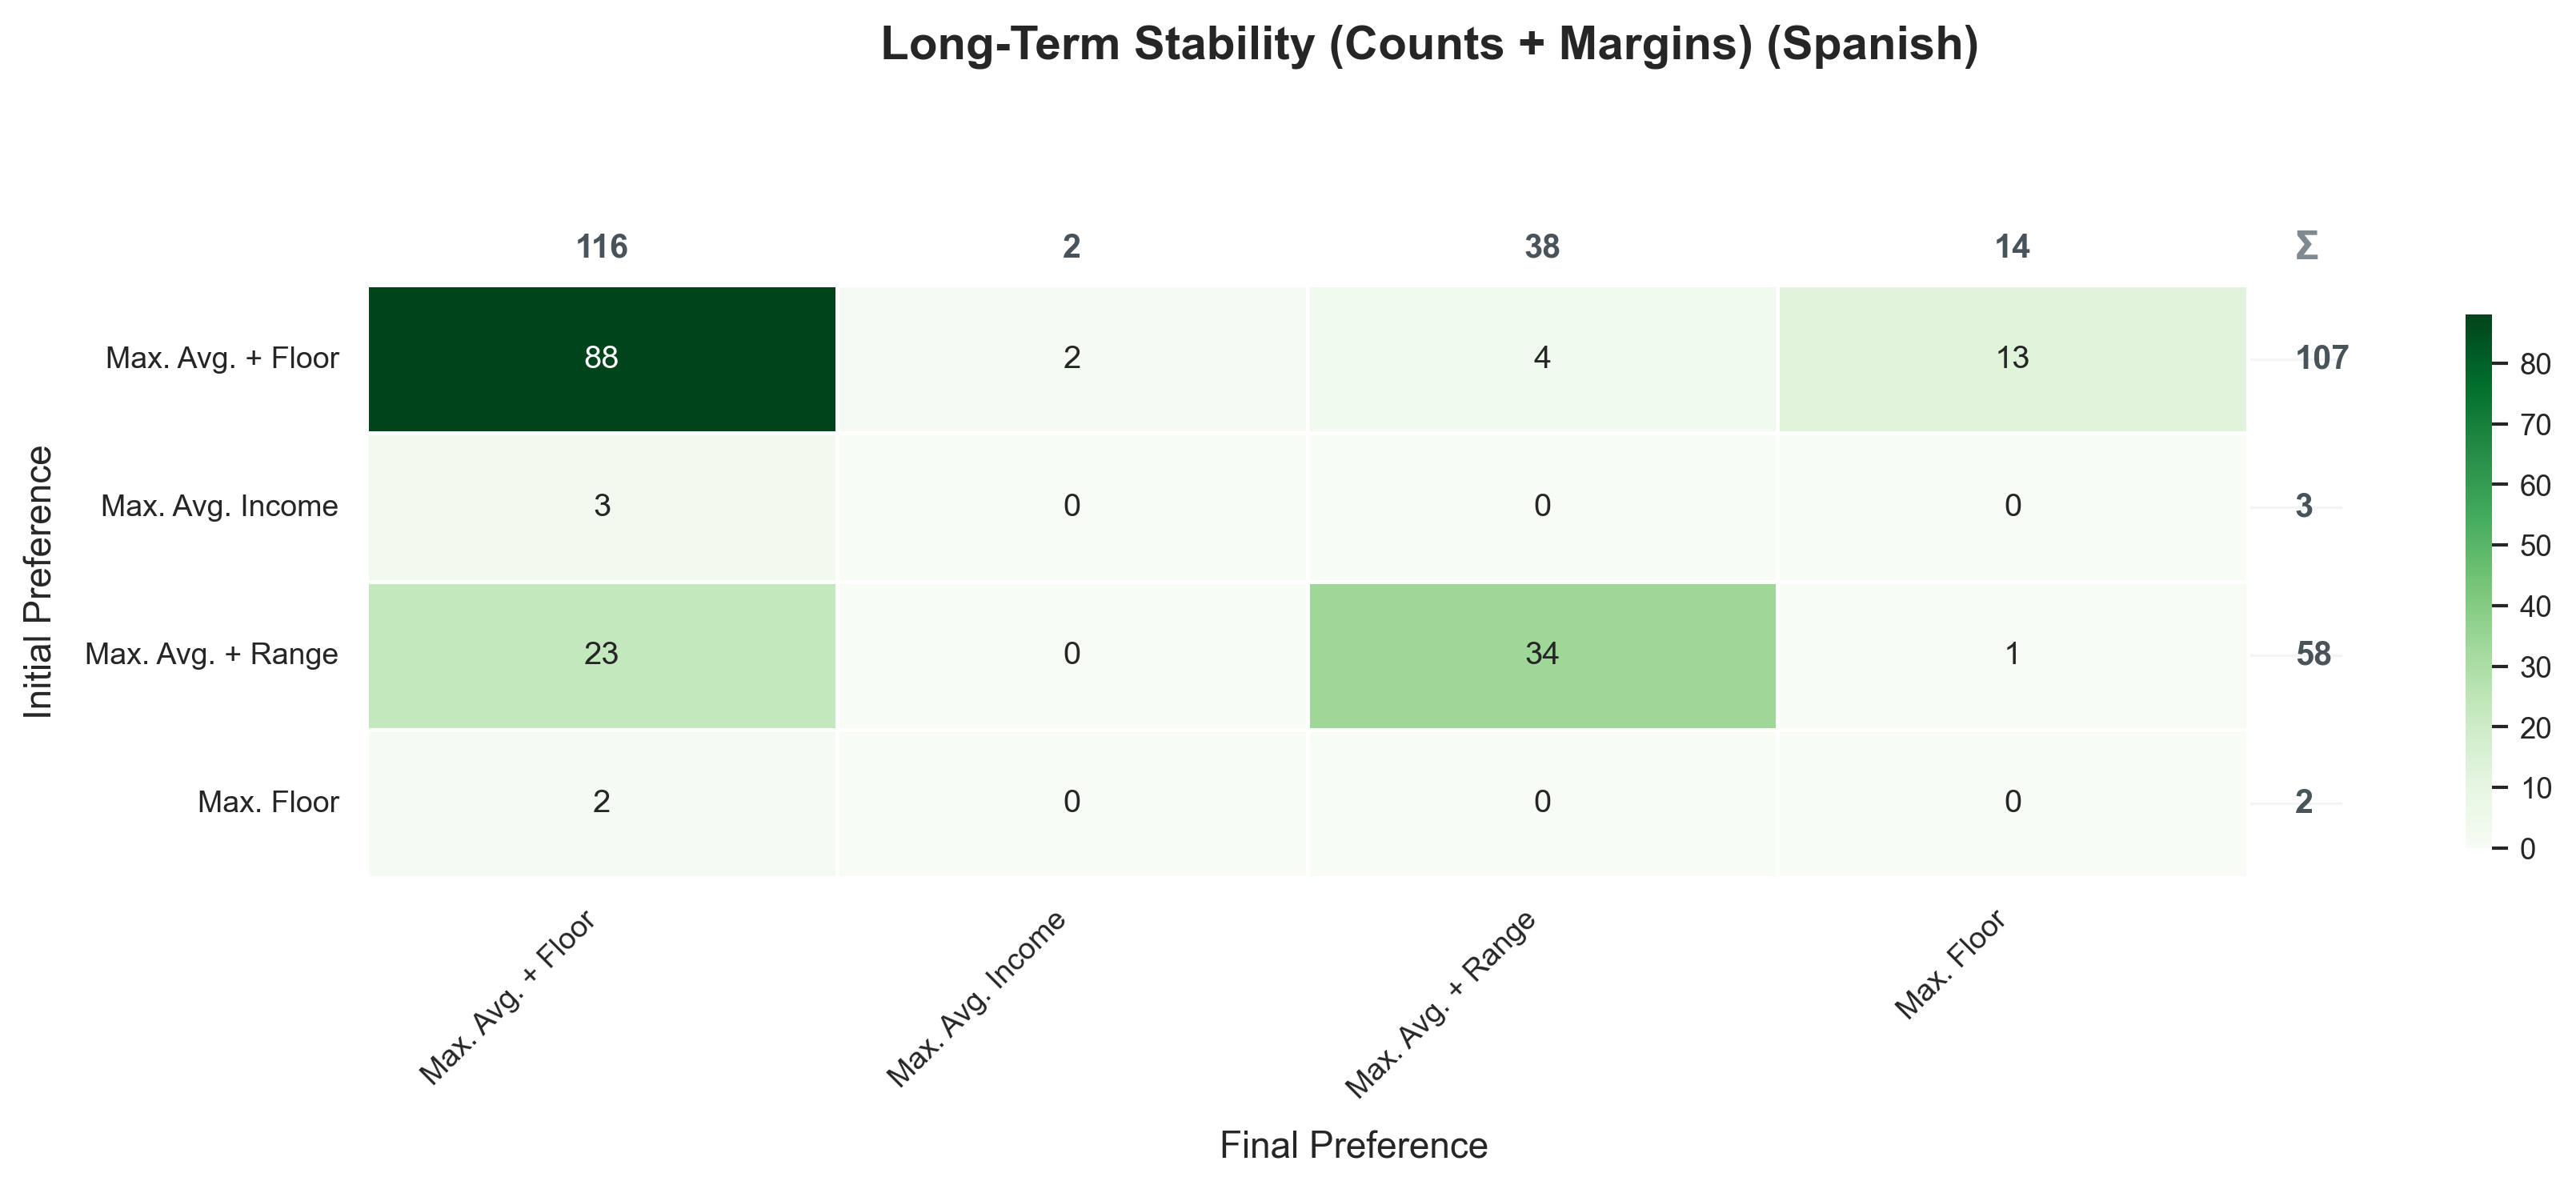

### Switcher Analysis: Income Class and Preference Changes

/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_34034/2101704904.py:358: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_long.pivot_table(


Income Class  Changed Preference  Maintained Preference  Total Agents  \
0          Low                  12                      8            20   
1       Medium                  20                     73            93   
2         High                   1                      4             5   
3      Unknown                  18                     34            52   

   Changed Share (%)  Maintained Share (%)  
0               60.0                  40.0  
1               21.5                  78.5  
2               20.0                  80.0  
3               34.6                  65.4

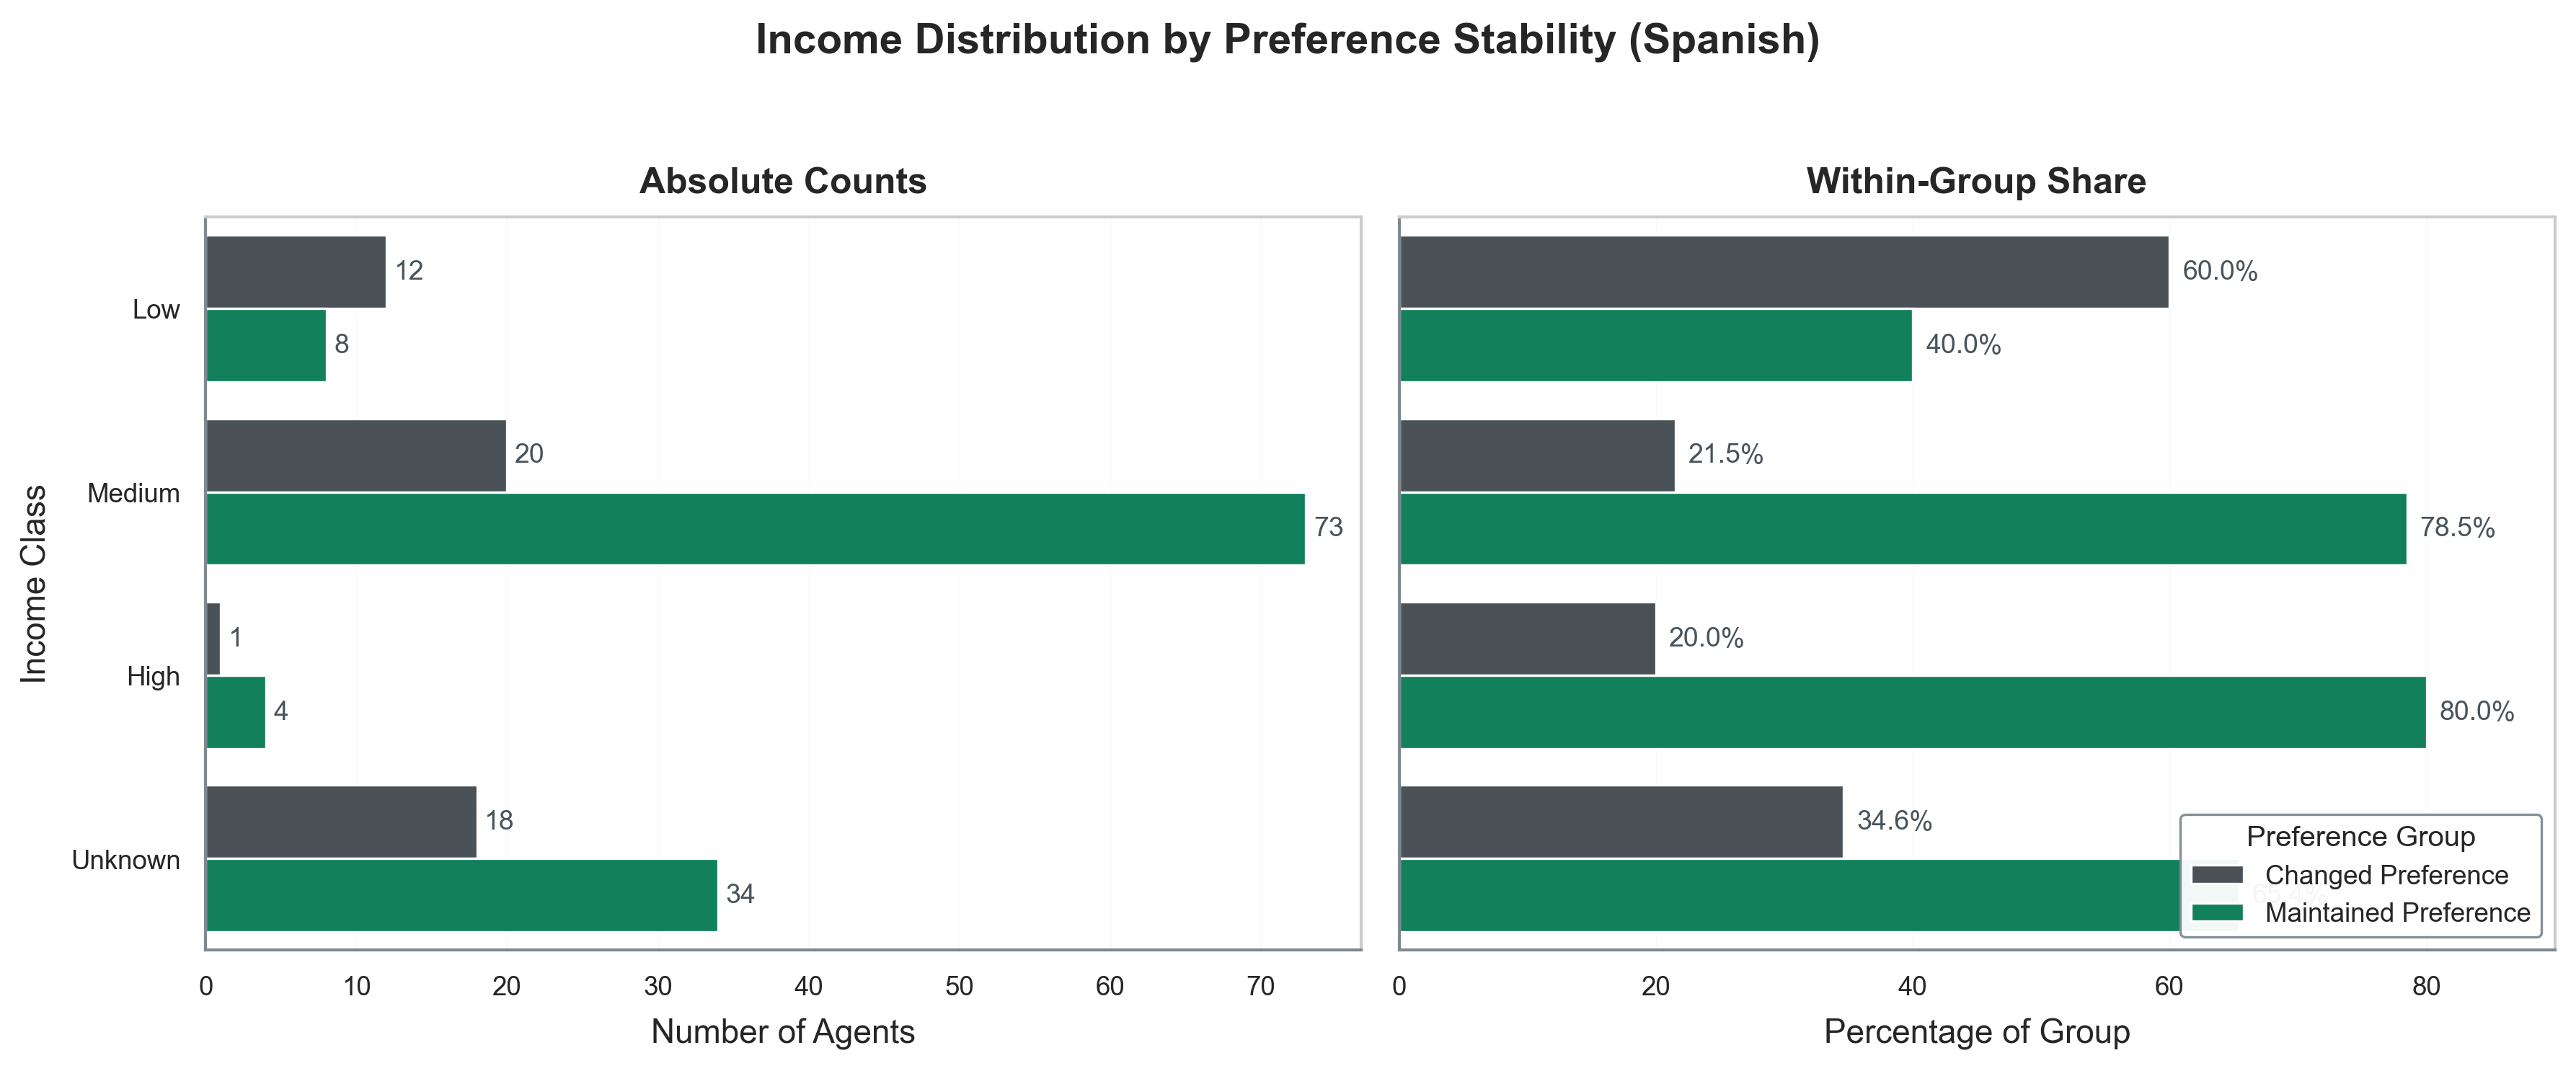

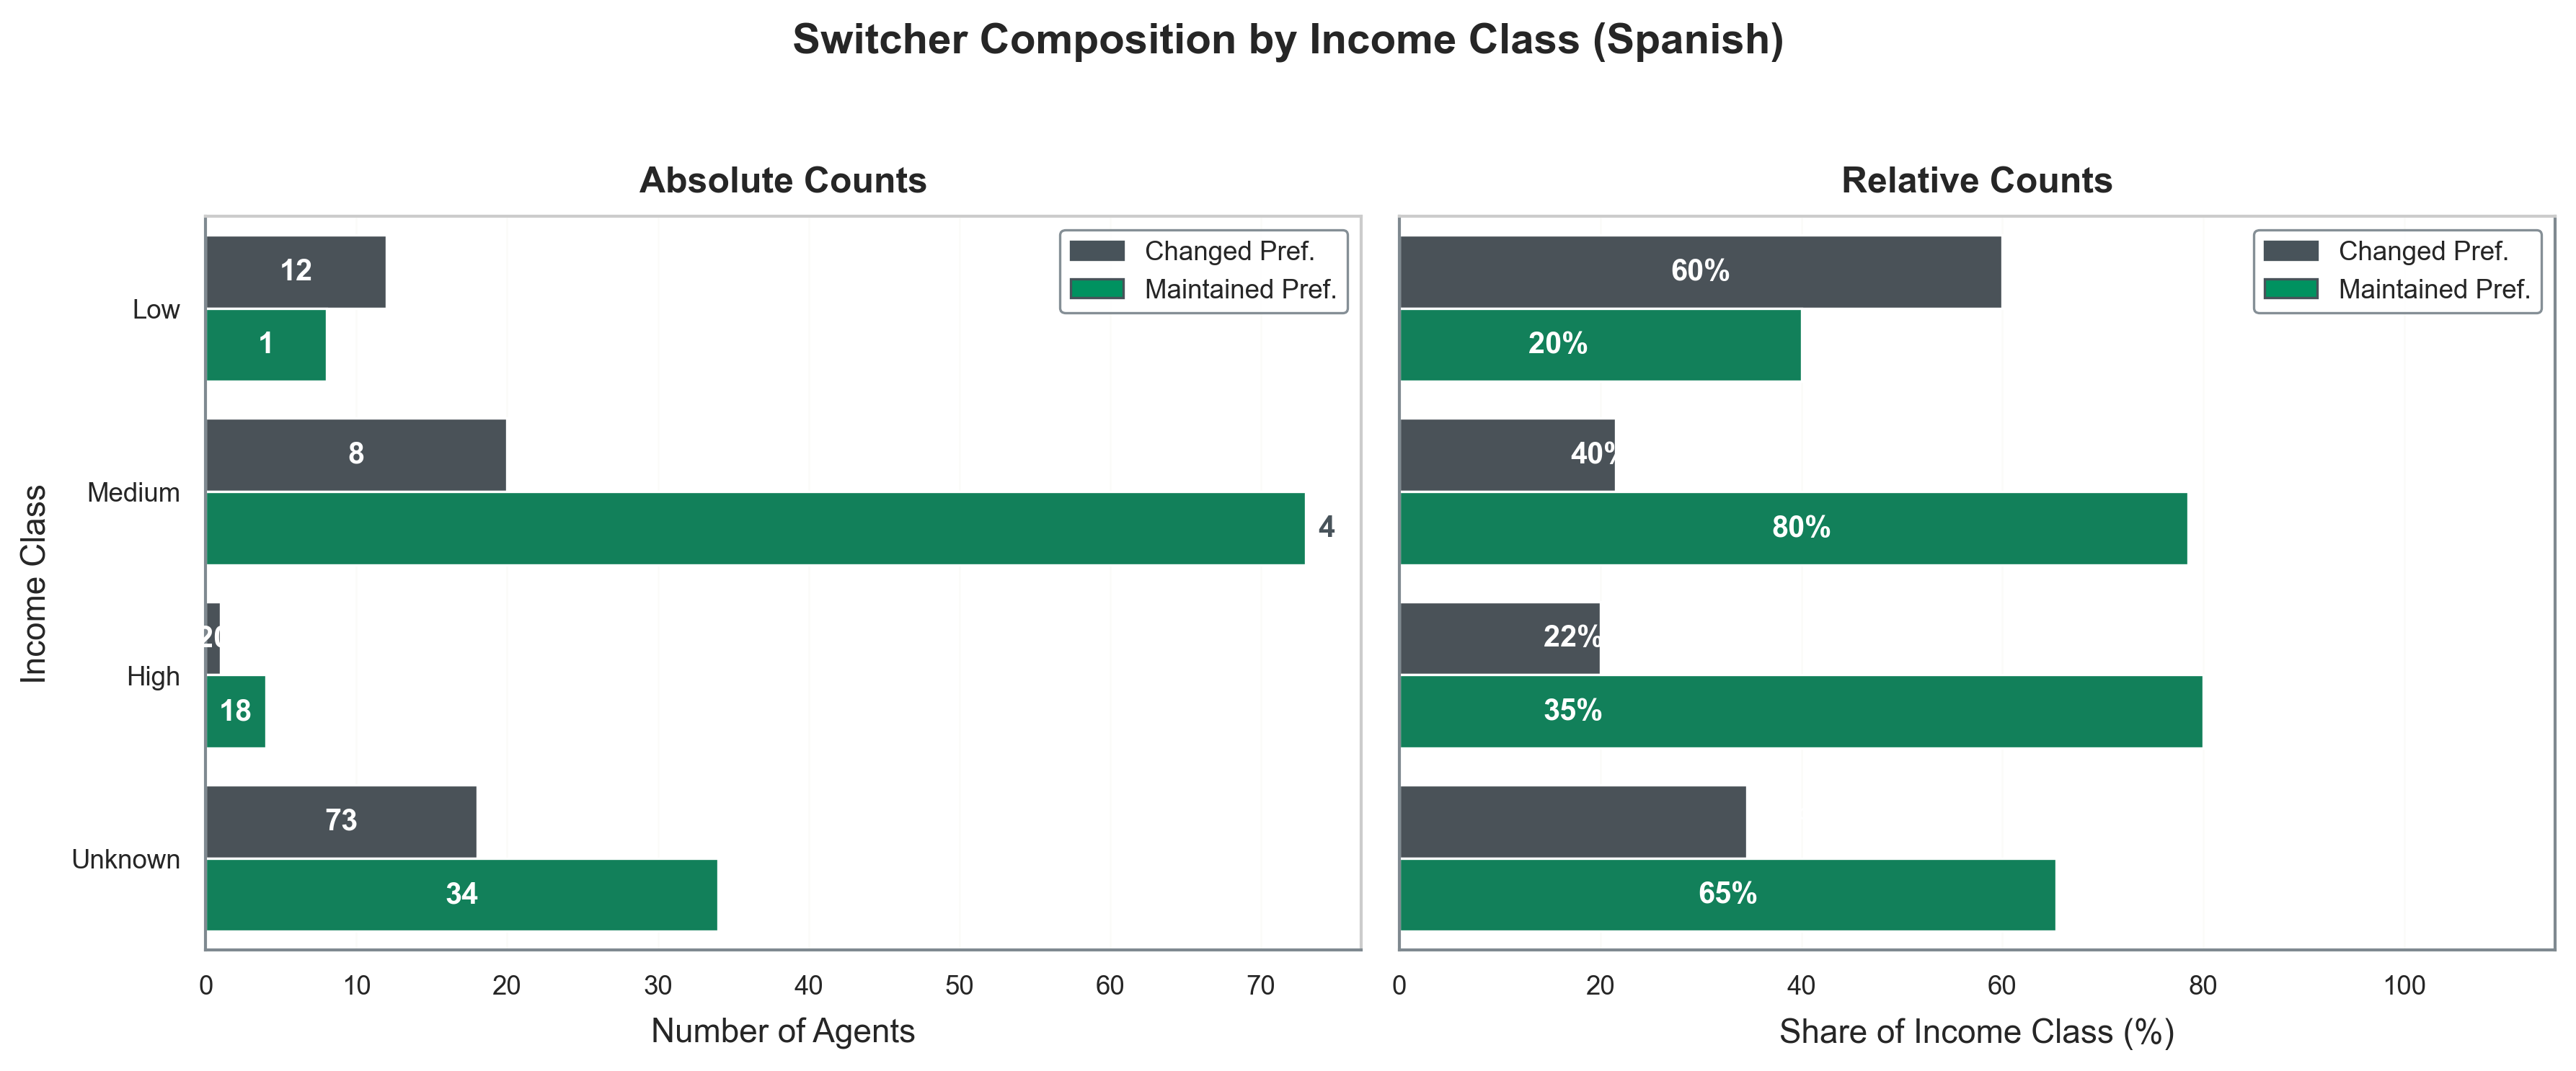

## Mandarin Cohort

### Data Summary

Metric  Value
0              Runs     34
1    Consensus runs     28
2    Agent sessions    170
3  Preference waves      4

Transition coverage: 170/170 agents with full wave data


### Preference Orderings by Wave

**Wave 1 - Initial**

Preference Ordering  Count  Percentage
0  Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     54        31.8
1  Max. Avg. + Floor > Max. Avg. + Range > Max. F...     45        26.5
2  Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...     35        20.6
3  Max. Floor > Max. Avg. Income > Max. Avg. + Fl...     26        15.3
4  Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      5         2.9
5  Max. Avg. + Floor > Max. Avg. + Range > Max. A...      1         0.6
6  Max. Avg. + Floor > Max. Avg. Income > Max. Av...      1         0.6
7  Max. Avg. + Floor > Max. Avg. Income > Max. Fl...      1         0.6
8  Max. Avg. Income > Max. Avg. + Floor > Max. Fl...      1         0.6
9  Max. Avg. Income > Max. Avg. + Range > Max. Fl...      1         0.6

**Wave 2 - Post-Explanation**

Preference Ordering  Count  Percentage
0  Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...     53        31.2
1  Max. Avg. + Floor > Max. Avg. + Range > Max. F...     46        27.1
2  Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     43        25.3
3  Max. Floor > Max. Avg. Income > Max. Avg. + Fl...     18        10.6
4  Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      4         2.4
5  Max. Avg. + Floor > Max. Avg. + Range > Max. A...      2         1.2
6  Max. Avg. + Floor > Max. Avg. Income > Max. Av...      2         1.2
7  Max. Avg. + Floor > Max. Avg. Income > Max. Fl...      2         1.2

**Wave 3 - Final Phase 1**

Preference Ordering  Count  Percentage
0  Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...     42        24.7
1  Max. Avg. + Floor > Max. Avg. + Range > Max. F...     34        20.0
2  Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     29        17.1
3  Max. Floor > Max. Avg. Income > Max. Avg. + Fl...     28        16.5
4  Max. Avg. + Floor > Max. Avg. Income > Max. Av...     10         5.9
5  Max. Avg. + Floor > Max. Avg. + Range > Max. A...      9         5.3
6  Max. Avg. + Floor > Max. Avg. Income > Max. Fl...      8         4.7
7  Max. Floor > Max. Avg. + Floor > Max. Avg. + R...      6         3.5
8  Max. Avg. Income > Max. Avg. + Floor > Max. Av...      3         1.8
9  Max. Avg. + Range > Max. Avg. + Floor > Max. A...      1         0.6

**Wave 4 - Post-Group**

Preference Ordering  Count  Percentage
0   Max. Avg. + Floor > Max. Floor > Max. Avg. Inc...     49        28.8
1   Max. Avg. + Floor > Max. Avg. + Range > Max. F...     39        22.9
2   Max. Avg. + Floor > Max. Floor > Max. Avg. + R...     22        12.9
3   Max. Avg. + Floor > Max. Avg. Income > Max. Fl...     16         9.4
4   Max. Floor > Max. Avg. + Floor > Max. Avg. + R...     12         7.1
5   Max. Avg. + Floor > Max. Avg. Income > Max. Av...     10         5.9
6   Max. Avg. + Floor > Max. Avg. + Range > Max. A...      9         5.3
7   Max. Floor > Max. Avg. Income > Max. Avg. + Fl...      6         3.5
8   Max. Floor > Max. Avg. + Range > Max. Avg. + F...      2         1.2
9   Max. Avg. + Range > Max. Avg. + Floor > Max. F...      1         0.6
10  Max. Avg. + Range > Max. Floor > Max. Avg. + F...      1         0.6
11  Max. Avg. Income > Max. Avg. + Floor > Max. Av...      1         0.6
12  Max. Avg. Income > Max. Avg. + Floor > Max. Fl...      1         0.6
13  Max. Floor > Max. Avg. + Floor > Max. Avg. Inc...      1         0.6

### Rounds to Outcome

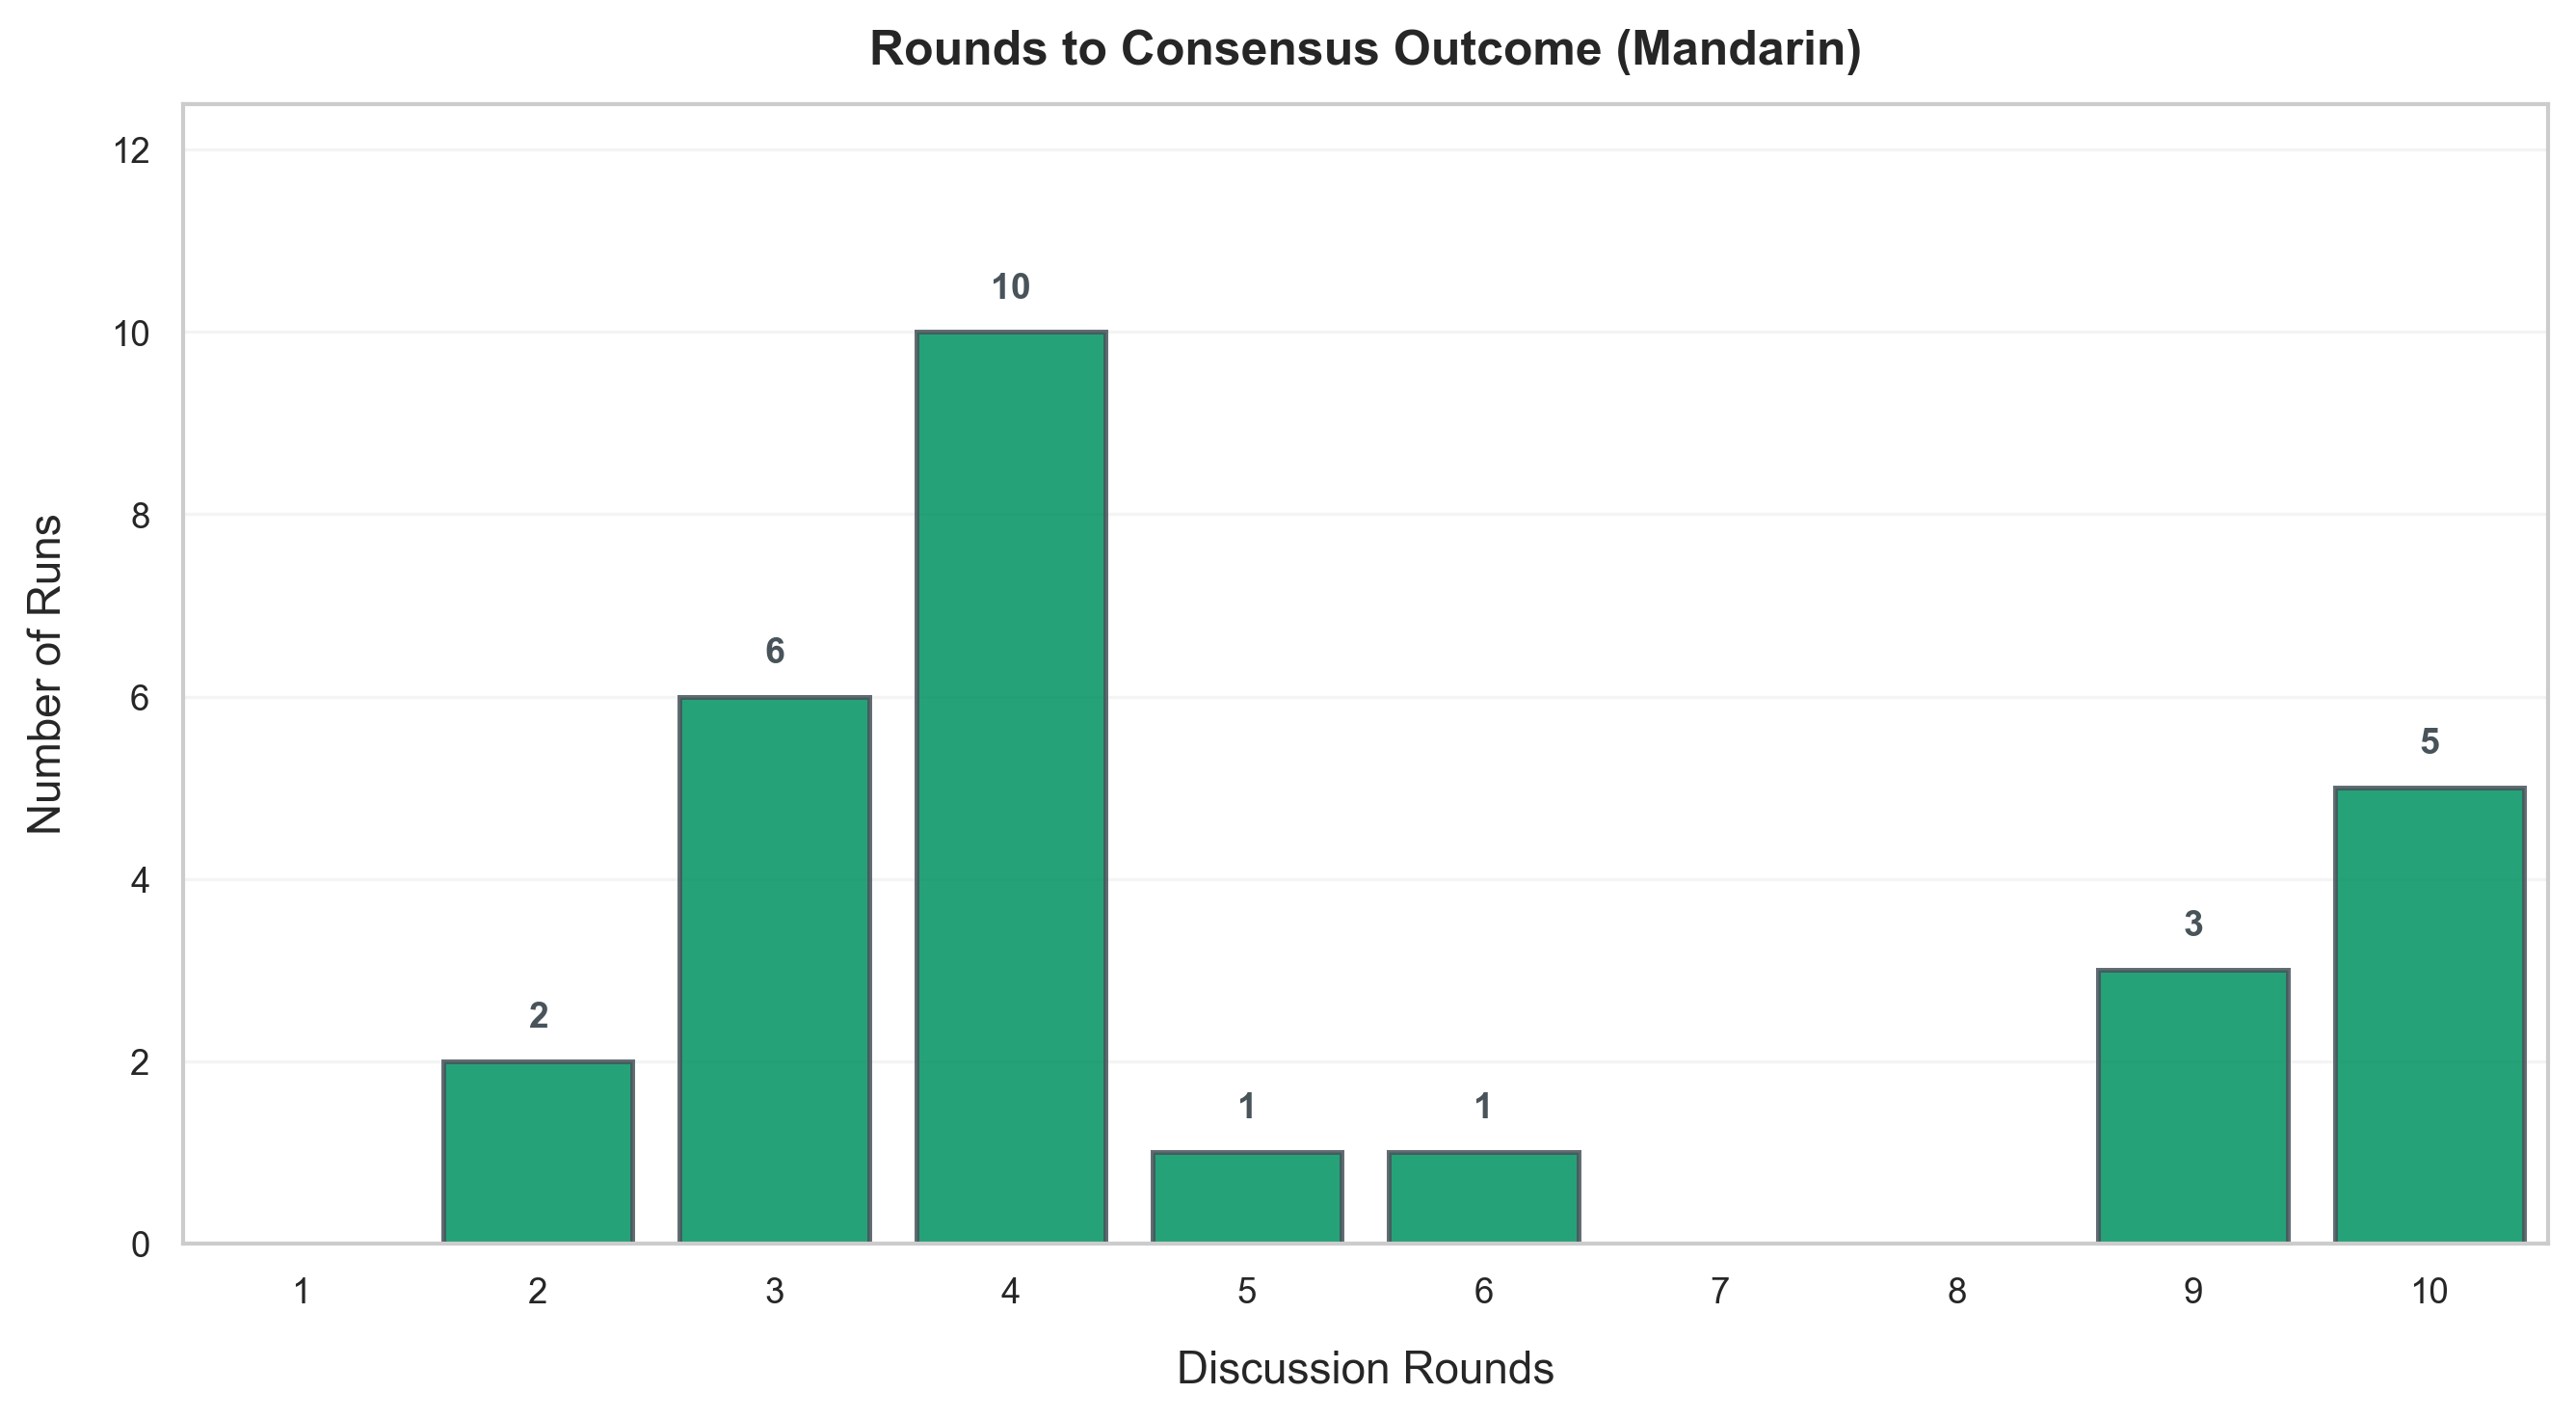

Consensus Timing Summary:
  Total consensus runs: 28
  Range: 2-10 rounds
  Mean: 5.36 rounds  |  Median: 4 rounds


### Floor Constraint Amounts

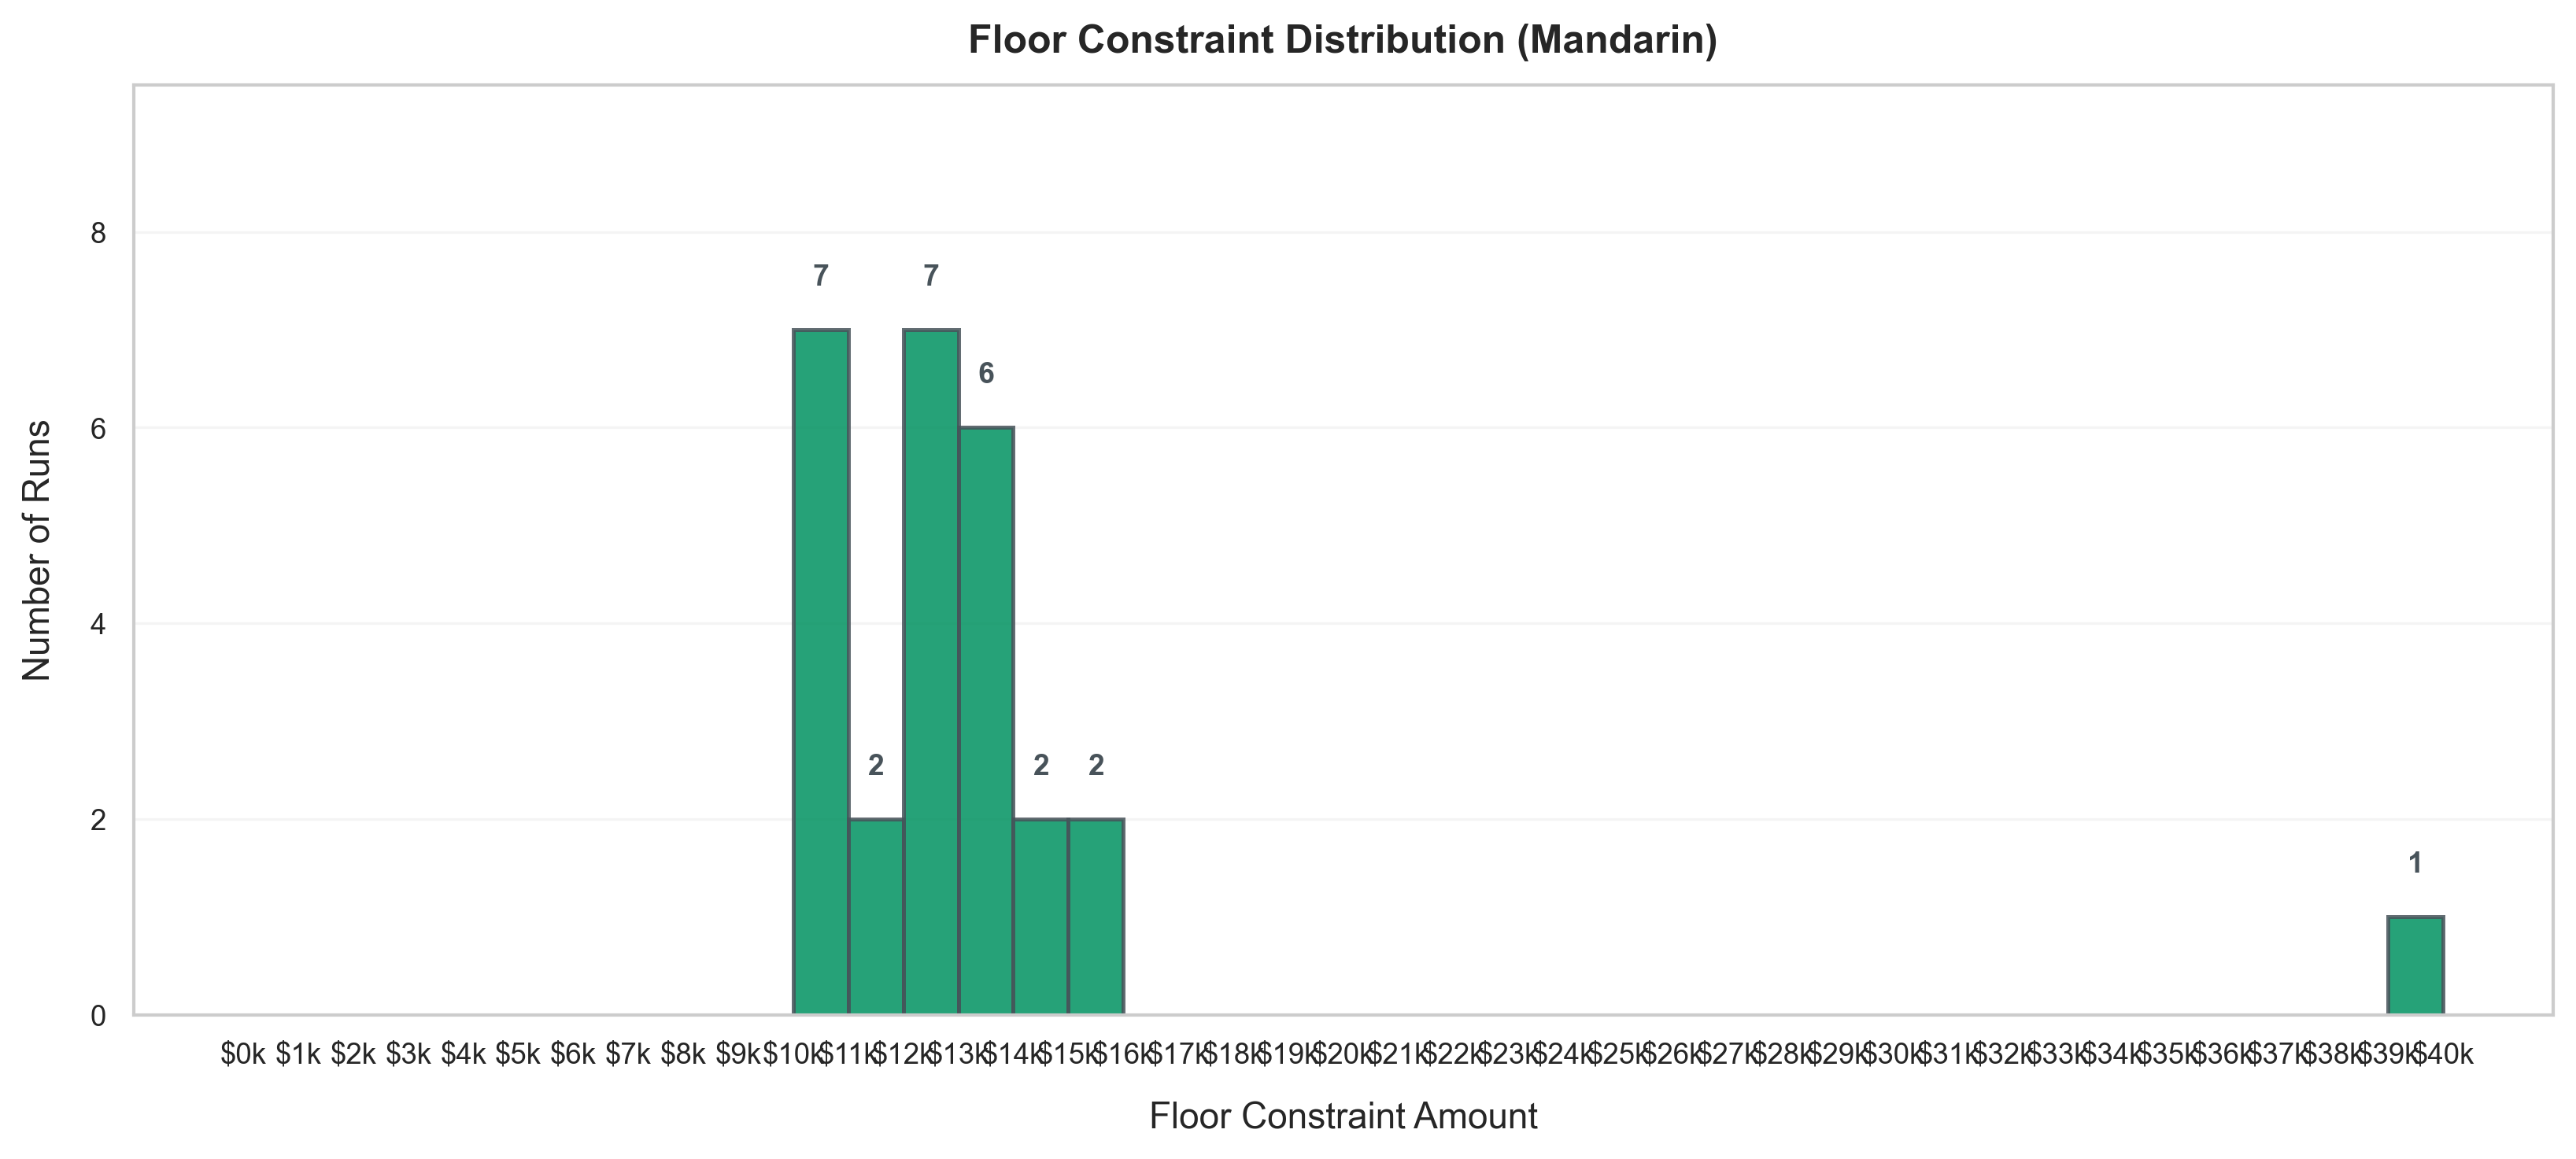

Floor Amount Summary:
  Total votes: 27
  Range: $10,000 - $40,000
  Mean: $13,074  |  Median: $12,000  |  SD: $5,495


### Voting Attempts and Success Rate

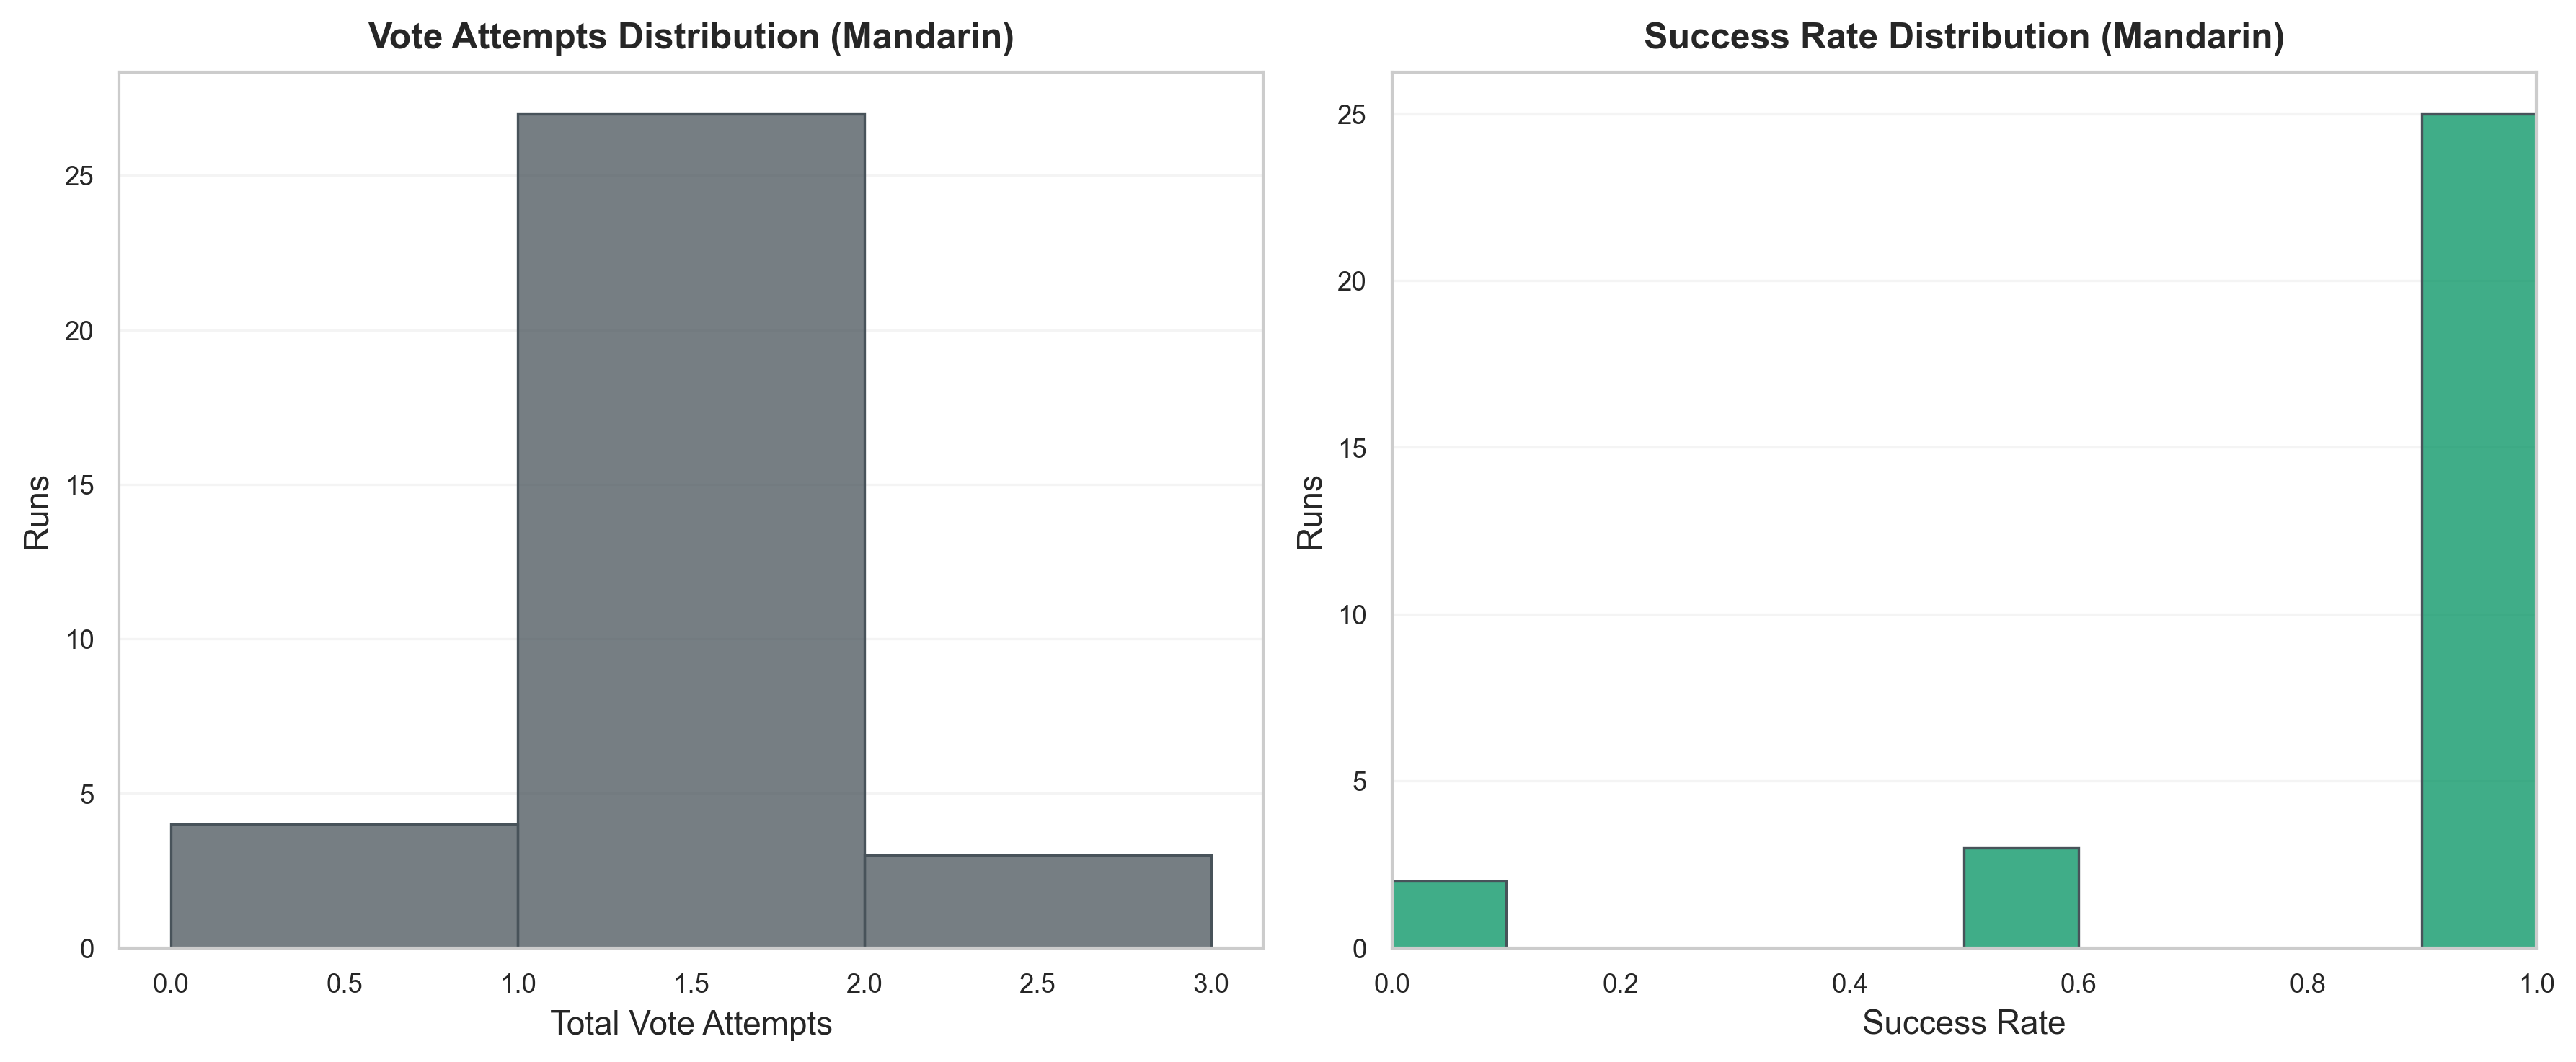

Voting Attempts Summary:
  Mean attempts per run: 0.97
  Median attempts per run: 1
  Mean success rate: 88.33%
  Median success rate: 100.00%


### Preference Evolution and Transitions

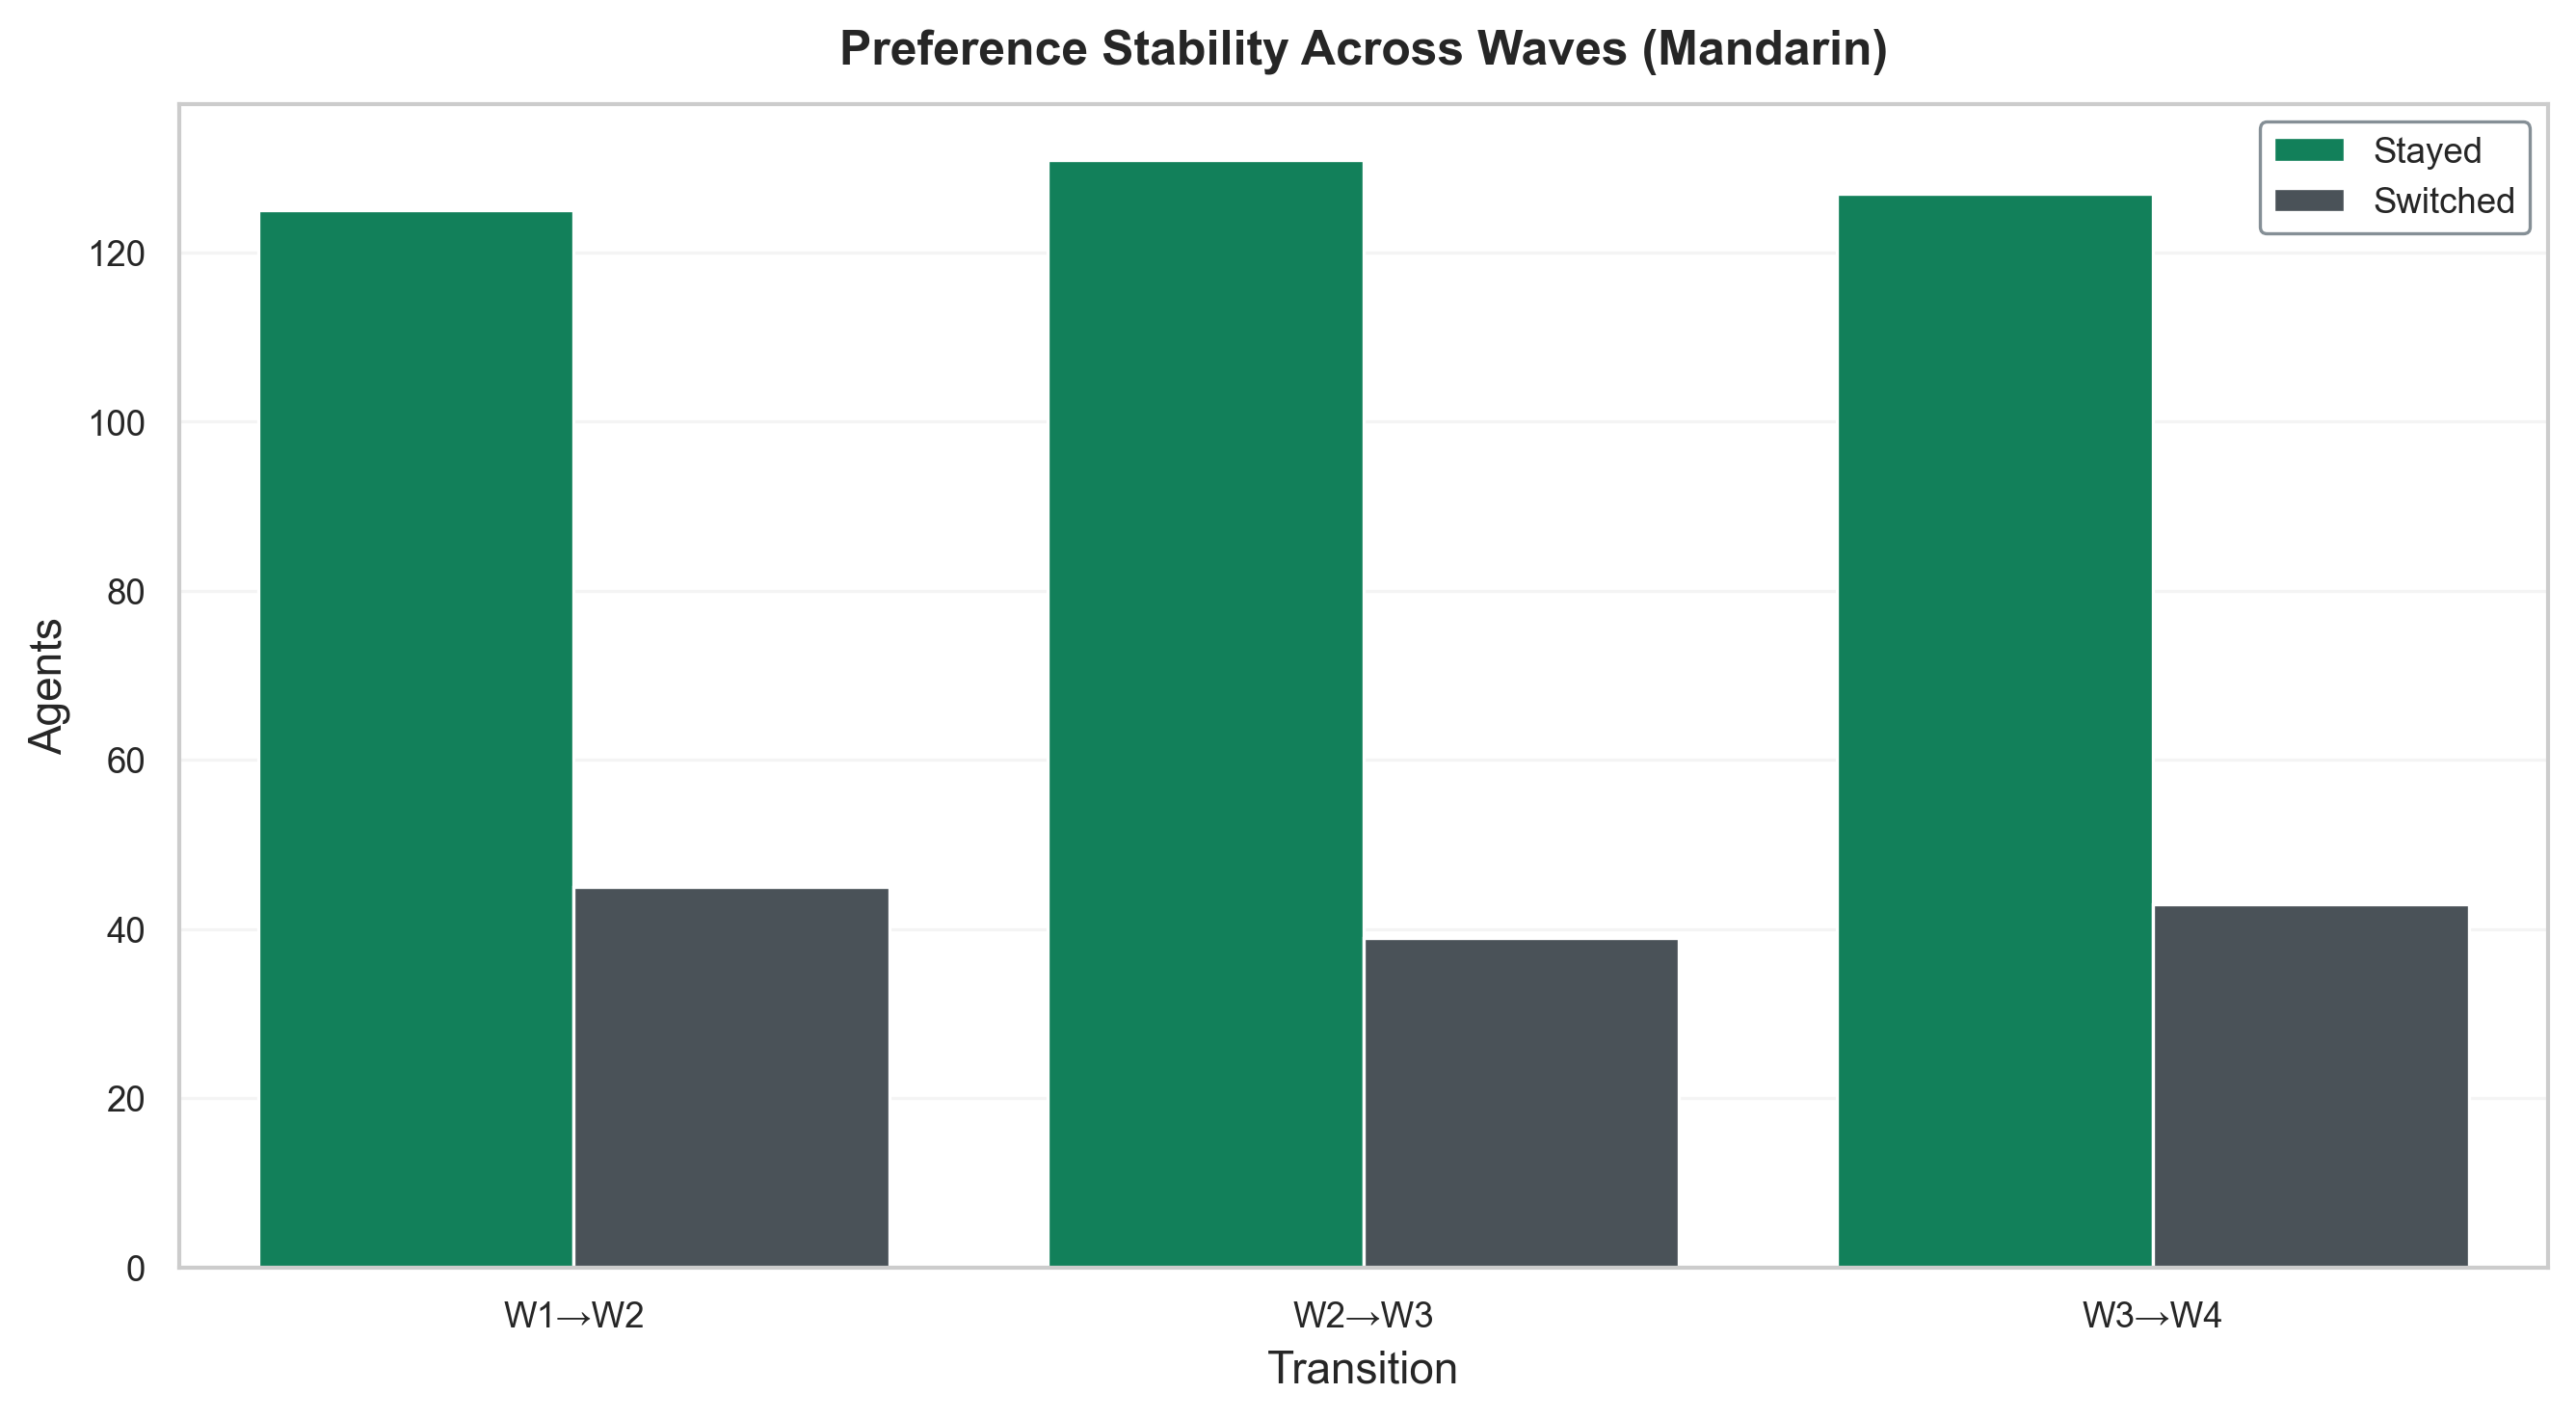

Stability Breakdown:
  W1→W2: 125/170 stayed (73.5%)
  W2→W3: 131/170 stayed (77.1%)
  W3→W4: 127/170 stayed (74.7%)


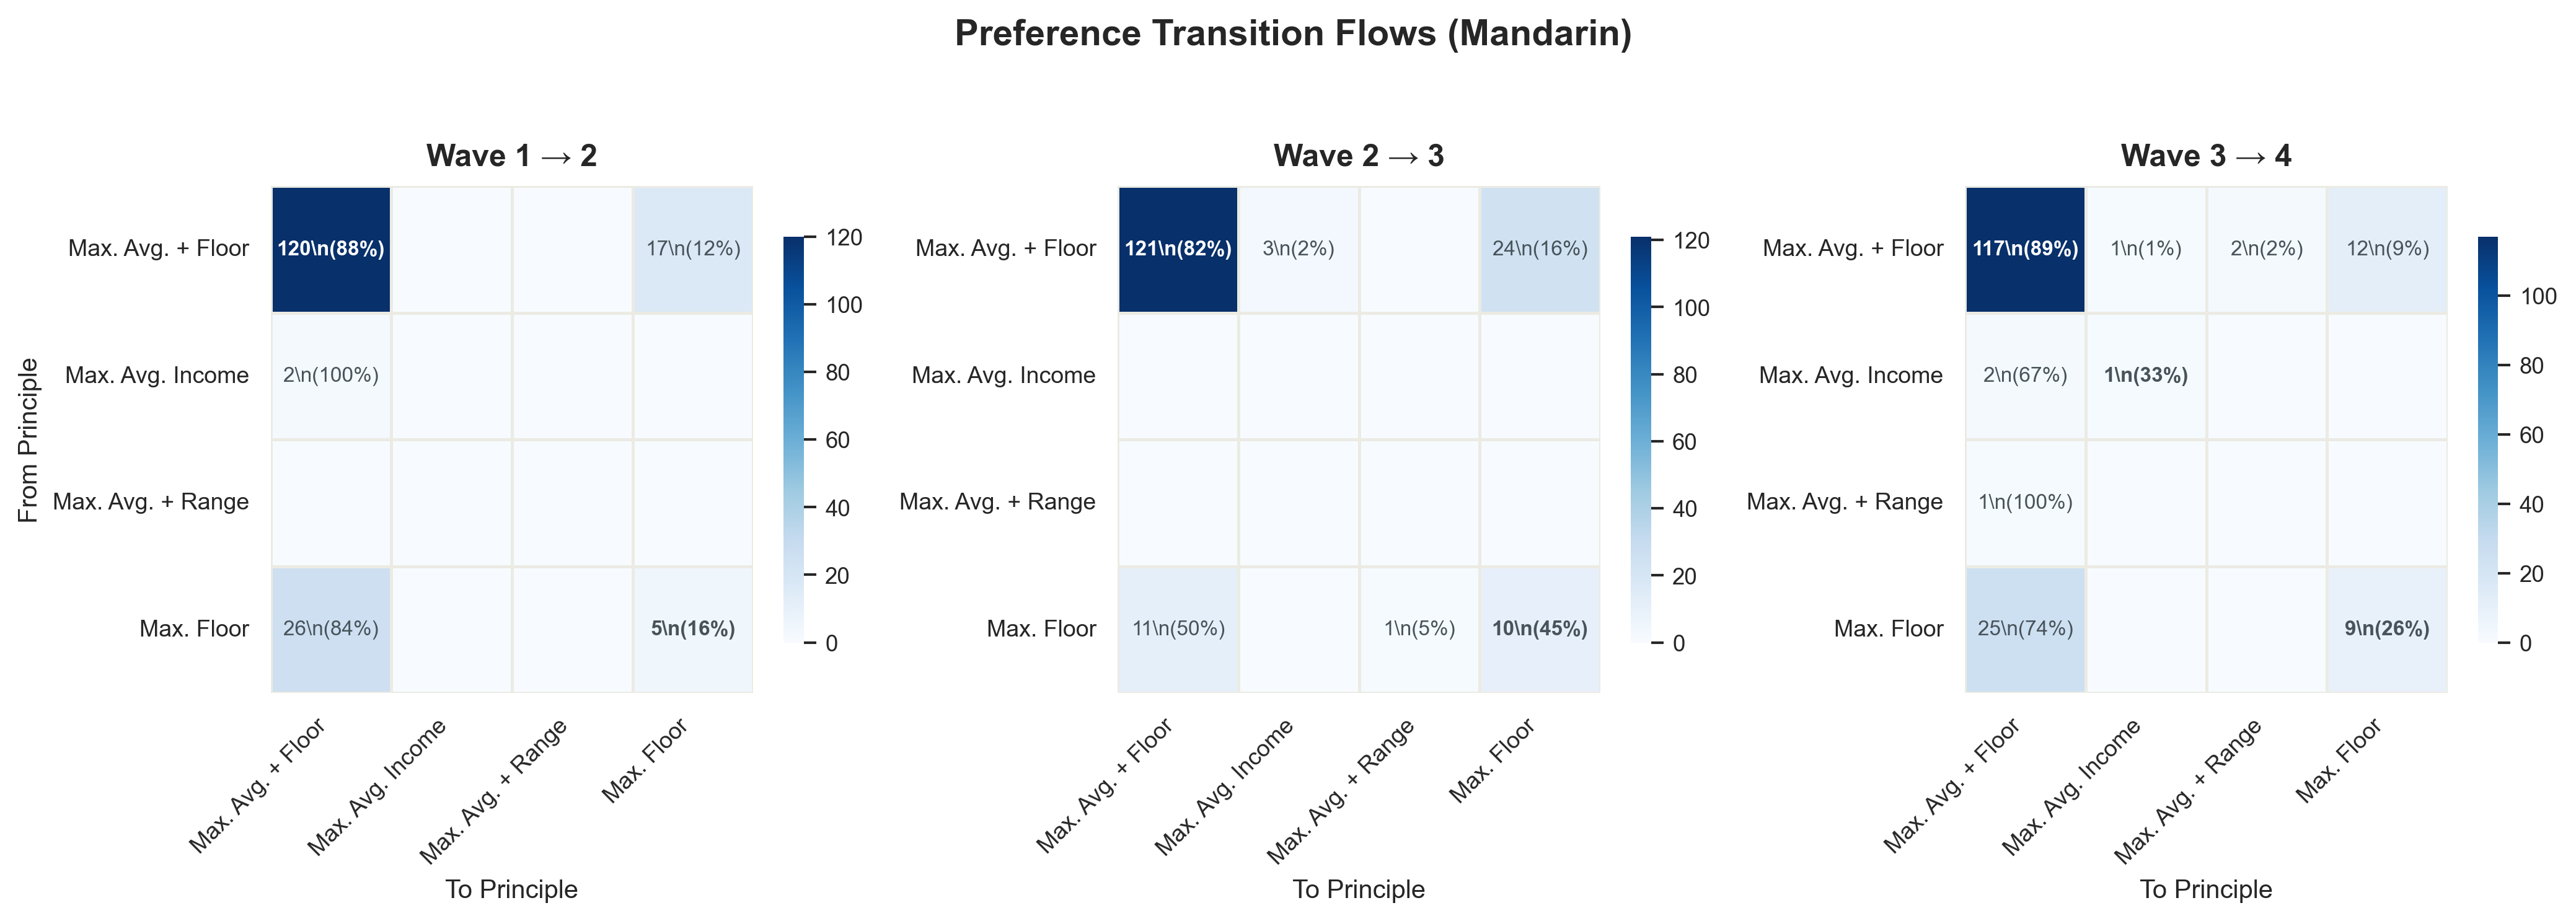

Transition Stay Rates:
  Wave 1 → 2: 125/170 stayed (73.5%)
  Wave 2 → 3: 131/170 stayed (77.1%)
  Wave 3 → 4: 127/170 stayed (74.7%)


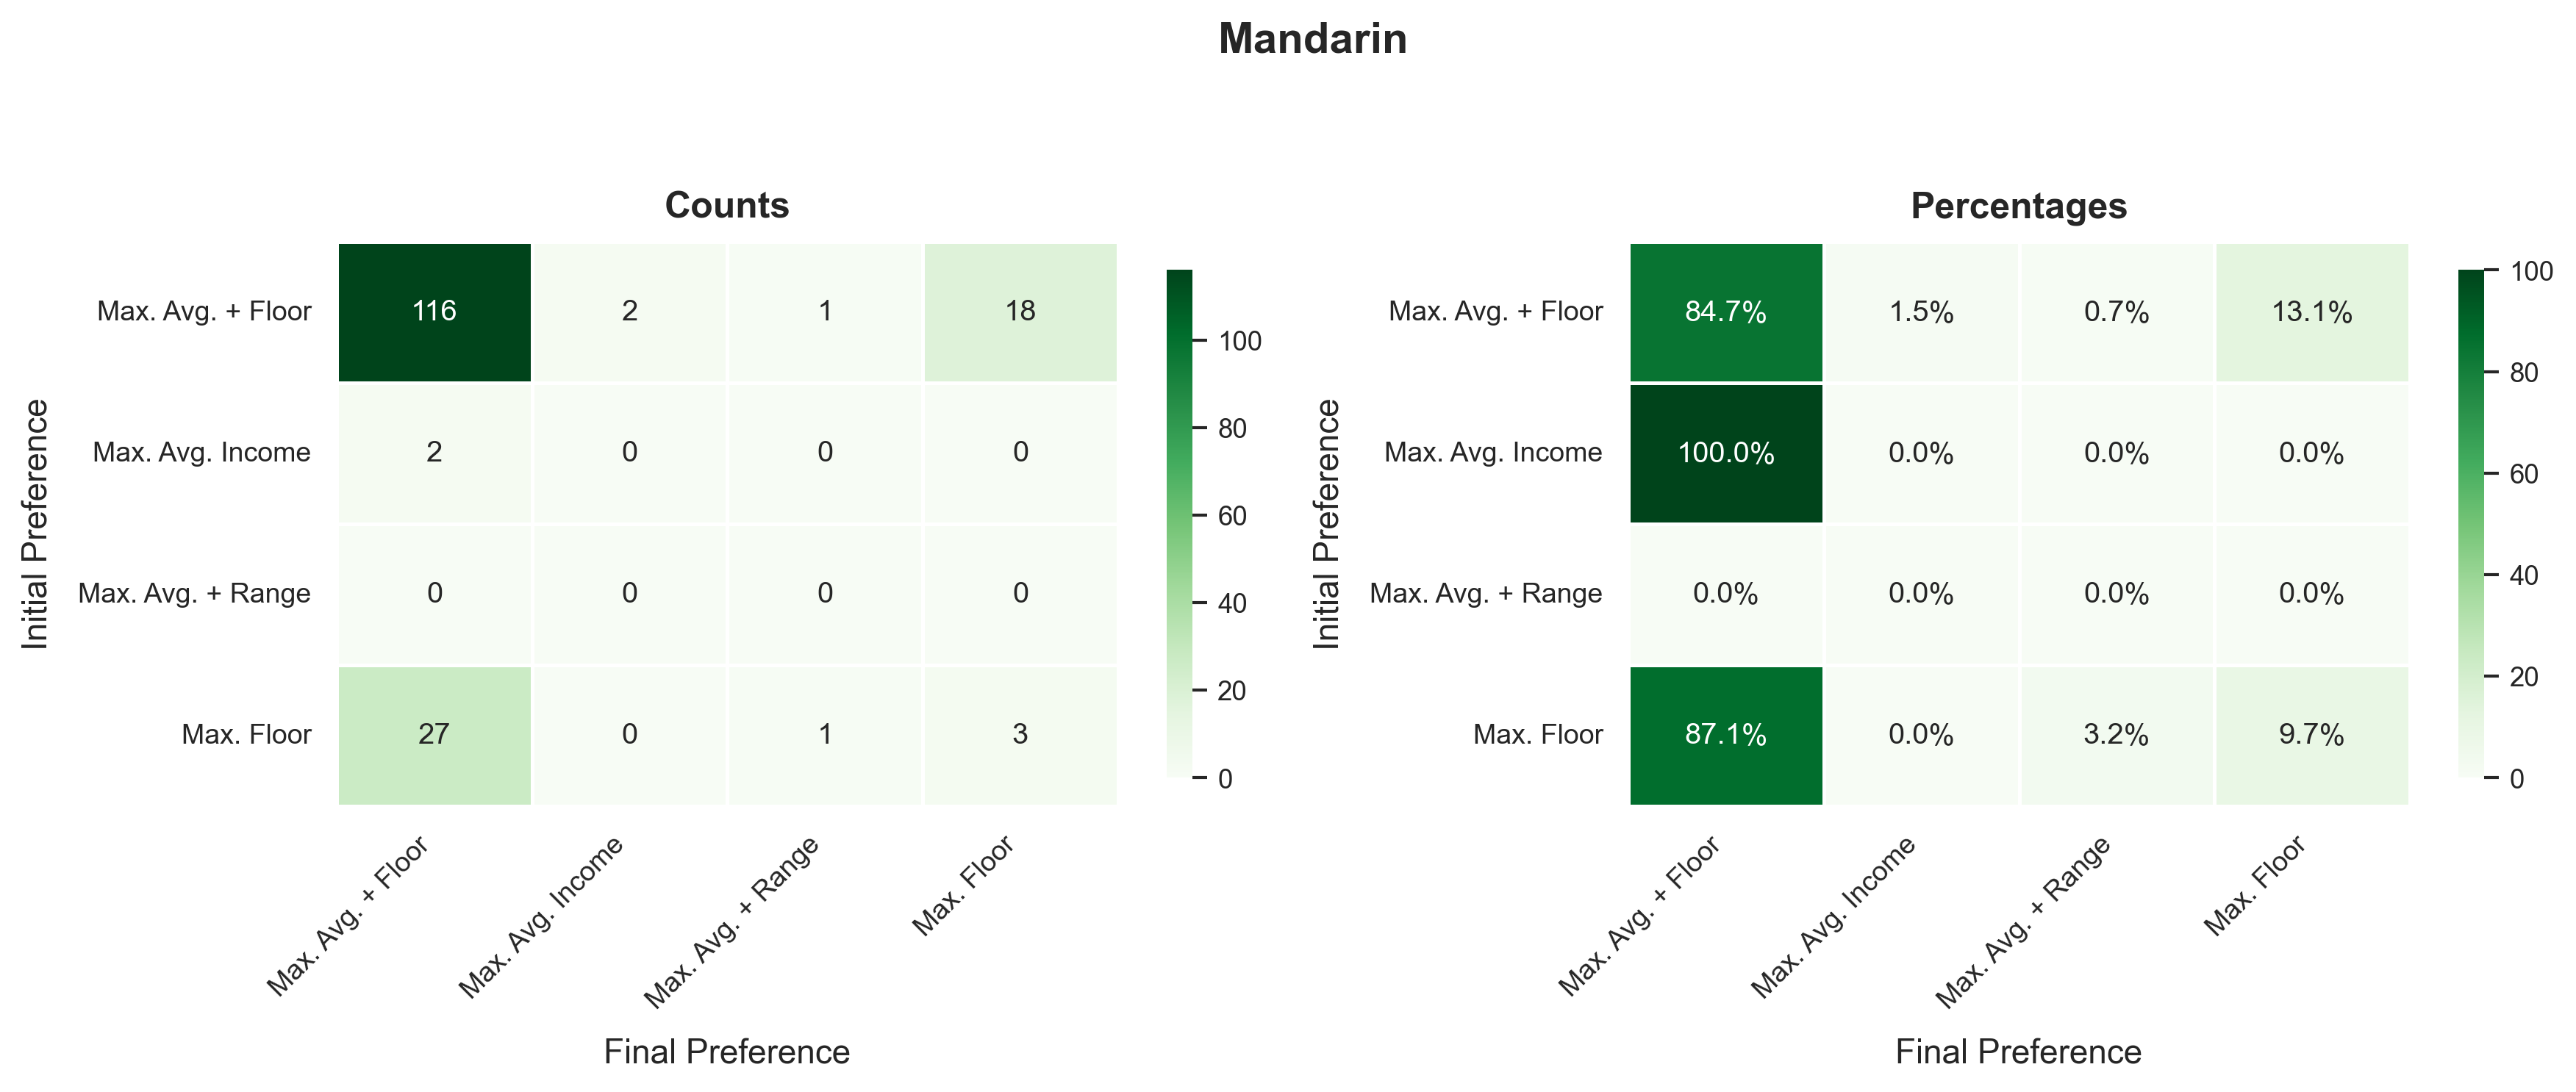

Long-Term Stability (Wave 1 → Wave 4) [Mandarin]
Max. Avg. + Floor        : 116/137 maintained ( 84.7%)
Max. Avg. Income         :   0/  2 maintained (  0.0%)
Max. Avg. + Range        :   0/  0 maintained (  0.0%)
Max. Floor               :   3/ 31 maintained (  9.7%)
OVERALL                  : 119/170 agents ( 70.0%)


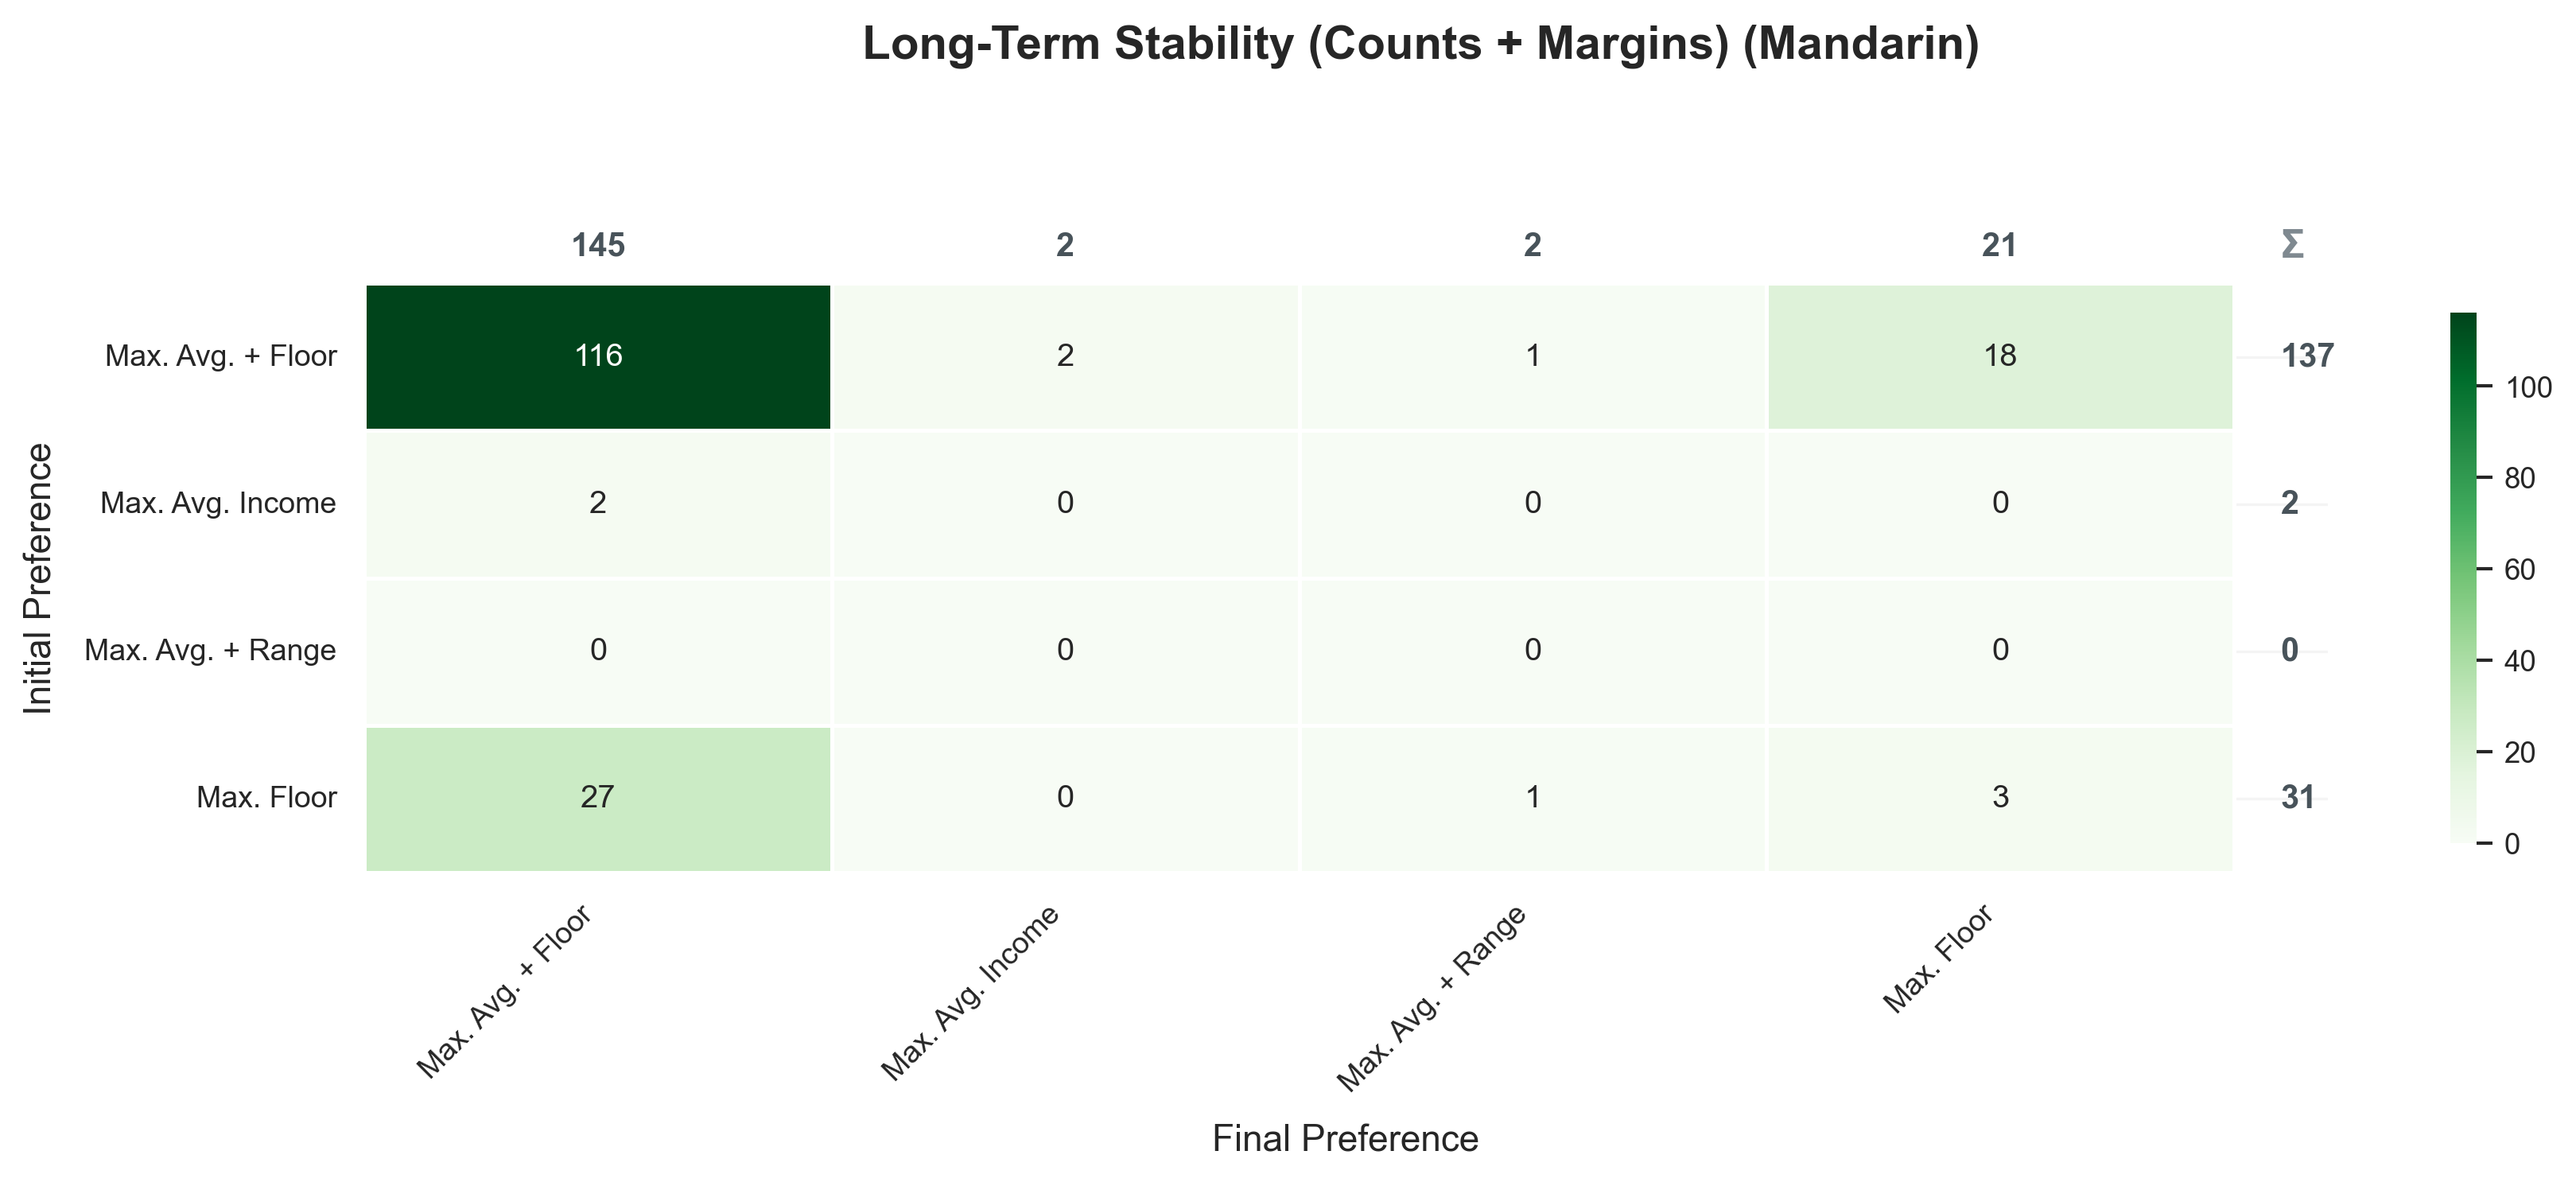

### Switcher Analysis: Income Class and Preference Changes

/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_34034/2101704904.py:358: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_long.pivot_table(


Income Class  Changed Preference  Maintained Preference  Total Agents  \
0          Low                  10                     11            21   
1       Medium                  37                     48            85   
2         High                   5                      3             8   
3      Unknown                  32                     24            56   

   Changed Share (%)  Maintained Share (%)  
0               47.6                  52.4  
1               43.5                  56.5  
2               62.5                  37.5  
3               57.1                  42.9

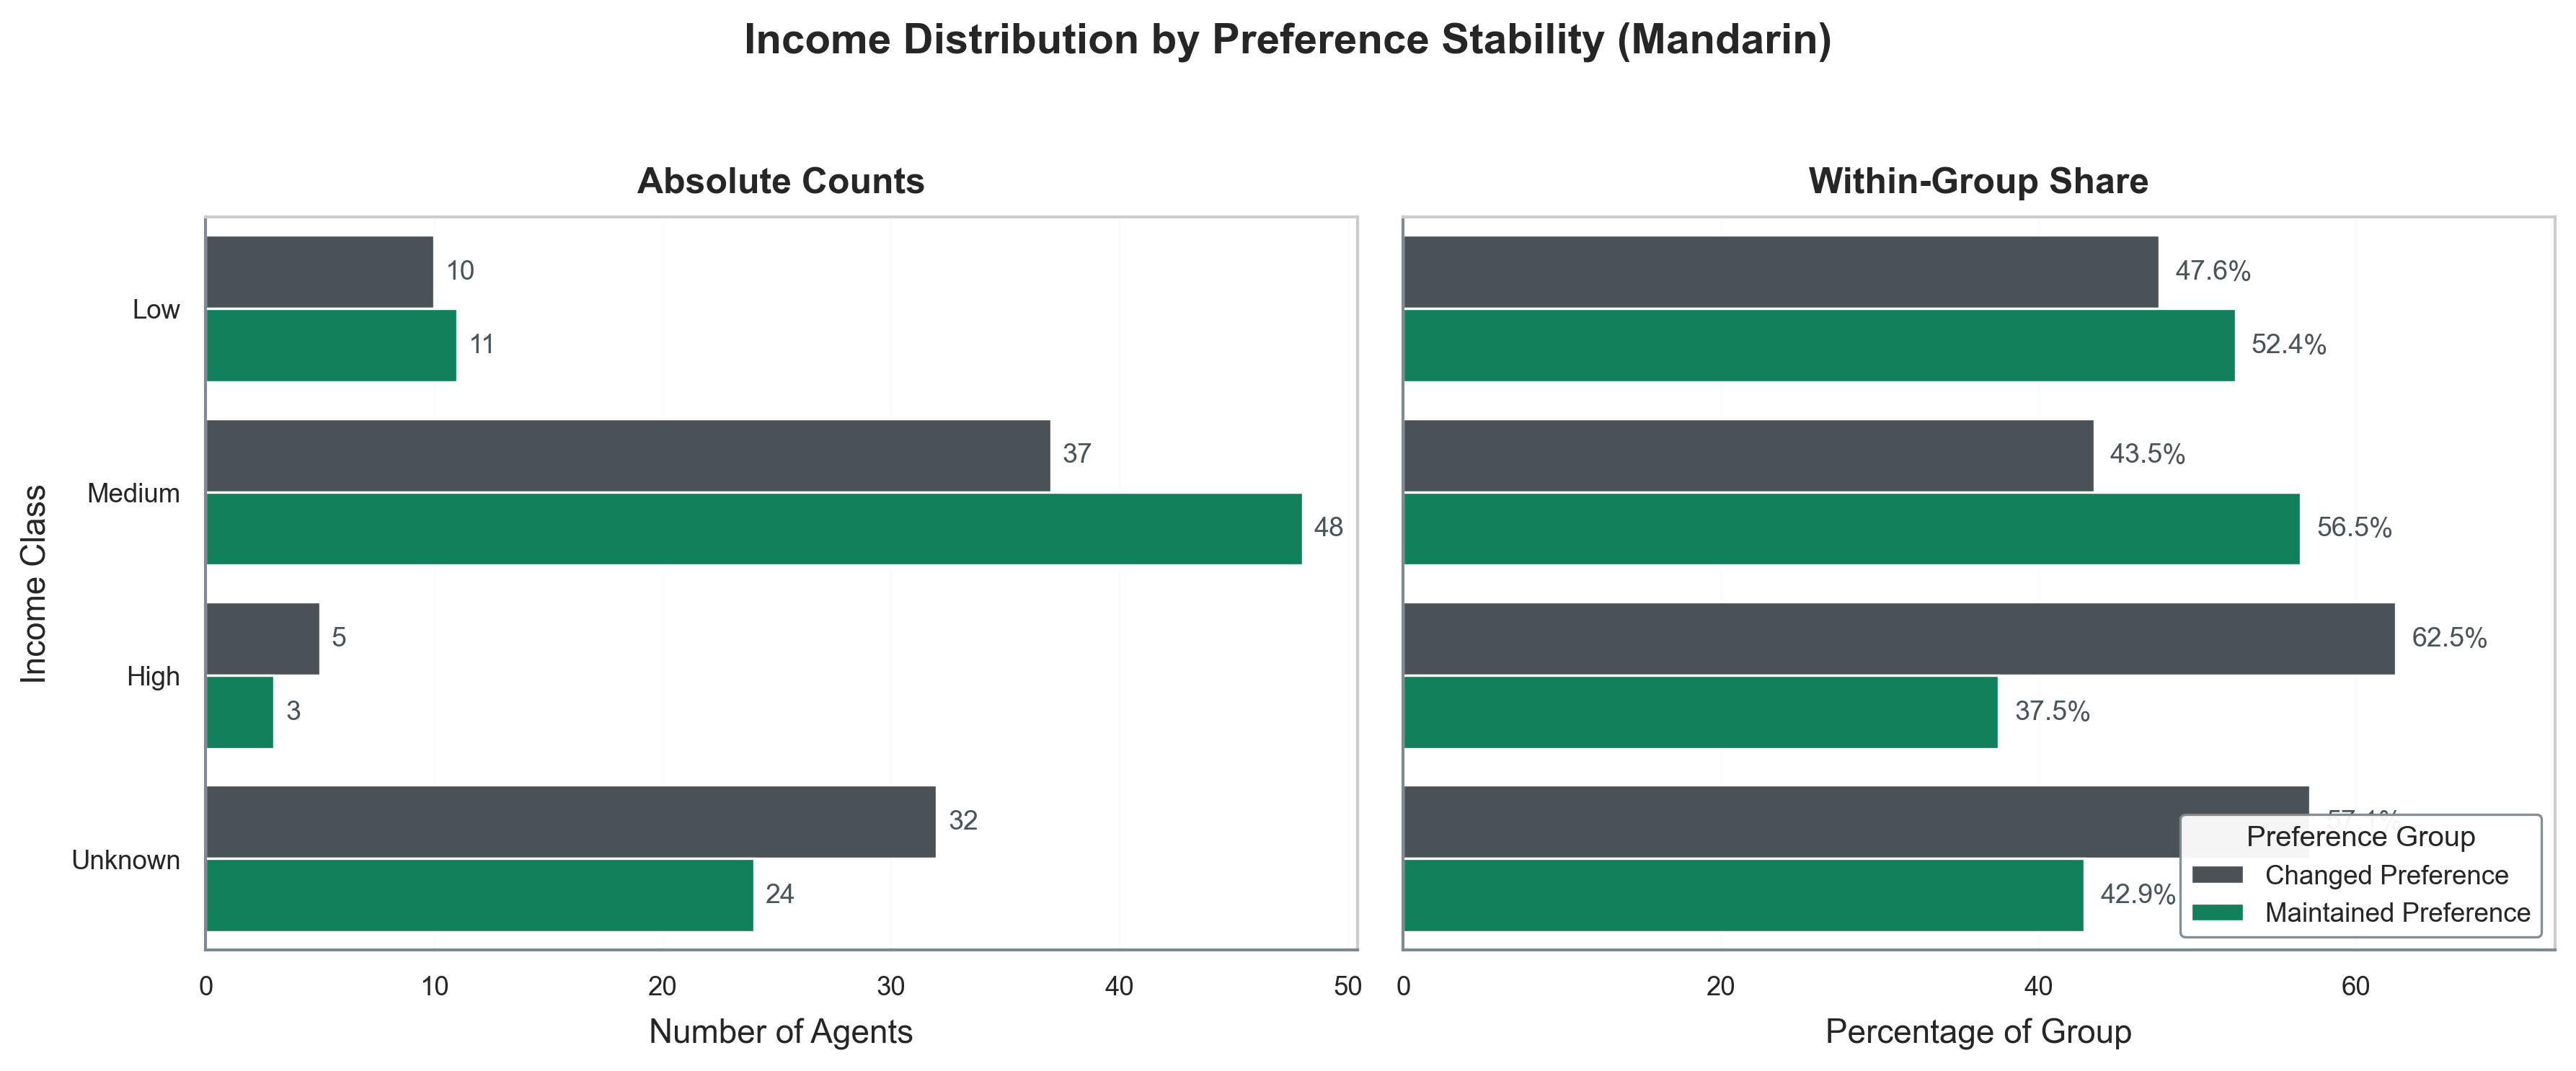

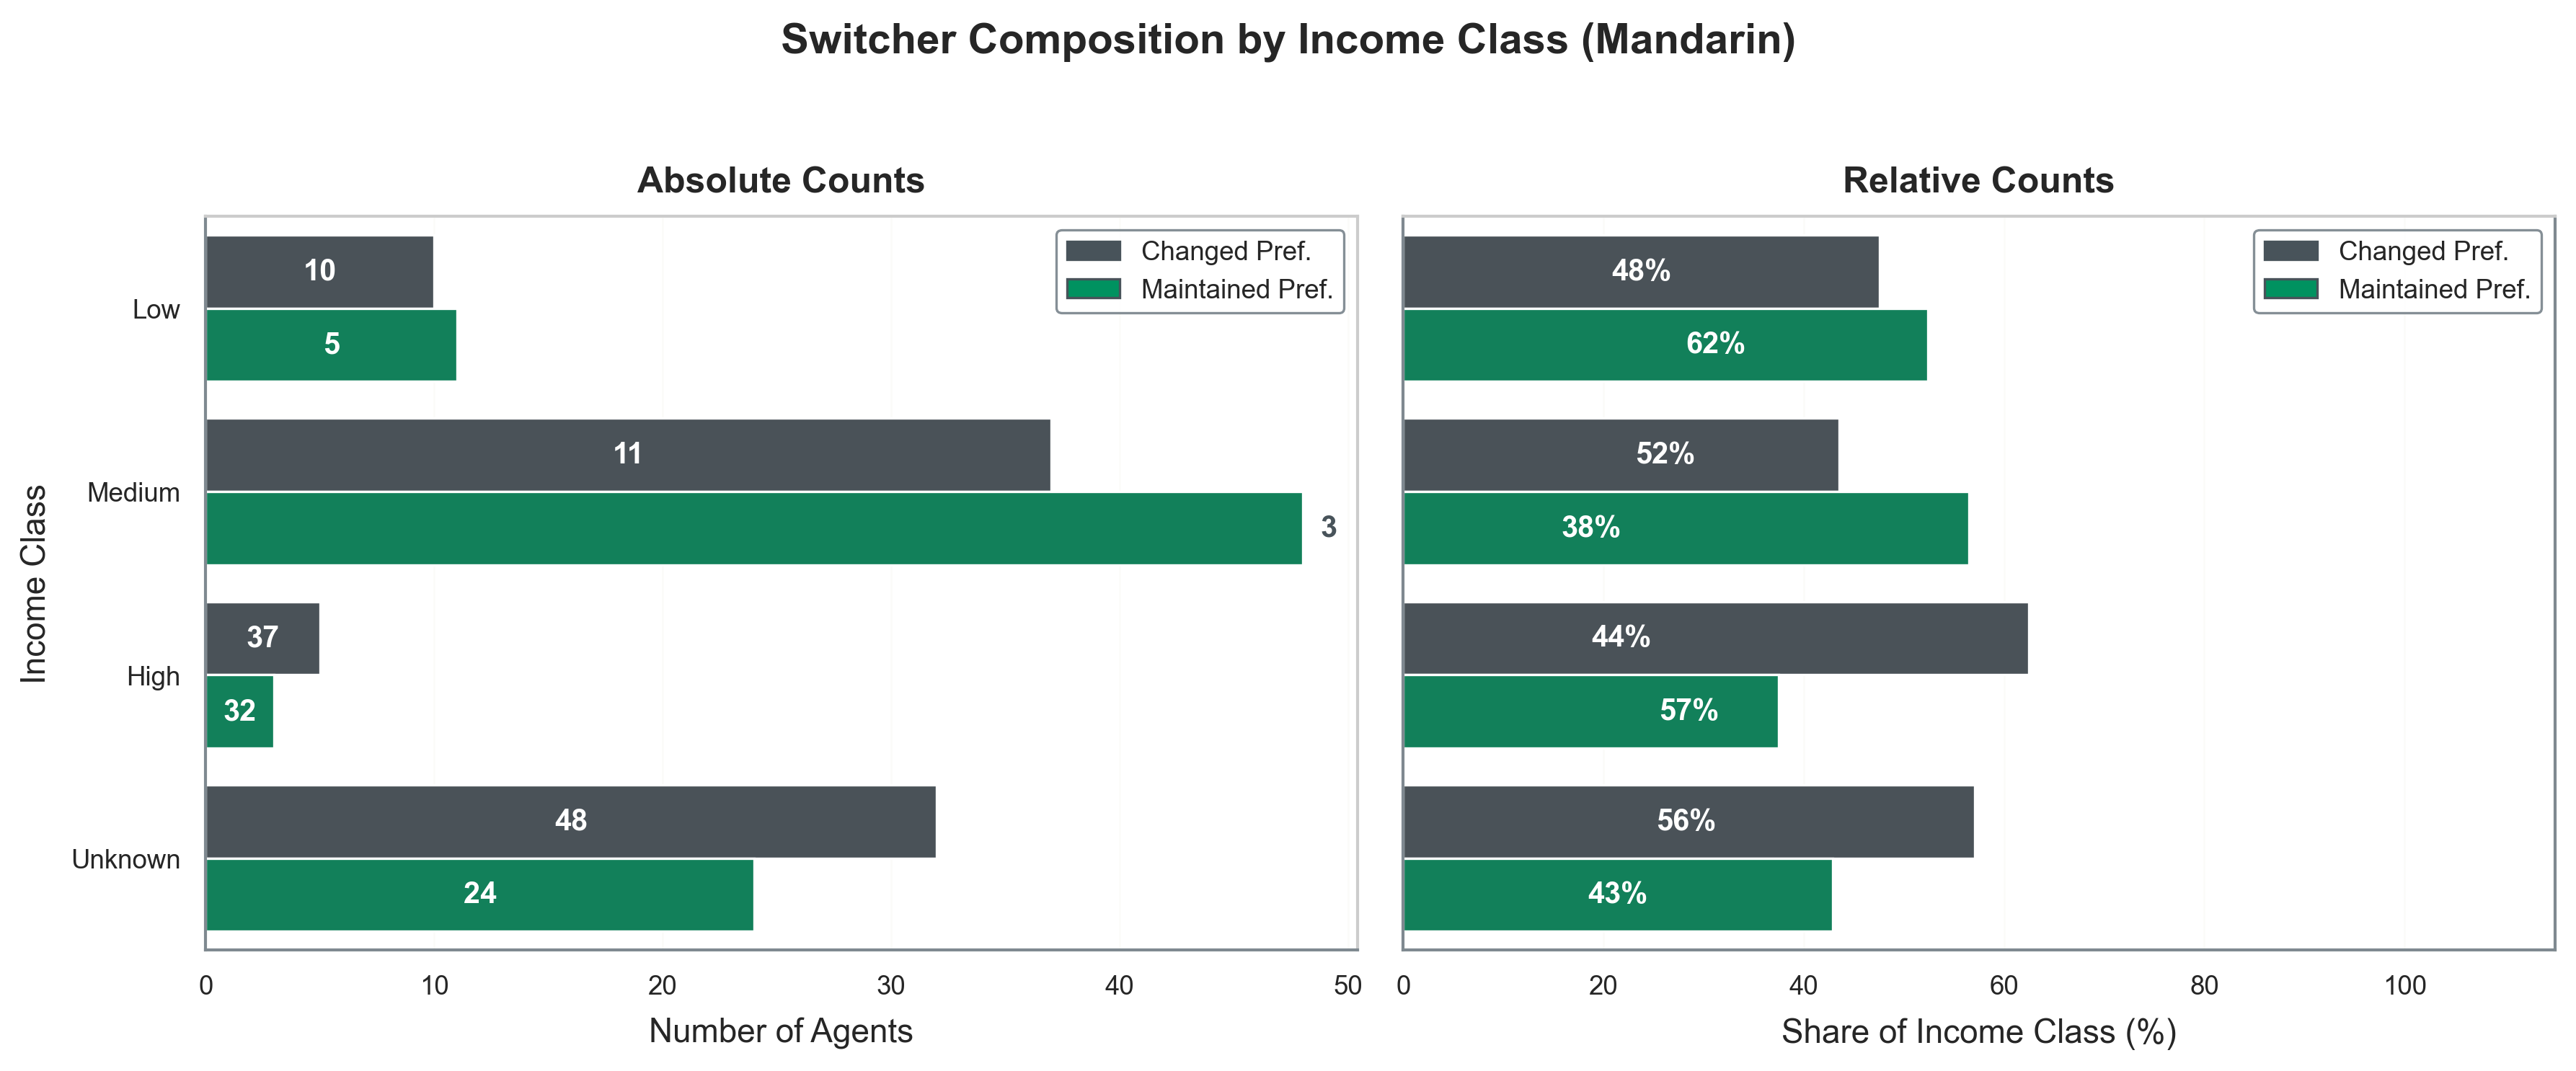

In [7]:

# Run full descriptive workflow per cohort

for label, dataset in group_datasets.items():
    display(Markdown(f"## {label} Cohort"))

    # Data summary
    display(Markdown("### Data Summary"))
    num_runs = dataset.run_metrics.shape[0]
    consensus_runs = dataset.run_metrics[dataset.run_metrics["consensus_reached"] == True].shape[0]
    unique_agents = dataset.ranking_top[["run_id", "agent"]].drop_duplicates().shape[0]
    num_waves = dataset.ranking_top["wave_label"].nunique()
    summary_df = pd.DataFrame(
        {
            "Metric": ["Runs", "Consensus runs", "Agent sessions", "Preference waves"],
            "Value": [num_runs, consensus_runs, unique_agents, num_waves],
        }
    )
    display(summary_df)
    if dataset.transition_meta:
        total = dataset.transition_meta.get("total_agents", 0)
        complete = dataset.transition_meta.get("complete_cases", 0)
        print(f"Transition coverage: {complete}/{total} agents with full wave data")

    # Preference orderings
    display(Markdown("### Preference Orderings by Wave"))
    for wave_name in WAVE_ORDER:
        display(Markdown(f"**{wave_name}**"))
        table = create_preference_ordering_table(dataset.ranking_long, wave_name)
        display(table)

    # Rounds to outcome
    display(Markdown("### Rounds to Outcome"))
    plot_rounds_to_outcome(
        dataset.run_metrics,
        title_suffix=label,
    )

    # Floor constraints
    display(Markdown("### Floor Constraint Amounts"))
    plot_floor_constraint_distribution(
        dataset.vote_rounds,
        title_suffix=label,
    )

    # Voting attempts
    display(Markdown("### Voting Attempts and Success Rate"))
    plot_voting_attempts_summary(
        dataset.run_metrics,
        title_suffix=label,
    )

    # Preference transitions
    display(Markdown("### Preference Evolution and Transitions"))
    plot_preference_stability(
        dataset.transition_data,
        title_suffix=label,
    )
    plot_transition_heatmaps(
        dataset.transition_data,
        principle_display_order=PRINCIPLE_DISPLAY_ORDER,
        format_principle_label=format_principle_label,
        title_suffix=label,
    )
    plot_long_term_stability(
        dataset.transition_data,
        principle_order=PRINCIPLE_ORDER,
        principle_display_order=PRINCIPLE_DISPLAY_ORDER,
        format_principle_label=format_principle_label,
        title_suffix=label,
        title=label,
    )
    plot_long_term_margin(
        dataset.transition_data,
        principle_display_order=PRINCIPLE_DISPLAY_ORDER,
        format_principle_label=format_principle_label,
        title_suffix=label,
    )

    # Switcher analysis
    display(Markdown("### Switcher Analysis: Income Class and Preference Changes"))
    if dataset.switcher_analysis is None or dataset.switcher_analysis.empty:
        print("No switcher data available for this cohort.")
    else:
        switcher_summary, count_long, percent_long, composition_percent_long = summarize_income_preferences(dataset.switcher_analysis)
        display(switcher_summary)
        plot_income_preference_bars(
            switcher_summary,
            count_long,
            percent_long,
            title_suffix=label,
        )
        plot_income_composition(
            count_long,
            composition_percent_long,
            title_suffix=label,
        )


In [8]:

# Cross-cohort comparison of final top choices

final_choice_records: List[Dict[str, Any]] = []
for label, dataset in group_datasets.items():
    if dataset.transition_data is None or dataset.transition_data.empty:
        continue
    final_wave = dataset.transition_data["wave4"].map(format_principle_label)
    counts = final_wave.value_counts()
    total = counts.sum()
    for principle, count in counts.items():
        final_choice_records.append({
            "Cohort": label,
            "Top Principle": principle,
            "Agents": int(count),
            "Share %": round(count / total * 100, 1) if total else np.nan,
        })

final_choice_df = pd.DataFrame(final_choice_records).sort_values(["Top Principle", "Cohort"])

display(Markdown("### Final Wave Top-Choice Distribution"))
display(final_choice_df)


### Final Wave Top-Choice Distribution

Cohort      Top Principle  Agents  Share %
0    English  Max. Avg. + Floor     155     91.2
8   Mandarin  Max. Avg. + Floor     145     85.3
4    Spanish  Max. Avg. + Floor     116     68.2
2    English  Max. Avg. + Range       3      1.8
10  Mandarin  Max. Avg. + Range       2      1.2
5    Spanish  Max. Avg. + Range      38     22.4
3    English   Max. Avg. Income       3      1.8
11  Mandarin   Max. Avg. Income       2      1.2
7    Spanish   Max. Avg. Income       2      1.2
1    English         Max. Floor       9      5.3
9   Mandarin         Max. Floor      21     12.4
6    Spanish         Max. Floor      14      8.2

## Direct Comparison

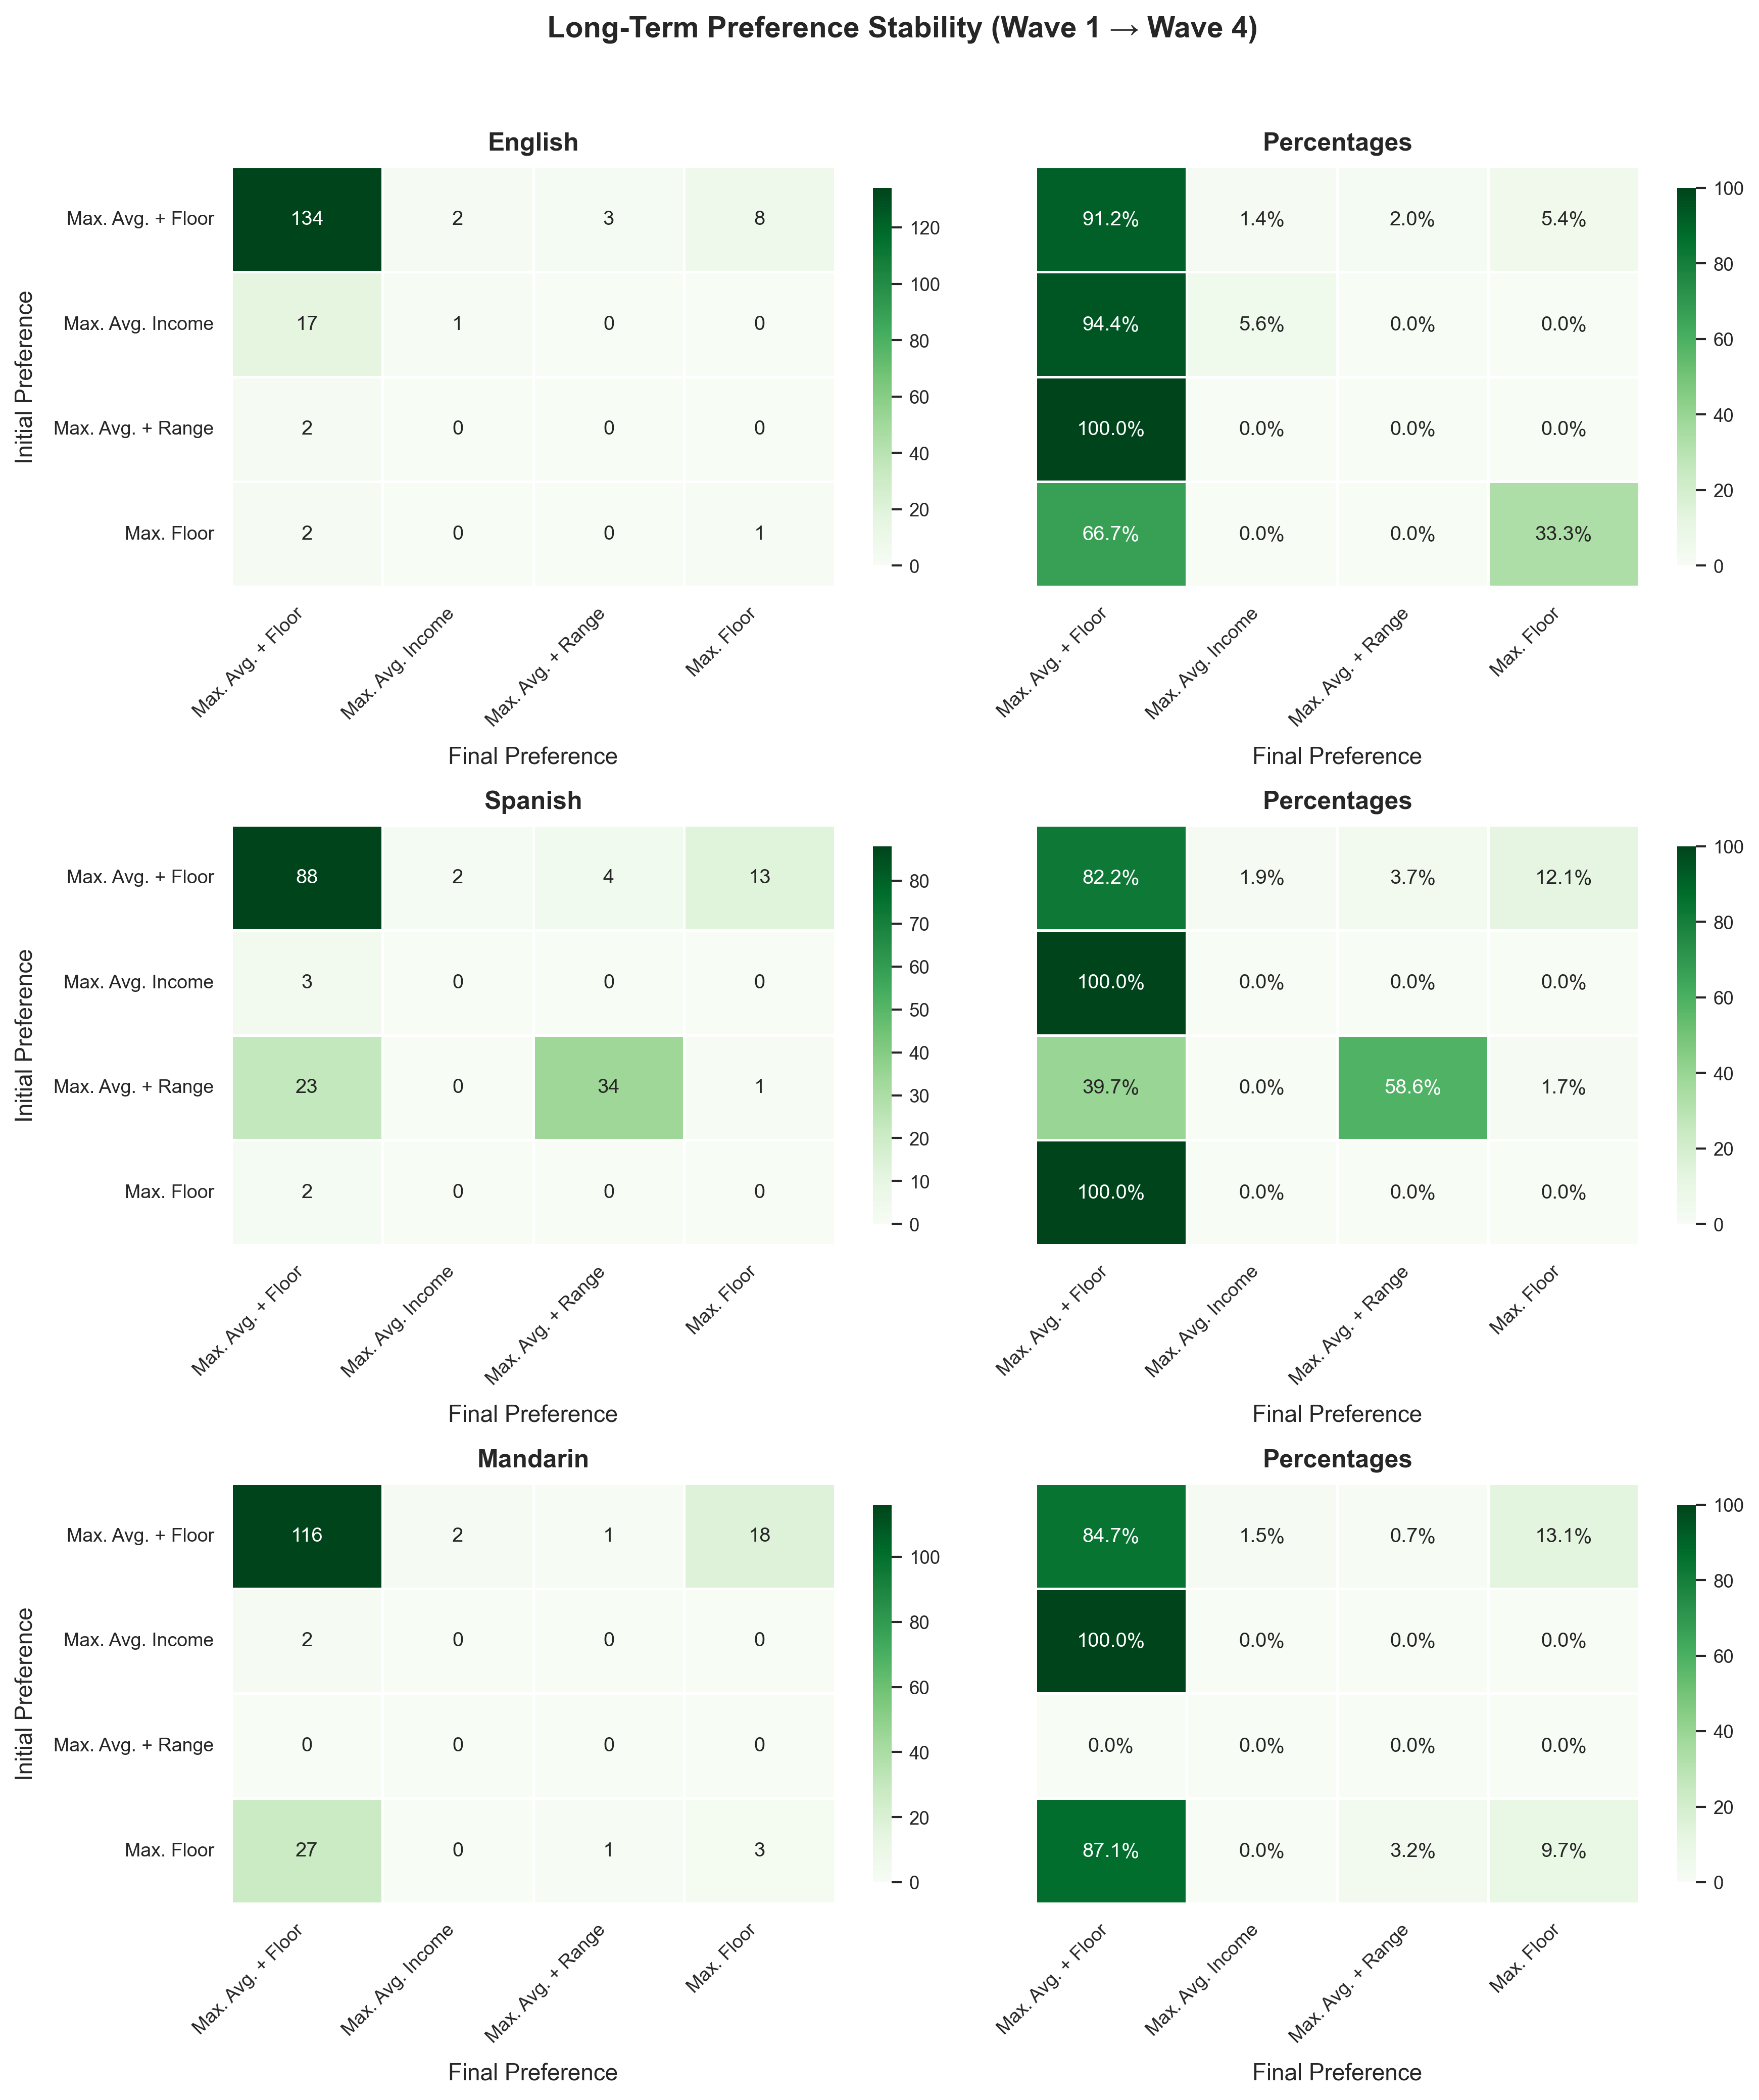

In [9]:
comparison_data = [
    (label, dataset.transition_data)
    for label, dataset in group_datasets.items()
]

plot_long_term_stability_grid(
    comparison_data,
    principle_order=PRINCIPLE_ORDER,
    principle_display_order=PRINCIPLE_DISPLAY_ORDER,
    format_principle_label=format_principle_label,
    title="Long-Term Preference Stability (Wave 1 → Wave 4)",
)


### Counts-Only Comparison

/Users/lucasmuller/Desktop/Githubg/Rawls_v3/hypothesis_testing/utils_hypothesis_testing/visualizations.py:1623: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.93 if colorbar_mode == "shared" else 1, 1])


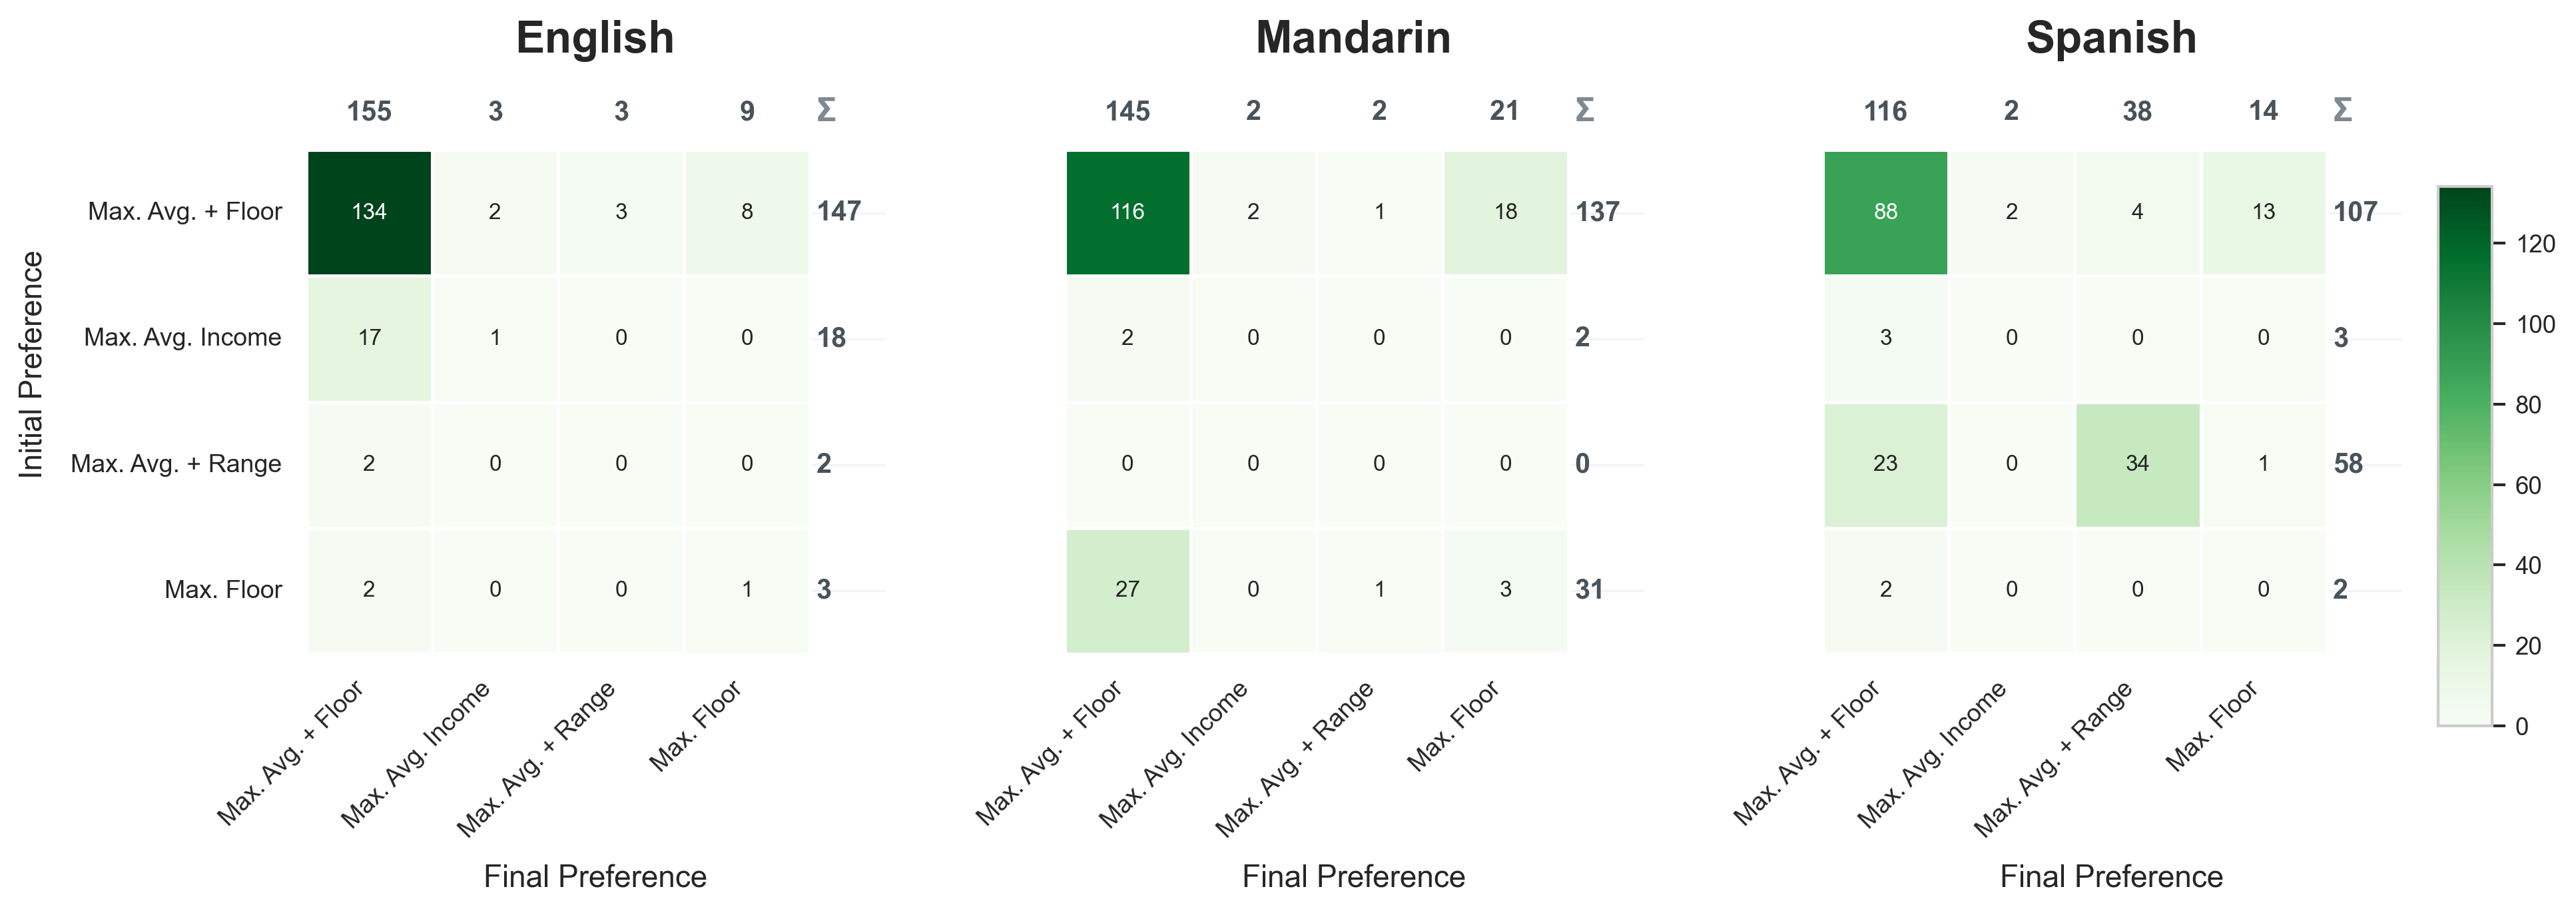

In [10]:
ordered_languages = ["English", "Mandarin", "Spanish"]
counts_only_data = [
    (label, group_datasets[label].transition_data if label in group_datasets else None)
    for label in ordered_languages
]

plot_long_term_counts_grid(
    counts_only_data,
    principle_display_order=PRINCIPLE_DISPLAY_ORDER,
    format_principle_label=format_principle_label,
    orientation="horizontal",
    axis_title_fontsize=16,

    colorbar_mode="shared",
)




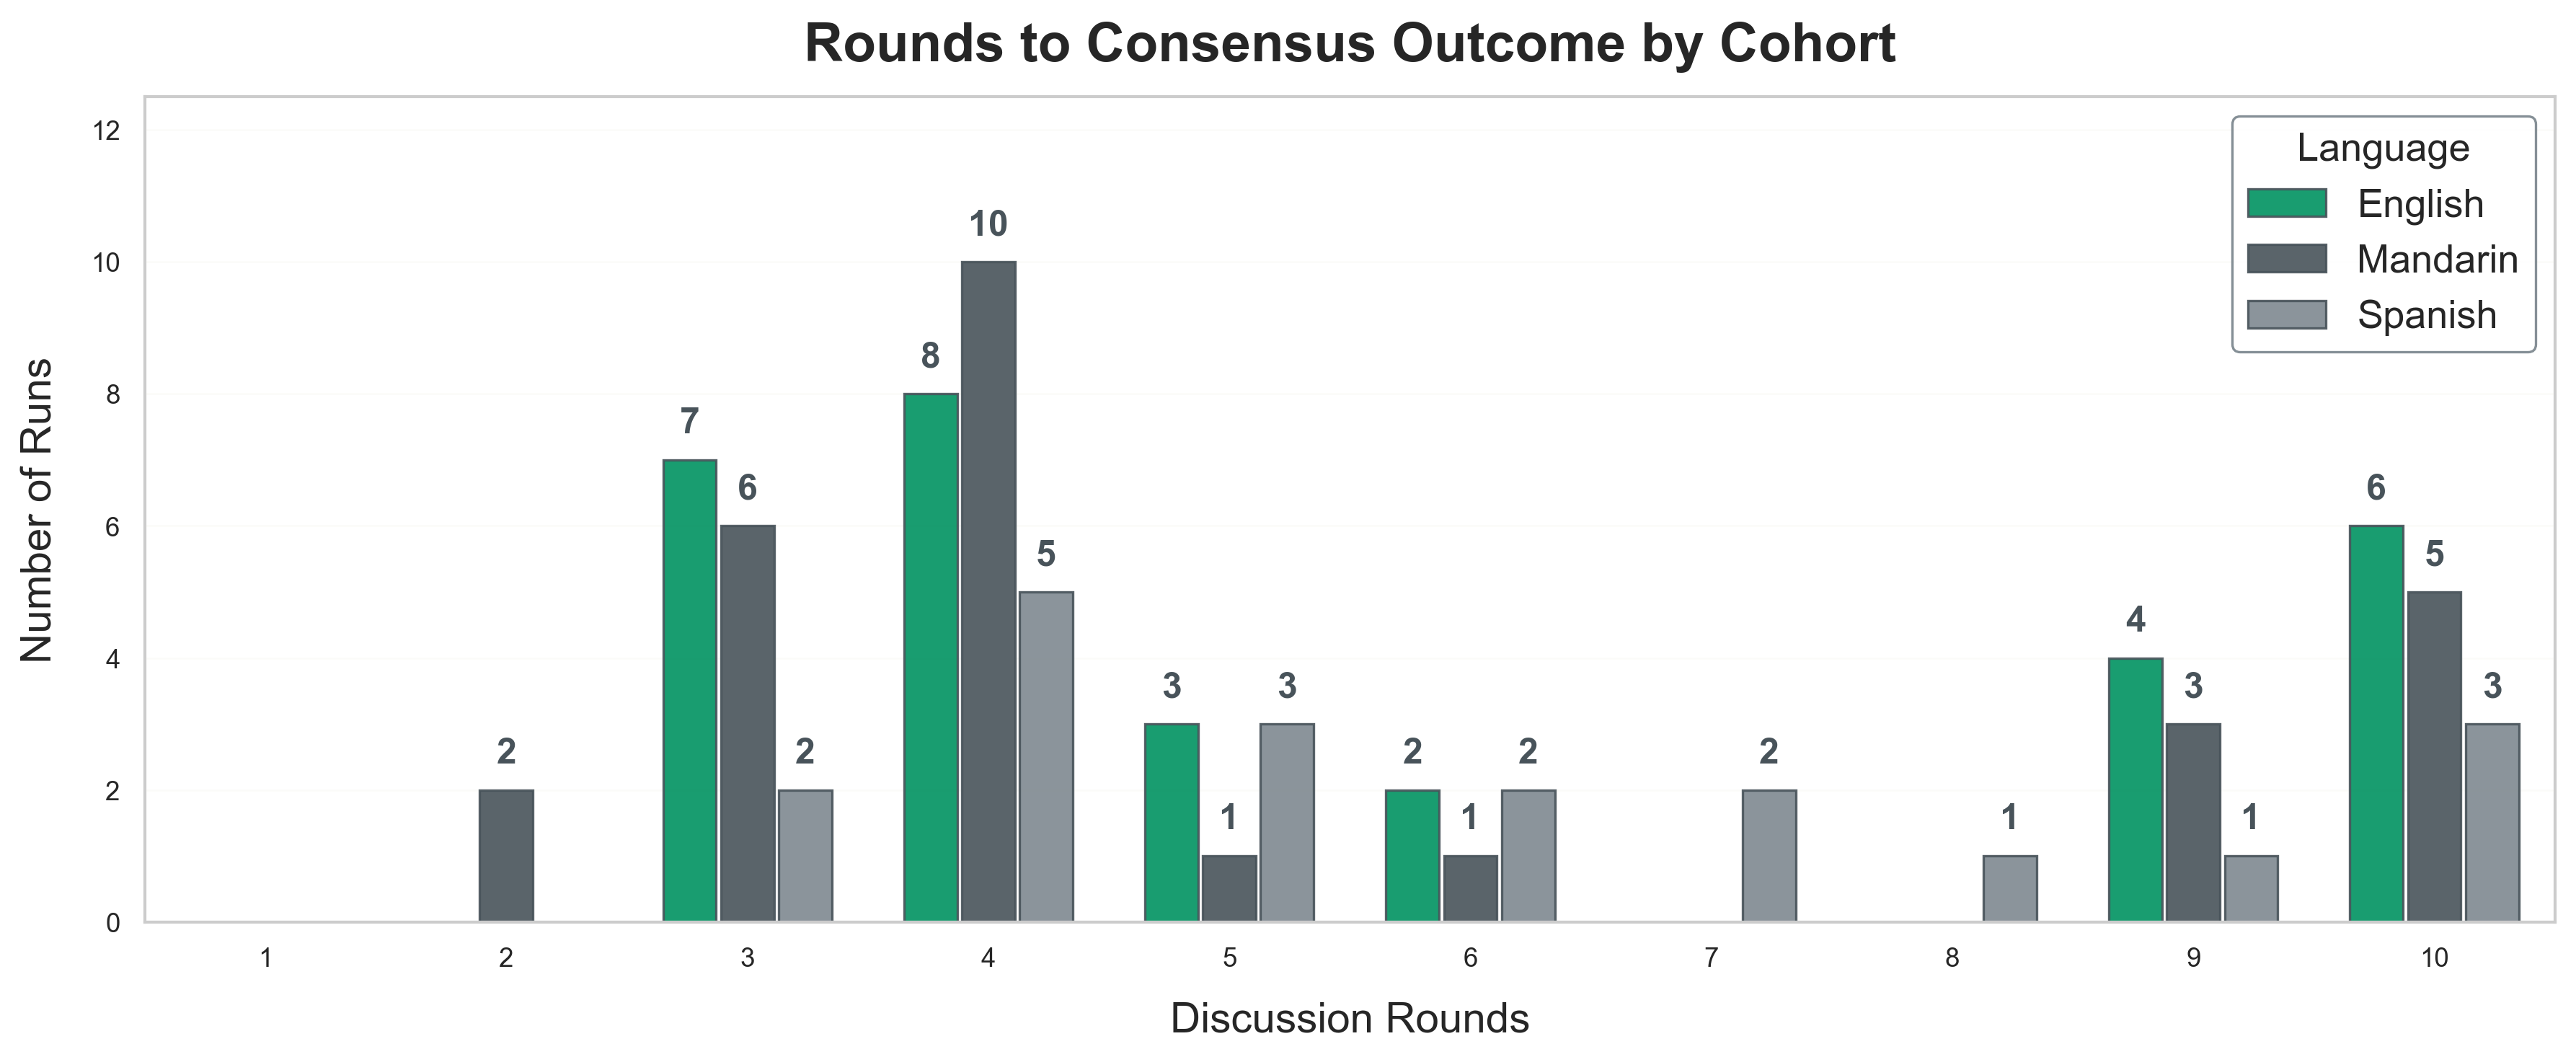

In [11]:
grouped_rounds_data = [
    (label, group_datasets[label].run_metrics if label in group_datasets else None)
    for label in ordered_languages
]

plot_rounds_to_outcome_grouped(
    grouped_rounds_data,
    language_order=ordered_languages,
    font_scale=1.3
)


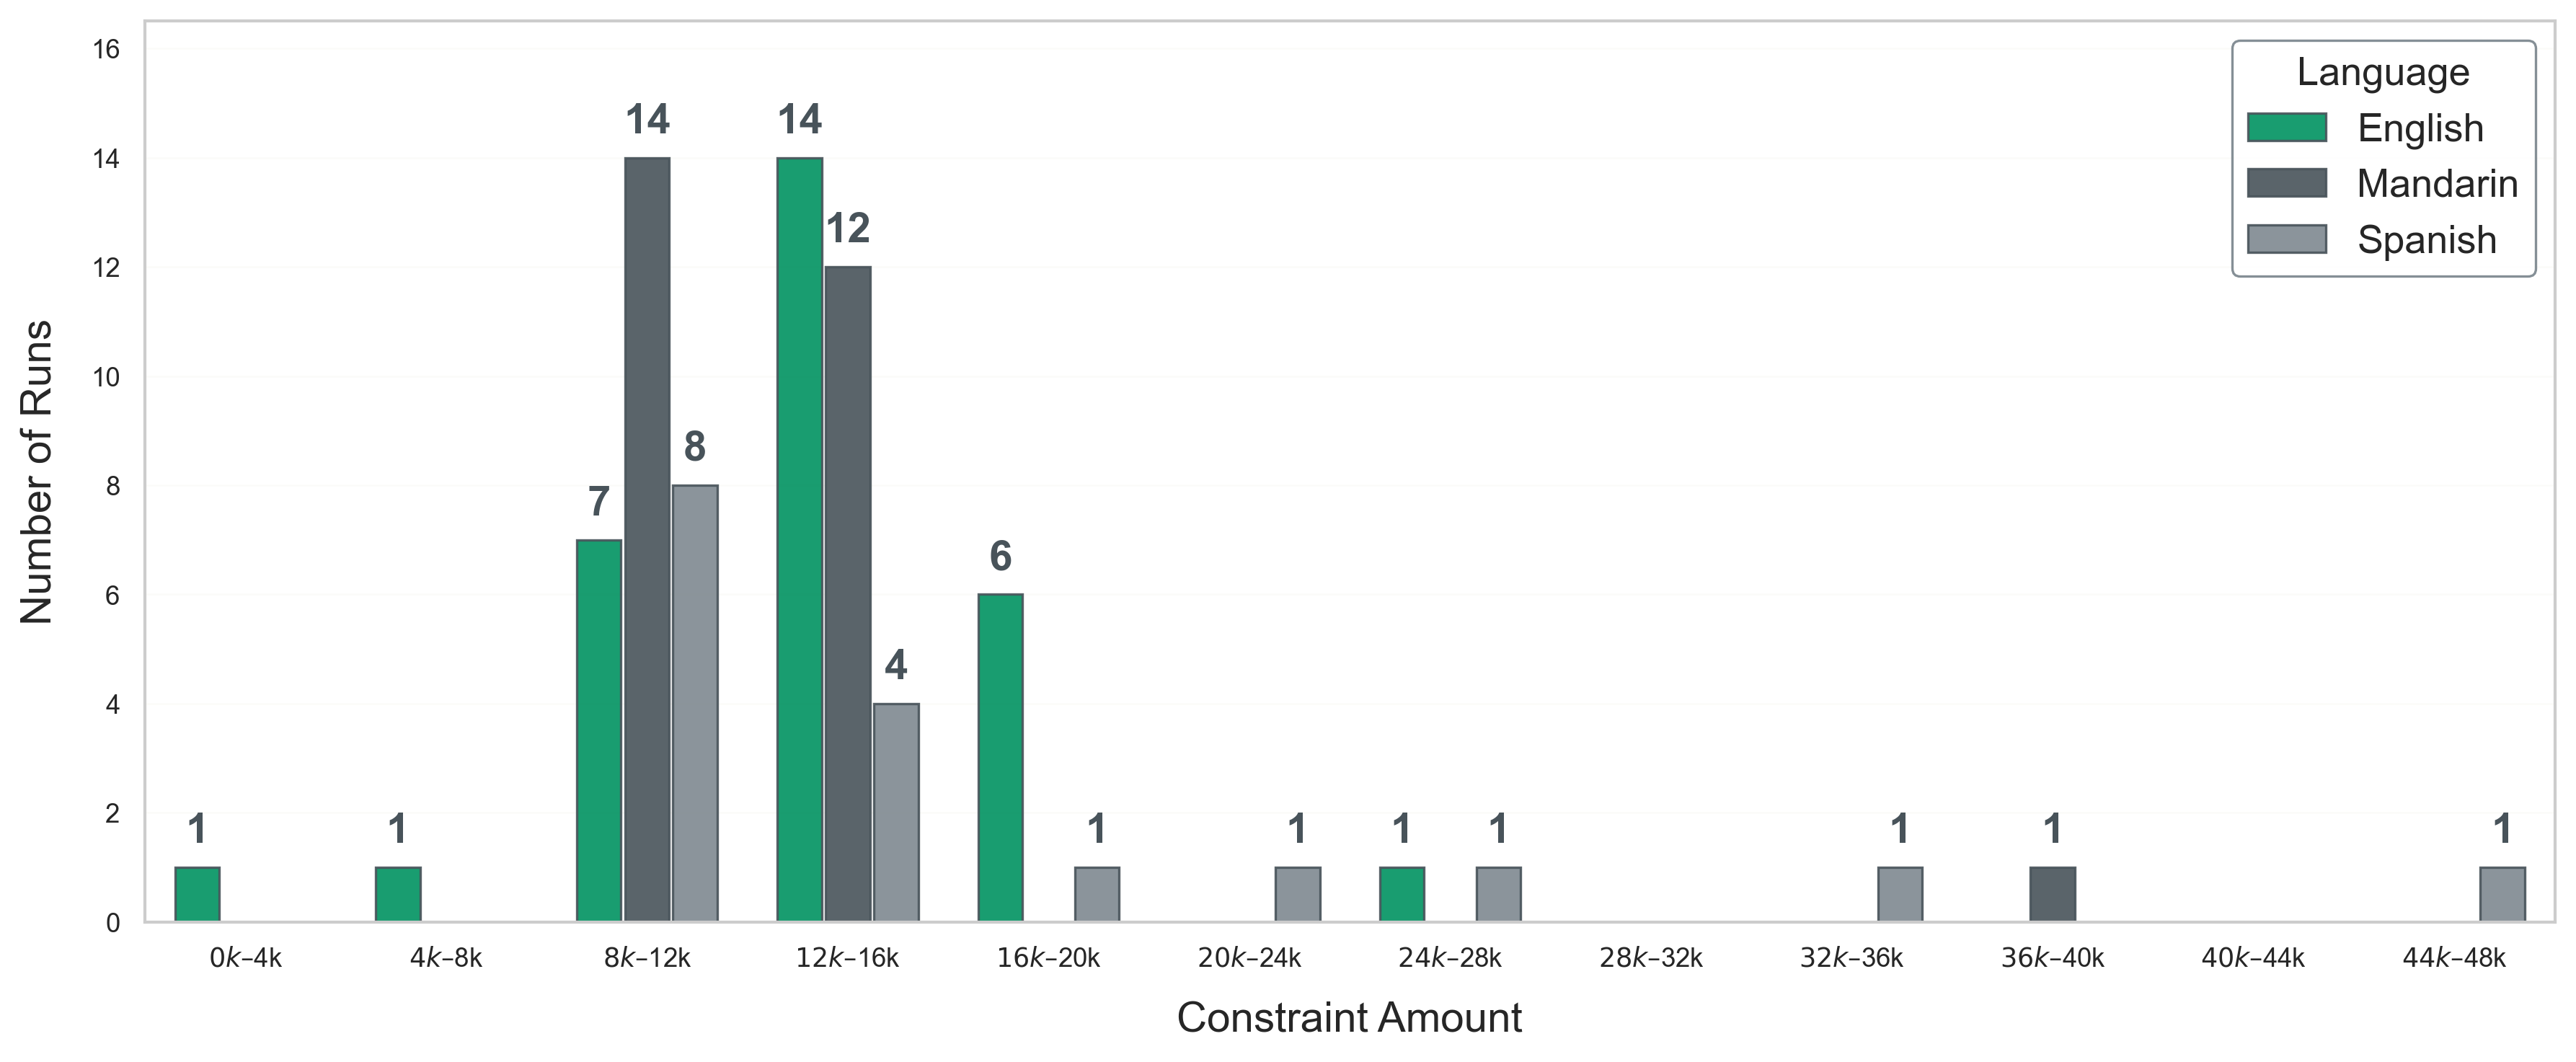

In [12]:
grouped_constraint_data = [
    (label, group_datasets[label].vote_rounds if label in group_datasets else None)
    for label in ordered_languages
]

plot_floor_constraint_distribution_grouped(
    grouped_constraint_data,
    language_order=ordered_languages,
    target_principle_label="Max Avg + Floor",
    font_scale=1.3,
    bin_width=4000,
    show_title=False,
    annotation_fontsize=14,
)


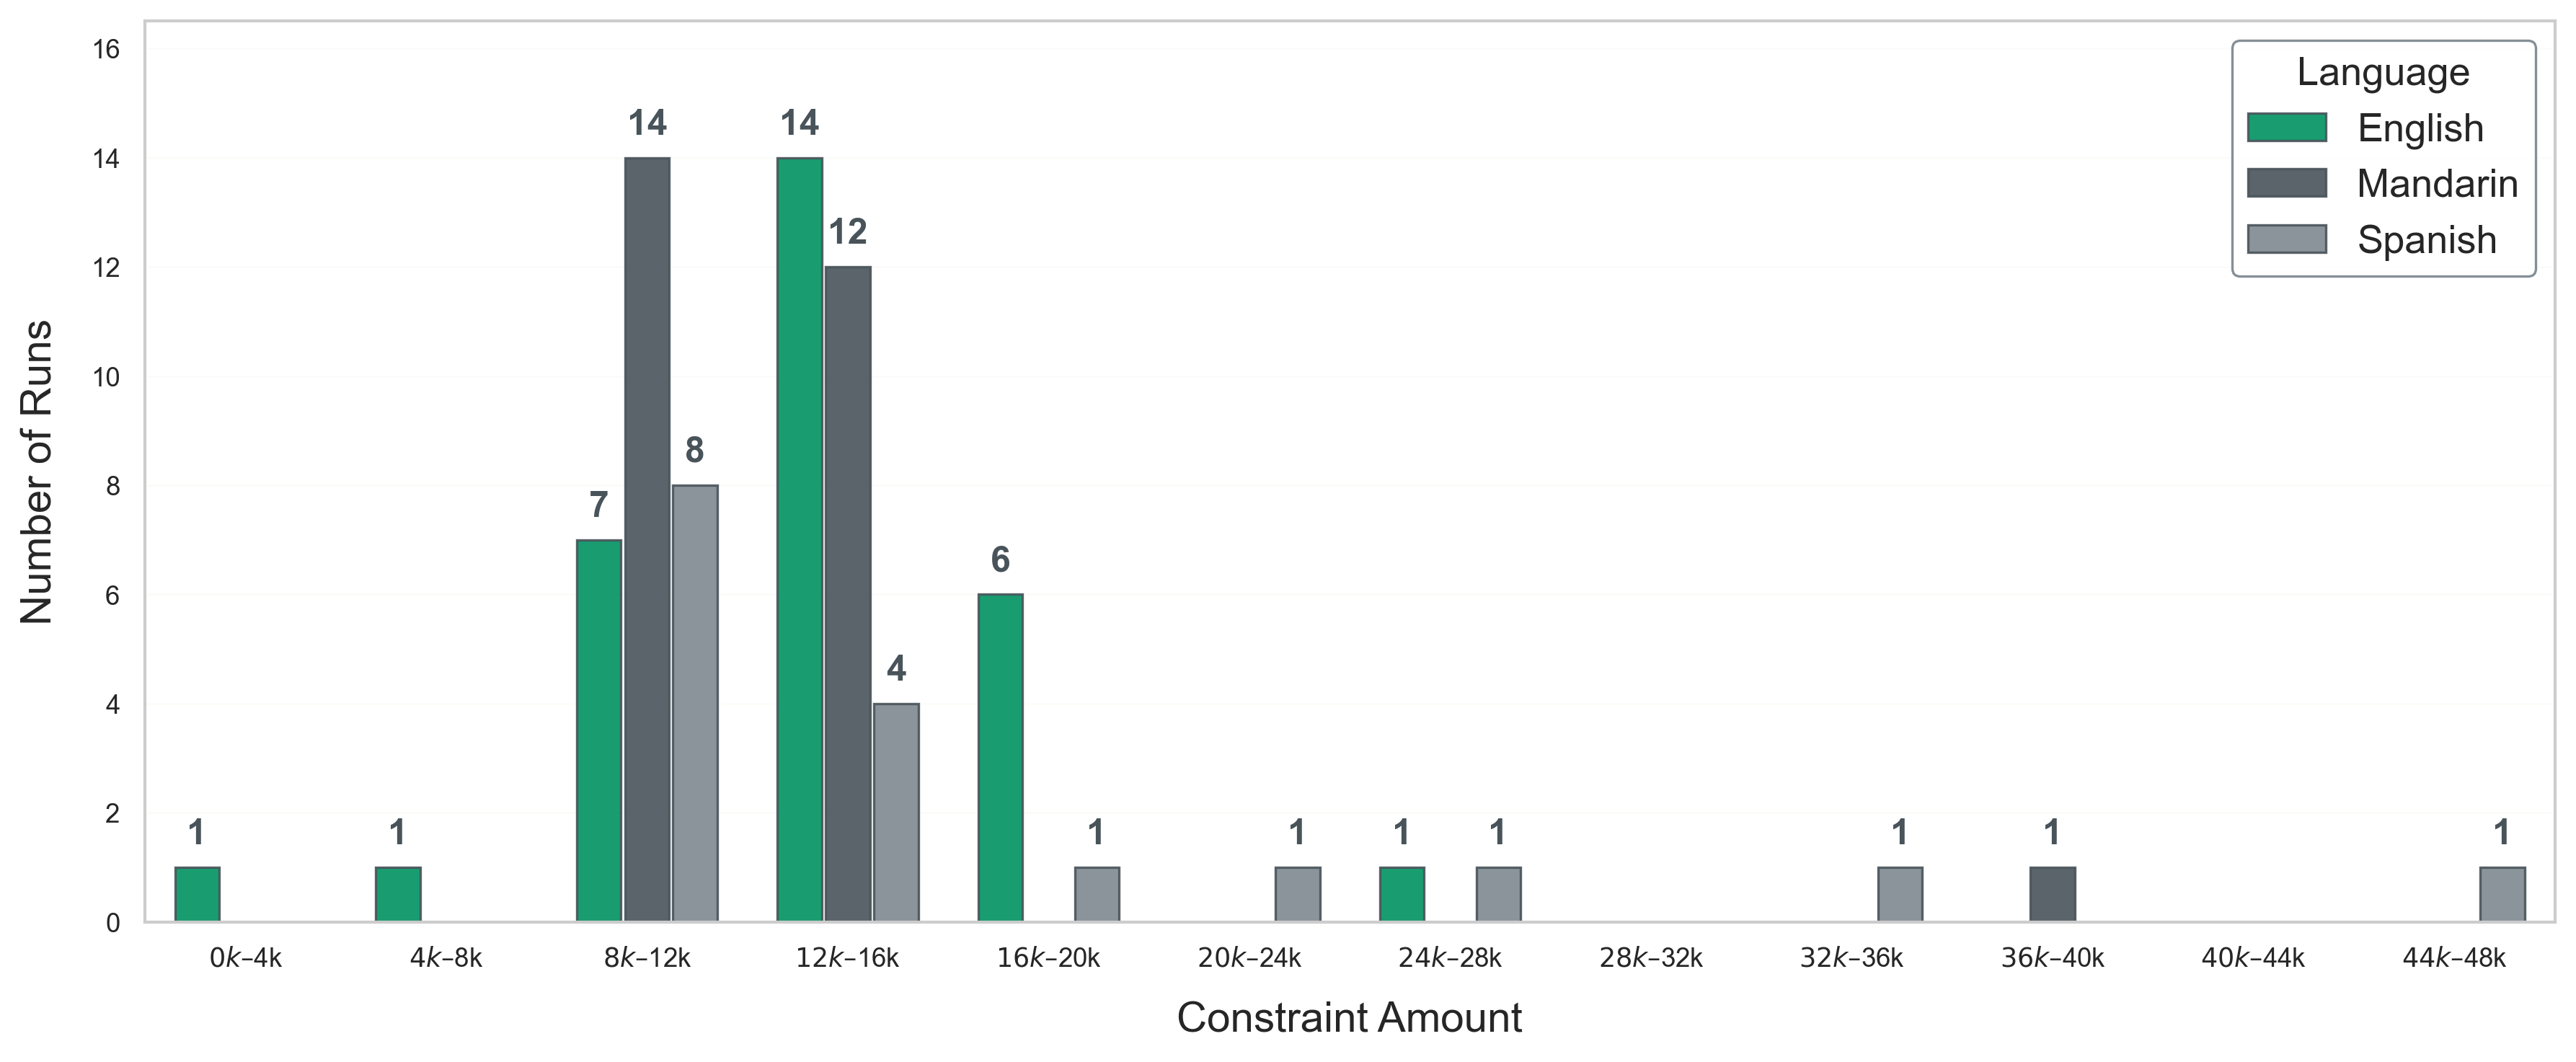

In [13]:
grouped_constraint_data = [
    (label, group_datasets[label].vote_rounds if label in group_datasets else None)
    for label in ordered_languages
]

plot_floor_constraint_distribution_grouped(
    grouped_constraint_data,
    language_order=ordered_languages,
    target_principle_label="Max Avg + Floor",
    font_scale=1.3,
    bin_width=4000,
    show_title=False,
)